# PPO

We will use Ray libiray to implement the PPO model, with code modified from the official website of Ray.

Note: 4000 timesteps per iteration.

Code reference: https://docs.ray.io/en/latest/rllib/rllib-training.html#basic-python-api

In [1]:
#if needed: !pip install -U "ray[rllib]"
import numpy as np
from random import random
import seaborn as sns
from scipy import stats
import matplotlib.pyplot as plt
import copy
import os
import time
import torch, torchvision, cv2
import tensorflow as tf

import gym
import ray
from ray import tune
import ray.rllib.agents.ppo as ppo
from ray.tune.logger import pretty_print
from ray.tune import JupyterNotebookReporter, CLIReporter, ProgressReporter

In [2]:
device = torch.device('cpu')
if torch.cuda.is_available():
   device = torch.device('cuda')

print(device)

cpu


In [3]:
seeds=[12345,42,42,42]
def randomize(seed_rng=seeds[0], seed_np=seeds[1], seed_torch=seeds[2], seed_tf=seeds[3]):
    tf.keras.backend.clear_session()
    os.environ['PYTHONHASHSEED'] = '0'
    rng = np.random.default_rng(seed_rng)
    np.random.seed(seed_np)
    torch.manual_seed(seed_torch)
    tf.random.set_seed(seed_tf)

In [4]:
#initialize ray
ray.init(ignore_reinit_error=True)
#set config
config_ppo = ppo.DEFAULT_CONFIG.copy()
config_ppo["num_gpus"] = 0
config_ppo["num_workers"] = 1
config_ppo["framework"] = 'torch'

In [5]:
#instantiate trainer
trainer_ppo = ppo.PPOTrainer(config=config_ppo, env="Breakout-v0")

2022-04-16 21:49:10,735	INFO ppo.py:249 -- In multi-agent mode, policies will be optimized sequentially by the multi-GPU optimizer. Consider setting simple_optimizer=True if this doesn't work for you.
2022-04-16 21:49:10,736	INFO trainer.py:779 -- Current log_level is WARN. For more information, set 'log_level': 'INFO' / 'DEBUG' or use the -v and -vv flags.
(RolloutWorker pid=1294) A.L.E: Arcade Learning Environment (version 0.7.4+069f8bd)
(RolloutWorker pid=1294) [Powered by Stella]
(RolloutWorker pid=1294) [W NNPACK.cpp:51] Could not initialize NNPACK! Reason: Unsupported hardware.
[W NNPACK.cpp:51] Could not initialize NNPACK! Reason: Unsupported hardware.


In [6]:
config_ppo

{'num_workers': 1,
 'num_envs_per_worker': 1,
 'create_env_on_driver': False,
 'rollout_fragment_length': 200,
 'batch_mode': 'truncate_episodes',
 'gamma': 0.99,
 'lr': 5e-05,
 'train_batch_size': 4000,
 'model': {'_use_default_native_models': False,
  '_disable_preprocessor_api': False,
  '_disable_action_flattening': False,
  'fcnet_hiddens': [256, 256],
  'fcnet_activation': 'tanh',
  'conv_filters': None,
  'conv_activation': 'relu',
  'post_fcnet_hiddens': [],
  'post_fcnet_activation': 'relu',
  'free_log_std': False,
  'no_final_linear': False,
  'vf_share_layers': False,
  'use_lstm': False,
  'max_seq_len': 20,
  'lstm_cell_size': 256,
  'lstm_use_prev_action': False,
  'lstm_use_prev_reward': False,
  '_time_major': False,
  'use_attention': False,
  'attention_num_transformer_units': 1,
  'attention_dim': 64,
  'attention_num_heads': 1,
  'attention_head_dim': 32,
  'attention_memory_inference': 50,
  'attention_memory_training': 50,
  'attention_position_wise_mlp_dim': 32,

In [7]:
#PPO training function

def train(trainer, iteration=100, checkpoint_freq=10, metric='episode_reward_mean', seeds=seeds):
    start_time=time.time()
    randomize(seeds[0],seeds[1],seeds[2],seeds[3])
    metrics = []
    checkpoint = None
    for i in range(iteration):
        result = trainer.train()
        print(result[metric])
        metrics.append(result[metric])

    if (i+1) % checkpoint_freq == 0:
        checkpoint = trainer.save()
        print("checkpoint saved at", checkpoint)
    
    end_time=time.time()
    print("{} training iterations done in {:.2f} seconds".format(iteration, end_time-start_time))

    return metrics, checkpoint

In [8]:
metrics, checkpoint = train(trainer_ppo, 2)

2.2857142857142856
1.9655172413793103
2 training iterations done in 975.37 seconds


In [9]:
#Set hyperparameters to tune
config_ppo_tune={
        "env": "Breakout-v0",
        "num_gpus": 0,
        "num_workers": 1,
        "framework": "torch",
        "clip_param": tune.grid_search([0.3, 0.2]),
        "lr": tune.grid_search([5e-5, 1e-5]),
    }
#set stopping criteria & reporting style/frequency for tuning
stop = tune.stopper.MaximumIterationStopper(max_iter=20)
reporter = JupyterNotebookReporter(overwrite=False, max_report_frequency=1000)   #unit: seconds

In [10]:
#tune hyperparameters and save checkpoints
randomize()
# tune.run() allows setting a custom log directory (other than ``~/ray-results``)
# and automatically saving the trained agent
analysis = tune.run(
    ppo.PPOTrainer,
    config=config_ppo_tune,
    stop=stop,
    progress_reporter=reporter,
    checkpoint_at_end=True,)

# list of lists: one list per checkpoint; each checkpoint list contains
# 1st the path, 2nd the metric value
checkpoints = analysis.get_trial_checkpoints_paths(
    trial=analysis.get_best_trial("episode_reward_mean"),
    metric="episode_reward_mean")

# if there are multiple trials, select a specific trial or automatically
# choose the best one according to a given metric
last_checkpoint = analysis.get_last_checkpoint(
    metric="episode_reward_mean", mode="max"
)

Trial name,status,loc,clip_param,lr
PPOTrainer_Breakout-v0_f344c_00000,PENDING,,0.3,5e-05
PPOTrainer_Breakout-v0_f344c_00001,PENDING,,0.2,5e-05
PPOTrainer_Breakout-v0_f344c_00002,PENDING,,0.3,1e-05
PPOTrainer_Breakout-v0_f344c_00003,PENDING,,0.2,1e-05


(PPOTrainer pid=1291) 2022-04-16 22:05:37,538	INFO ppo.py:249 -- In multi-agent mode, policies will be optimized sequentially by the multi-GPU optimizer. Consider setting simple_optimizer=True if this doesn't work for you.
(PPOTrainer pid=1291) 2022-04-16 22:05:37,538	INFO trainer.py:779 -- Current log_level is WARN. For more information, set 'log_level': 'INFO' / 'DEBUG' or use the -v and -vv flags.
(PPOTrainer pid=1295) 2022-04-16 22:05:37,538	INFO ppo.py:249 -- In multi-agent mode, policies will be optimized sequentially by the multi-GPU optimizer. Consider setting simple_optimizer=True if this doesn't work for you.
(PPOTrainer pid=1295) 2022-04-16 22:05:37,538	INFO trainer.py:779 -- Current log_level is WARN. For more information, set 'log_level': 'INFO' / 'DEBUG' or use the -v and -vv flags.
(PPOTrainer pid=1292) 2022-04-16 22:05:37,538	INFO ppo.py:249 -- In multi-agent mode, policies will be optimized sequentially by the multi-GPU optimizer. Consider setting simple_optimizer=True

Result for PPOTrainer_Breakout-v0_f344c_00000:
  agent_timesteps_total: 4000
  custom_metrics: {}
  date: 2022-04-16_22-15-06
  done: false
  episode_len_mean: 260.05882352941177
  episode_media: {}
  episode_reward_max: 3.0
  episode_reward_mean: 1.588235294117647
  episode_reward_min: 0.0
  episodes_this_iter: 17
  episodes_total: 17
  experiment_id: ce7968635bf3477eae29603782a5d12a
  hostname: Suens-MBP
  info:
    learner:
      default_policy:
        custom_metrics: {}
        learner_stats:
          allreduce_latency: 0.0
          cur_kl_coeff: 0.20000000000000004
          cur_lr: 5.0000000000000016e-05
          entropy: 5.856729704574391e-07
          entropy_coeff: 0.0
          kl: .inf
          policy_loss: -0.0019813127214870145
          total_loss: .inf
          vf_explained_var: 0.010308999848622147
          vf_loss: 3.8098805889166814
        model: {}
    num_agent_steps_sampled: 4000
    num_agent_steps_trained: 4000
    num_steps_sampled: 4000
    num_steps_tr

Trial name,status,loc,clip_param,lr,iter,total time (s),ts,reward,episode_reward_max,episode_reward_min,episode_len_mean
PPOTrainer_Breakout-v0_f344c_00000,RUNNING,127.0.0.1:1292,0.3,5e-05,1,563.87,4000,1.58824,3,0,260.059
PPOTrainer_Breakout-v0_f344c_00001,RUNNING,127.0.0.1:1291,0.2,5e-05,1,564.503,4000,1.86667,3,0,286.2
PPOTrainer_Breakout-v0_f344c_00002,RUNNING,127.0.0.1:1295,0.3,1e-05,1,564.931,4000,2.5,5,2,311.143
PPOTrainer_Breakout-v0_f344c_00003,PENDING,,0.2,1e-05,,,,,,,


Result for PPOTrainer_Breakout-v0_f344c_00001:
  agent_timesteps_total: 8000
  custom_metrics: {}
  date: 2022-04-16_22-24-28
  done: false
  episode_len_mean: 287.5483870967742
  episode_media: {}
  episode_reward_max: 4.0
  episode_reward_mean: 1.903225806451613
  episode_reward_min: 0.0
  episodes_this_iter: 16
  episodes_total: 31
  experiment_id: c0ac0c3a0c054f709df65accf82842fb
  hostname: Suens-MBP
  info:
    learner:
      default_policy:
        custom_metrics: {}
        learner_stats:
          allreduce_latency: 0.0
          cur_kl_coeff: 0.3
          cur_lr: 5.0000000000000016e-05
          entropy: 0.3902261104314558
          entropy_coeff: 0.0
          kl: 0.021033264640635187
          policy_loss: -0.011938265256798997
          total_loss: 0.3451614955304972
          vf_explained_var: 0.22069576626182885
          vf_loss: 0.35078978193623406
        model: {}
    num_agent_steps_sampled: 8000
    num_agent_steps_trained: 8000
    num_steps_sampled: 8000
    num

Result for PPOTrainer_Breakout-v0_f344c_00002:
  agent_timesteps_total: 12000
  custom_metrics: {}
  date: 2022-04-16_22-33-53
  done: false
  episode_len_mean: 281.9782608695652
  episode_media: {}
  episode_reward_max: 5.0
  episode_reward_mean: 2.0434782608695654
  episode_reward_min: 0.0
  episodes_this_iter: 16
  episodes_total: 46
  experiment_id: 39af55ef22764cddae11efeec83f3da7
  hostname: Suens-MBP
  info:
    learner:
      default_policy:
        custom_metrics: {}
        learner_stats:
          allreduce_latency: 0.0
          cur_kl_coeff: 0.15
          cur_lr: 9.999999999999999e-06
          entropy: 0.04160231812503464
          entropy_coeff: 0.0
          kl: 0.015384514787033494
          policy_loss: 0.009687073500726813
          total_loss: 0.1274550463757678
          vf_explained_var: 0.5180497203462867
          vf_loss: 0.11546029535232372
        model: {}
    num_agent_steps_sampled: 12000
    num_agent_steps_trained: 12000
    num_steps_sampled: 12000
   

Trial name,status,loc,clip_param,lr,iter,total time (s),ts,reward,episode_reward_max,episode_reward_min,episode_len_mean
PPOTrainer_Breakout-v0_f344c_00000,RUNNING,127.0.0.1:1292,0.3,5e-05,3,1688.88,12000,1.83673,3,0,272.429
PPOTrainer_Breakout-v0_f344c_00001,RUNNING,127.0.0.1:1291,0.2,5e-05,3,1688.78,12000,1.72917,4,0,276.146
PPOTrainer_Breakout-v0_f344c_00002,RUNNING,127.0.0.1:1295,0.3,1e-05,3,1690.87,12000,2.04348,5,0,281.978
PPOTrainer_Breakout-v0_f344c_00003,PENDING,,0.2,1e-05,,,,,,,


Result for PPOTrainer_Breakout-v0_f344c_00001:
  agent_timesteps_total: 16000
  custom_metrics: {}
  date: 2022-04-16_22-43-15
  done: false
  episode_len_mean: 279.234375
  episode_media: {}
  episode_reward_max: 4.0
  episode_reward_mean: 1.8125
  episode_reward_min: 0.0
  episodes_this_iter: 16
  episodes_total: 64
  experiment_id: c0ac0c3a0c054f709df65accf82842fb
  hostname: Suens-MBP
  info:
    learner:
      default_policy:
        custom_metrics: {}
        learner_stats:
          allreduce_latency: 0.0
          cur_kl_coeff: 0.4500000000000001
          cur_lr: 5.0000000000000016e-05
          entropy: 0.38075154990919174
          entropy_coeff: 0.0
          kl: 0.008660254109997101
          policy_loss: -0.0237756265036922
          total_loss: 0.017749836052122017
          vf_explained_var: 0.6143425121102282
          vf_loss: 0.03762834877206353
        model: {}
    num_agent_steps_sampled: 16000
    num_agent_steps_trained: 16000
    num_steps_sampled: 16000
    nu

Result for PPOTrainer_Breakout-v0_f344c_00002:
  agent_timesteps_total: 20000
  custom_metrics: {}
  date: 2022-04-16_22-52-48
  done: false
  episode_len_mean: 273.18518518518516
  episode_media: {}
  episode_reward_max: 5.0
  episode_reward_mean: 1.8641975308641976
  episode_reward_min: 0.0
  episodes_this_iter: 18
  episodes_total: 81
  experiment_id: 39af55ef22764cddae11efeec83f3da7
  hostname: Suens-MBP
  info:
    learner:
      default_policy:
        custom_metrics: {}
        learner_stats:
          allreduce_latency: 0.0
          cur_kl_coeff: 0.075
          cur_lr: 9.999999999999999e-06
          entropy: 0.02416586984039387
          entropy_coeff: 0.0
          kl: 0.023998906270626355
          policy_loss: -0.01003260413004506
          total_loss: 0.05535131969698204
          vf_explained_var: 0.23574588971753274
          vf_loss: 0.0635840077103386
        model: {}
    num_agent_steps_sampled: 20000
    num_agent_steps_trained: 20000
    num_steps_sampled: 20000


Trial name,status,loc,clip_param,lr,iter,total time (s),ts,reward,episode_reward_max,episode_reward_min,episode_len_mean
PPOTrainer_Breakout-v0_f344c_00000,RUNNING,127.0.0.1:1292,0.3,5e-05,5,2823.24,20000,1.88889,4,0,274.407
PPOTrainer_Breakout-v0_f344c_00001,RUNNING,127.0.0.1:1291,0.2,5e-05,5,2821.75,20000,1.86076,5,0,282.392
PPOTrainer_Breakout-v0_f344c_00002,RUNNING,127.0.0.1:1295,0.3,1e-05,5,2825.89,20000,1.8642,5,0,273.185
PPOTrainer_Breakout-v0_f344c_00003,PENDING,,0.2,1e-05,,,,,,,


Result for PPOTrainer_Breakout-v0_f344c_00001:
  agent_timesteps_total: 24000
  custom_metrics: {}
  date: 2022-04-16_23-02-13
  done: false
  episode_len_mean: 281.4736842105263
  episode_media: {}
  episode_reward_max: 5.0
  episode_reward_mean: 1.8421052631578947
  episode_reward_min: 0.0
  episodes_this_iter: 16
  episodes_total: 95
  experiment_id: c0ac0c3a0c054f709df65accf82842fb
  hostname: Suens-MBP
  info:
    learner:
      default_policy:
        custom_metrics: {}
        learner_stats:
          allreduce_latency: 0.0
          cur_kl_coeff: 0.4500000000000001
          cur_lr: 5.0000000000000016e-05
          entropy: 0.43192795524674077
          entropy_coeff: 0.0
          kl: 0.012403165225698677
          policy_loss: -0.026949060565581724
          total_loss: 0.042160559649408985
          vf_explained_var: 0.3511443598296053
          vf_loss: 0.06352819603597445
        model: {}
    num_agent_steps_sampled: 24000
    num_agent_steps_trained: 24000
    num_steps_

Result for PPOTrainer_Breakout-v0_f344c_00000:
  agent_timesteps_total: 28000
  custom_metrics: {}
  date: 2022-04-16_23-11-41
  done: false
  episode_len_mean: 275.74
  episode_media: {}
  episode_reward_max: 4.0
  episode_reward_mean: 1.92
  episode_reward_min: 0.0
  episodes_this_iter: 16
  episodes_total: 114
  experiment_id: ce7968635bf3477eae29603782a5d12a
  hostname: Suens-MBP
  info:
    learner:
      default_policy:
        custom_metrics: {}
        learner_stats:
          allreduce_latency: 0.0
          cur_kl_coeff: 0.009375
          cur_lr: 5.0000000000000016e-05
          entropy: 0.0
          entropy_coeff: 0.0
          kl: 0.0
          policy_loss: -0.008549073921336282
          total_loss: 0.017683792939930353
          vf_explained_var: 0.6503314929623758
          vf_loss: 0.026232864535463755
        model: {}
    num_agent_steps_sampled: 28000
    num_agent_steps_trained: 28000
    num_steps_sampled: 28000
    num_steps_trained: 28000
    num_steps_trained_

Trial name,status,loc,clip_param,lr,iter,total time (s),ts,reward,episode_reward_max,episode_reward_min,episode_len_mean
PPOTrainer_Breakout-v0_f344c_00000,RUNNING,127.0.0.1:1292,0.3,5e-05,7,3958.01,28000,1.92,4,0,275.74
PPOTrainer_Breakout-v0_f344c_00001,RUNNING,127.0.0.1:1291,0.2,5e-05,7,3956.33,28000,1.92,5,0,285.3
PPOTrainer_Breakout-v0_f344c_00002,RUNNING,127.0.0.1:1295,0.3,1e-05,7,3961.22,28000,1.83,4,0,270.81
PPOTrainer_Breakout-v0_f344c_00003,PENDING,,0.2,1e-05,,,,,,,


Result for PPOTrainer_Breakout-v0_f344c_00001:
  agent_timesteps_total: 32000
  custom_metrics: {}
  date: 2022-04-16_23-21-39
  done: false
  episode_len_mean: 290.8
  episode_media: {}
  episode_reward_max: 5.0
  episode_reward_mean: 2.02
  episode_reward_min: 0.0
  episodes_this_iter: 14
  episodes_total: 123
  experiment_id: c0ac0c3a0c054f709df65accf82842fb
  hostname: Suens-MBP
  info:
    learner:
      default_policy:
        custom_metrics: {}
        learner_stats:
          allreduce_latency: 0.0
          cur_kl_coeff: 0.4500000000000001
          cur_lr: 5.0000000000000016e-05
          entropy: 0.45427675040498855
          entropy_coeff: 0.0
          kl: 0.013301539845565691
          policy_loss: -0.04088703249130518
          total_loss: -0.004614013568648407
          vf_explained_var: 0.5195522898627866
          vf_loss: 0.03028732718253929
        model: {}
    num_agent_steps_sampled: 32000
    num_agent_steps_trained: 32000
    num_steps_sampled: 32000
    num_st

Trial name,status,loc,clip_param,lr,iter,total time (s),ts,reward,episode_reward_max,episode_reward_min,episode_len_mean
PPOTrainer_Breakout-v0_f344c_00000,RUNNING,127.0.0.1:1292,0.3,5e-05,8,4558.81,32000,1.81,4,0,270.55
PPOTrainer_Breakout-v0_f344c_00001,RUNNING,127.0.0.1:1291,0.2,5e-05,8,4555.87,32000,2.02,5,0,290.8
PPOTrainer_Breakout-v0_f344c_00002,RUNNING,127.0.0.1:1295,0.3,1e-05,8,4561.04,32000,1.86,6,0,273.79
PPOTrainer_Breakout-v0_f344c_00003,PENDING,,0.2,1e-05,,,,,,,


Result for PPOTrainer_Breakout-v0_f344c_00001:
  agent_timesteps_total: 36000
  custom_metrics: {}
  date: 2022-04-16_23-31-55
  done: false
  episode_len_mean: 284.65
  episode_media: {}
  episode_reward_max: 5.0
  episode_reward_mean: 1.91
  episode_reward_min: 0.0
  episodes_this_iter: 17
  episodes_total: 140
  experiment_id: c0ac0c3a0c054f709df65accf82842fb
  hostname: Suens-MBP
  info:
    learner:
      default_policy:
        custom_metrics: {}
        learner_stats:
          allreduce_latency: 0.0
          cur_kl_coeff: 0.4500000000000001
          cur_lr: 5.0000000000000016e-05
          entropy: 0.46316933300225965
          entropy_coeff: 0.0
          kl: 0.011067126589757092
          policy_loss: -0.0259483426904446
          total_loss: -0.004958228545603893
          vf_explained_var: 0.320629955491712
          vf_loss: 0.01600990809615381
        model: {}
    num_agent_steps_sampled: 36000
    num_agent_steps_trained: 36000
    num_steps_sampled: 36000
    num_ste

Result for PPOTrainer_Breakout-v0_f344c_00002:
  agent_timesteps_total: 40000
  custom_metrics: {}
  date: 2022-04-16_23-42-01
  done: false
  episode_len_mean: 269.69
  episode_media: {}
  episode_reward_max: 6.0
  episode_reward_mean: 1.78
  episode_reward_min: 0.0
  episodes_this_iter: 18
  episodes_total: 162
  experiment_id: 39af55ef22764cddae11efeec83f3da7
  hostname: Suens-MBP
  info:
    learner:
      default_policy:
        custom_metrics: {}
        learner_stats:
          allreduce_latency: 0.0
          cur_kl_coeff: 0.007031250000000002
          cur_lr: 9.999999999999999e-06
          entropy: 0.00017707610883418613
          entropy_coeff: 0.0
          kl: 2.0236705148065323e-06
          policy_loss: -0.003839955385774374
          total_loss: 0.025622439069041818
          vf_explained_var: 0.3928989855832951
          vf_loss: 0.029462380013278416
        model: {}
    num_agent_steps_sampled: 40000
    num_agent_steps_trained: 40000
    num_steps_sampled: 40000
  

Trial name,status,loc,clip_param,lr,iter,total time (s),ts,reward,episode_reward_max,episode_reward_min,episode_len_mean
PPOTrainer_Breakout-v0_f344c_00000,RUNNING,127.0.0.1:1292,0.3,5e-05,10,5774.8,40000,1.81,4,0,269.58
PPOTrainer_Breakout-v0_f344c_00001,RUNNING,127.0.0.1:1291,0.2,5e-05,10,5772.76,40000,1.97,5,0,287.73
PPOTrainer_Breakout-v0_f344c_00002,RUNNING,127.0.0.1:1295,0.3,1e-05,10,5778.34,40000,1.78,6,0,269.69
PPOTrainer_Breakout-v0_f344c_00003,PENDING,,0.2,1e-05,,,,,,,


Result for PPOTrainer_Breakout-v0_f344c_00001:
  agent_timesteps_total: 44000
  custom_metrics: {}
  date: 2022-04-16_23-51-58
  done: false
  episode_len_mean: 280.11
  episode_media: {}
  episode_reward_max: 5.0
  episode_reward_mean: 1.83
  episode_reward_min: 0.0
  episodes_this_iter: 17
  episodes_total: 174
  experiment_id: c0ac0c3a0c054f709df65accf82842fb
  hostname: Suens-MBP
  info:
    learner:
      default_policy:
        custom_metrics: {}
        learner_stats:
          allreduce_latency: 0.0
          cur_kl_coeff: 0.4500000000000001
          cur_lr: 5.0000000000000016e-05
          entropy: 0.4760539632971569
          entropy_coeff: 0.0
          kl: 0.012754872121057857
          policy_loss: -0.04106193048909547
          total_loss: -0.024250947693062404
          vf_explained_var: 0.4656703108741391
          vf_loss: 0.011071290024956788
        model: {}
    num_agent_steps_sampled: 44000
    num_agent_steps_trained: 44000
    num_steps_sampled: 44000
    num_s

Result for PPOTrainer_Breakout-v0_f344c_00002:
  agent_timesteps_total: 48000
  custom_metrics: {}
  date: 2022-04-17_00-02-07
  done: false
  episode_len_mean: 269.39
  episode_media: {}
  episode_reward_max: 6.0
  episode_reward_mean: 1.78
  episode_reward_min: 0.0
  episodes_this_iter: 17
  episodes_total: 196
  experiment_id: 39af55ef22764cddae11efeec83f3da7
  hostname: Suens-MBP
  info:
    learner:
      default_policy:
        custom_metrics: {}
        learner_stats:
          allreduce_latency: 0.0
          cur_kl_coeff: 0.0017578125000000005
          cur_lr: 9.999999999999999e-06
          entropy: 3.958811364872838e-05
          entropy_coeff: 0.0
          kl: 6.523702846577519e-06
          policy_loss: -0.004512671182953542
          total_loss: 0.026732827842684485
          vf_explained_var: 0.47241535859723244
          vf_loss: 0.031245490156054018
        model: {}
    num_agent_steps_sampled: 48000
    num_agent_steps_trained: 48000
    num_steps_sampled: 48000
  

Trial name,status,loc,clip_param,lr,iter,total time (s),ts,reward,episode_reward_max,episode_reward_min,episode_len_mean
PPOTrainer_Breakout-v0_f344c_00000,RUNNING,127.0.0.1:1292,0.3,5e-05,12,6979.96,48000,1.79,4,0,269.46
PPOTrainer_Breakout-v0_f344c_00001,RUNNING,127.0.0.1:1291,0.2,5e-05,12,6978.21,48000,1.79,5,0,278.13
PPOTrainer_Breakout-v0_f344c_00002,RUNNING,127.0.0.1:1295,0.3,1e-05,12,6983.96,48000,1.78,6,0,269.39
PPOTrainer_Breakout-v0_f344c_00003,PENDING,,0.2,1e-05,,,,,,,


Result for PPOTrainer_Breakout-v0_f344c_00001:
  agent_timesteps_total: 52000
  custom_metrics: {}
  date: 2022-04-17_00-12-11
  done: false
  episode_len_mean: 280.34
  episode_media: {}
  episode_reward_max: 5.0
  episode_reward_mean: 1.83
  episode_reward_min: 0.0
  episodes_this_iter: 14
  episodes_total: 205
  experiment_id: c0ac0c3a0c054f709df65accf82842fb
  hostname: Suens-MBP
  info:
    learner:
      default_policy:
        custom_metrics: {}
        learner_stats:
          allreduce_latency: 0.0
          cur_kl_coeff: 0.4500000000000001
          cur_lr: 5.0000000000000016e-05
          entropy: 0.4899537385631633
          entropy_coeff: 0.0
          kl: 0.0161272569878618
          policy_loss: -0.0460533171071
          total_loss: -0.027607345627120104
          vf_explained_var: 0.6286137457175921
          vf_loss: 0.0111887032714402
        model: {}
    num_agent_steps_sampled: 52000
    num_agent_steps_trained: 52000
    num_steps_sampled: 52000
    num_steps_tra

Trial name,status,loc,clip_param,lr,iter,total time (s),ts,reward,episode_reward_max,episode_reward_min,episode_len_mean
PPOTrainer_Breakout-v0_f344c_00000,RUNNING,127.0.0.1:1292,0.3,5e-05,13,7588.37,52000,1.79,4,0,268.53
PPOTrainer_Breakout-v0_f344c_00001,RUNNING,127.0.0.1:1291,0.2,5e-05,13,7587.95,52000,1.83,5,0,280.34
PPOTrainer_Breakout-v0_f344c_00002,RUNNING,127.0.0.1:1295,0.3,1e-05,13,7593.34,52000,1.77,6,0,268.17
PPOTrainer_Breakout-v0_f344c_00003,PENDING,,0.2,1e-05,,,,,,,


Result for PPOTrainer_Breakout-v0_f344c_00001:
  agent_timesteps_total: 56000
  custom_metrics: {}
  date: 2022-04-17_00-22-06
  done: false
  episode_len_mean: 270.37
  episode_media: {}
  episode_reward_max: 4.0
  episode_reward_mean: 1.65
  episode_reward_min: 0.0
  episodes_this_iter: 18
  episodes_total: 223
  experiment_id: c0ac0c3a0c054f709df65accf82842fb
  hostname: Suens-MBP
  info:
    learner:
      default_policy:
        custom_metrics: {}
        learner_stats:
          allreduce_latency: 0.0
          cur_kl_coeff: 0.4500000000000001
          cur_lr: 5.0000000000000016e-05
          entropy: 0.5054884787849201
          entropy_coeff: 0.0
          kl: 0.013847109551193055
          policy_loss: -0.03875620976511029
          total_loss: -0.025906232078008913
          vf_explained_var: 0.20773549515713927
          vf_loss: 0.006618778036671981
        model: {}
    num_agent_steps_sampled: 56000
    num_agent_steps_trained: 56000
    num_steps_sampled: 56000
    num_

Result for PPOTrainer_Breakout-v0_f344c_00002:
  agent_timesteps_total: 60000
  custom_metrics: {}
  date: 2022-04-17_00-31-34
  done: false
  episode_len_mean: 266.31
  episode_media: {}
  episode_reward_max: 4.0
  episode_reward_mean: 1.75
  episode_reward_min: 0.0
  episodes_this_iter: 15
  episodes_total: 245
  experiment_id: 39af55ef22764cddae11efeec83f3da7
  hostname: Suens-MBP
  info:
    learner:
      default_policy:
        custom_metrics: {}
        learner_stats:
          allreduce_latency: 0.0
          cur_kl_coeff: 0.0008789062500000002
          cur_lr: 9.999999999999999e-06
          entropy: 2.016890777832286e-06
          entropy_coeff: 0.0
          kl: -8.099837353199629e-10
          policy_loss: 1.9359632685620296e-06
          total_loss: 0.02195901231519798
          vf_explained_var: 0.6780290960624654
          vf_loss: 0.021957077587684316
        model: {}
    num_agent_steps_sampled: 60000
    num_agent_steps_trained: 60000
    num_steps_sampled: 60000
  

Trial name,status,loc,clip_param,lr,iter,total time (s),ts,reward,episode_reward_max,episode_reward_min,episode_len_mean
PPOTrainer_Breakout-v0_f344c_00000,RUNNING,127.0.0.1:1292,0.3,5e-05,15,8746.28,60000,1.87,5,0,272.16
PPOTrainer_Breakout-v0_f344c_00001,RUNNING,127.0.0.1:1291,0.2,5e-05,15,8745.82,60000,1.67,4,0,274.79
PPOTrainer_Breakout-v0_f344c_00002,RUNNING,127.0.0.1:1295,0.3,1e-05,15,8750.77,60000,1.75,4,0,266.31
PPOTrainer_Breakout-v0_f344c_00003,PENDING,,0.2,1e-05,,,,,,,


Result for PPOTrainer_Breakout-v0_f344c_00000:
  agent_timesteps_total: 64000
  custom_metrics: {}
  date: 2022-04-17_00-40-50
  done: false
  episode_len_mean: 269.79
  episode_media: {}
  episode_reward_max: 5.0
  episode_reward_mean: 1.83
  episode_reward_min: 0.0
  episodes_this_iter: 17
  episodes_total: 264
  experiment_id: ce7968635bf3477eae29603782a5d12a
  hostname: Suens-MBP
  info:
    learner:
      default_policy:
        custom_metrics: {}
        learner_stats:
          allreduce_latency: 0.0
          cur_kl_coeff: 1.8310546875e-05
          cur_lr: 5.0000000000000016e-05
          entropy: 0.0
          entropy_coeff: 0.0
          kl: 0.0
          policy_loss: -7.937761444237924e-05
          total_loss: 0.0011812520363638477
          vf_explained_var: 0.6085876039279404
          vf_loss: 0.0012606279068921884
        model: {}
    num_agent_steps_sampled: 64000
    num_agent_steps_trained: 64000
    num_steps_sampled: 64000
    num_steps_trained: 64000
    num_ste

Result for PPOTrainer_Breakout-v0_f344c_00002:
  agent_timesteps_total: 68000
  custom_metrics: {}
  date: 2022-04-17_00-50-19
  done: false
  episode_len_mean: 266.72
  episode_media: {}
  episode_reward_max: 4.0
  episode_reward_mean: 1.74
  episode_reward_min: 0.0
  episodes_this_iter: 17
  episodes_total: 279
  experiment_id: 39af55ef22764cddae11efeec83f3da7
  hostname: Suens-MBP
  info:
    learner:
      default_policy:
        custom_metrics: {}
        learner_stats:
          allreduce_latency: 0.0
          cur_kl_coeff: 0.00021972656250000006
          cur_lr: 9.999999999999999e-06
          entropy: 1.0515211744544308e-06
          entropy_coeff: 0.0
          kl: -1.0521101805176275e-10
          policy_loss: 0.002013384574843991
          total_loss: 0.01636524185267908
          vf_explained_var: 0.5720271580321814
          vf_loss: 0.014351855049670865
        model: {}
    num_agent_steps_sampled: 68000
    num_agent_steps_trained: 68000
    num_steps_sampled: 68000
 

Trial name,status,loc,clip_param,lr,iter,total time (s),ts,reward,episode_reward_max,episode_reward_min,episode_len_mean
PPOTrainer_Breakout-v0_f344c_00000,RUNNING,127.0.0.1:1292,0.3,5e-05,17,9870.46,68000,1.77,5,0,267.6
PPOTrainer_Breakout-v0_f344c_00001,RUNNING,127.0.0.1:1291,0.2,5e-05,17,9870.57,68000,1.89,5,0,288.81
PPOTrainer_Breakout-v0_f344c_00002,RUNNING,127.0.0.1:1295,0.3,1e-05,17,9876.09,68000,1.74,4,0,266.72
PPOTrainer_Breakout-v0_f344c_00003,PENDING,,0.2,1e-05,,,,,,,


Result for PPOTrainer_Breakout-v0_f344c_00000:
  agent_timesteps_total: 72000
  custom_metrics: {}
  date: 2022-04-17_00-59-36
  done: false
  episode_len_mean: 268.05
  episode_media: {}
  episode_reward_max: 5.0
  episode_reward_mean: 1.79
  episode_reward_min: 0.0
  episodes_this_iter: 17
  episodes_total: 298
  experiment_id: ce7968635bf3477eae29603782a5d12a
  hostname: Suens-MBP
  info:
    learner:
      default_policy:
        custom_metrics: {}
        learner_stats:
          allreduce_latency: 0.0
          cur_kl_coeff: 4.57763671875e-06
          cur_lr: 5.0000000000000016e-05
          entropy: 0.0
          entropy_coeff: 0.0
          kl: 0.0
          policy_loss: -0.0008001737296581268
          total_loss: 0.0020156282741296033
          vf_explained_var: 0.41024860278252634
          vf_loss: 0.0028157989059822753
        model: {}
    num_agent_steps_sampled: 72000
    num_agent_steps_trained: 72000
    num_steps_sampled: 72000
    num_steps_trained: 72000
    num_s

Trial name,status,loc,clip_param,lr,iter,total time (s),ts,reward,episode_reward_max,episode_reward_min,episode_len_mean
PPOTrainer_Breakout-v0_f344c_00000,RUNNING,127.0.0.1:1292,0.3,5e-05,18,10432.9,72000,1.79,5,0,268.05
PPOTrainer_Breakout-v0_f344c_00001,RUNNING,127.0.0.1:1291,0.2,5e-05,18,10433.3,72000,1.93,5,0,292.54
PPOTrainer_Breakout-v0_f344c_00002,RUNNING,127.0.0.1:1295,0.3,1e-05,18,10438.1,72000,1.77,4,0,267.65
PPOTrainer_Breakout-v0_f344c_00003,PENDING,,0.2,1e-05,,,,,,,


Result for PPOTrainer_Breakout-v0_f344c_00000:
  agent_timesteps_total: 76000
  custom_metrics: {}
  date: 2022-04-17_01-09-12
  done: false
  episode_len_mean: 266.05
  episode_media: {}
  episode_reward_max: 5.0
  episode_reward_mean: 1.73
  episode_reward_min: 0.0
  episodes_this_iter: 17
  episodes_total: 315
  experiment_id: ce7968635bf3477eae29603782a5d12a
  hostname: Suens-MBP
  info:
    learner:
      default_policy:
        custom_metrics: {}
        learner_stats:
          allreduce_latency: 0.0
          cur_kl_coeff: 2.288818359375e-06
          cur_lr: 5.0000000000000016e-05
          entropy: 0.0
          entropy_coeff: 0.0
          kl: 0.0
          policy_loss: 0.008141640723953325
          total_loss: 0.01180895526983565
          vf_explained_var: 0.47800556901962526
          vf_loss: 0.00366731065150816
        model: {}
    num_agent_steps_sampled: 76000
    num_agent_steps_trained: 76000
    num_steps_sampled: 76000
    num_steps_trained: 76000
    num_steps_

(PPOTrainer pid=1292) 2022-04-17 01:18:36,726	WARNING deprecation.py:45 -- DeprecationWarning: `clear_buffer` has been deprecated. Use `Filter.reset_buffer()` instead. This will raise an error in the future!


Result for PPOTrainer_Breakout-v0_f344c_00001:
  agent_timesteps_total: 80000
  custom_metrics: {}
  date: 2022-04-17_01-18-37
  done: true
  episode_len_mean: 301.31
  episode_media: {}
  episode_reward_max: 5.0
  episode_reward_mean: 2.06
  episode_reward_min: 0.0
  episodes_this_iter: 16
  episodes_total: 310
  experiment_id: c0ac0c3a0c054f709df65accf82842fb
  hostname: Suens-MBP
  info:
    learner:
      default_policy:
        custom_metrics: {}
        learner_stats:
          allreduce_latency: 0.0
          cur_kl_coeff: 0.4500000000000001
          cur_lr: 5.0000000000000016e-05
          entropy: 0.49059651413912414
          entropy_coeff: 0.0
          kl: 0.016120589995970318
          policy_loss: -0.047291200800288105
          total_loss: -0.037515818357707995
          vf_explained_var: 0.5630609376456148
          vf_loss: 0.0025211180469693405
        model: {}
    num_agent_steps_sampled: 80000
    num_agent_steps_trained: 80000
    num_steps_sampled: 80000
    num

(PPOTrainer pid=1291) 2022-04-17 01:18:37,169	WARNING deprecation.py:45 -- DeprecationWarning: `clear_buffer` has been deprecated. Use `Filter.reset_buffer()` instead. This will raise an error in the future!


Result for PPOTrainer_Breakout-v0_f344c_00002:
  agent_timesteps_total: 80000
  custom_metrics: {}
  date: 2022-04-17_01-18-41
  done: true
  episode_len_mean: 269.97
  episode_media: {}
  episode_reward_max: 4.0
  episode_reward_mean: 1.8
  episode_reward_min: 0.0
  episodes_this_iter: 17
  episodes_total: 330
  experiment_id: 39af55ef22764cddae11efeec83f3da7
  hostname: Suens-MBP
  info:
    learner:
      default_policy:
        custom_metrics: {}
        learner_stats:
          allreduce_latency: 0.0
          cur_kl_coeff: 2.7465820312500007e-05
          cur_lr: 9.999999999999999e-06
          entropy: 1.473657292698986e-06
          entropy_coeff: 0.0
          kl: 3.379333371888142e-09
          policy_loss: -0.025537107023660854
          total_loss: -0.014157315491828868
          vf_explained_var: 0.38984249221381323
          vf_loss: 0.011379789195013463
        model: {}
    num_agent_steps_sampled: 80000
    num_agent_steps_trained: 80000
    num_steps_sampled: 80000
  

(PPOTrainer pid=1295) 2022-04-17 01:18:41,752	WARNING deprecation.py:45 -- DeprecationWarning: `clear_buffer` has been deprecated. Use `Filter.reset_buffer()` instead. This will raise an error in the future!
(PPOTrainer pid=1289) 2022-04-17 01:18:47,316	INFO ppo.py:249 -- In multi-agent mode, policies will be optimized sequentially by the multi-GPU optimizer. Consider setting simple_optimizer=True if this doesn't work for you.
(PPOTrainer pid=1289) 2022-04-17 01:18:47,316	INFO trainer.py:779 -- Current log_level is WARN. For more information, set 'log_level': 'INFO' / 'DEBUG' or use the -v and -vv flags.
(RolloutWorker pid=68322) A.L.E: Arcade Learning Environment (version 0.7.4+069f8bd)
(RolloutWorker pid=68322) [Powered by Stella]
(RolloutWorker pid=68322) [W NNPACK.cpp:51] Could not initialize NNPACK! Reason: Unsupported hardware.
(PPOTrainer pid=1289) [W NNPACK.cpp:51] Could not initialize NNPACK! Reason: Unsupported hardware.


Trial name,status,loc,clip_param,lr,iter,total time (s),ts,reward,episode_reward_max,episode_reward_min,episode_len_mean
PPOTrainer_Breakout-v0_f344c_00003,RUNNING,127.0.0.1:1289,0.2,1e-05,,,,,,,
PPOTrainer_Breakout-v0_f344c_00000,TERMINATED,127.0.0.1:1292,0.3,5e-05,20,11573.1,80000,1.72,4,0,265.24
PPOTrainer_Breakout-v0_f344c_00001,TERMINATED,127.0.0.1:1291,0.2,5e-05,20,11573.4,80000,2.06,5,0,301.31
PPOTrainer_Breakout-v0_f344c_00002,TERMINATED,127.0.0.1:1295,0.3,1e-05,20,11578.2,80000,1.8,4,0,269.97


Result for PPOTrainer_Breakout-v0_f344c_00003:
  agent_timesteps_total: 4000
  custom_metrics: {}
  date: 2022-04-17_01-27-04
  done: false
  episode_len_mean: 285.8666666666667
  episode_media: {}
  episode_reward_max: 4.0
  episode_reward_mean: 2.0
  episode_reward_min: 0.0
  episodes_this_iter: 15
  episodes_total: 15
  experiment_id: db2e14456bea4059a9c309dc98b3da87
  hostname: Suens-MBP
  info:
    learner:
      default_policy:
        custom_metrics: {}
        learner_stats:
          allreduce_latency: 0.0
          cur_kl_coeff: 0.20000000000000004
          cur_lr: 9.999999999999999e-06
          entropy: 0.379115408232352
          entropy_coeff: 0.0
          kl: 0.1060263405396244
          policy_loss: -9.609105125550301e-05
          total_loss: 30.819202728681667
          vf_explained_var: -0.24978321354876282
          vf_loss: 30.79809363375428
        model: {}
    num_agent_steps_sampled: 4000
    num_agent_steps_trained: 4000
    num_steps_sampled: 4000
    num_s

Trial name,status,loc,clip_param,lr,iter,total time (s),ts,reward,episode_reward_max,episode_reward_min,episode_len_mean
PPOTrainer_Breakout-v0_f344c_00003,RUNNING,127.0.0.1:1289,0.2,1e-05,2,984.1,8000,1.96774,4,0,285.613
PPOTrainer_Breakout-v0_f344c_00000,TERMINATED,127.0.0.1:1292,0.3,5e-05,20,11573.1,80000,1.72,4,0,265.24
PPOTrainer_Breakout-v0_f344c_00001,TERMINATED,127.0.0.1:1291,0.2,5e-05,20,11573.4,80000,2.06,5,0,301.31
PPOTrainer_Breakout-v0_f344c_00002,TERMINATED,127.0.0.1:1295,0.3,1e-05,20,11578.2,80000,1.8,4,0,269.97


Result for PPOTrainer_Breakout-v0_f344c_00003:
  agent_timesteps_total: 12000
  custom_metrics: {}
  date: 2022-04-17_01-43-30
  done: false
  episode_len_mean: 285.17391304347825
  episode_media: {}
  episode_reward_max: 4.0
  episode_reward_mean: 1.9565217391304348
  episode_reward_min: 0.0
  episodes_this_iter: 15
  episodes_total: 46
  experiment_id: db2e14456bea4059a9c309dc98b3da87
  hostname: Suens-MBP
  info:
    learner:
      default_policy:
        custom_metrics: {}
        learner_stats:
          allreduce_latency: 0.0
          cur_kl_coeff: 0.4500000000000001
          cur_lr: 9.999999999999999e-06
          entropy: 0.5451796177253928
          entropy_coeff: 0.0
          kl: 0.019976579607528428
          policy_loss: -0.0008169968702620076
          total_loss: 0.42318711617525906
          vf_explained_var: -0.03916778160679725
          vf_loss: 0.41501464912848124
        model: {}
    num_agent_steps_sampled: 12000
    num_agent_steps_trained: 12000
    num_steps

Trial name,status,loc,clip_param,lr,iter,total time (s),ts,reward,episode_reward_max,episode_reward_min,episode_len_mean
PPOTrainer_Breakout-v0_f344c_00003,RUNNING,127.0.0.1:1289,0.2,1e-05,4,1971.39,16000,2.03279,4,0,289.213
PPOTrainer_Breakout-v0_f344c_00000,TERMINATED,127.0.0.1:1292,0.3,5e-05,20,11573.1,80000,1.72,4,0,265.24
PPOTrainer_Breakout-v0_f344c_00001,TERMINATED,127.0.0.1:1291,0.2,5e-05,20,11573.4,80000,2.06,5,0,301.31
PPOTrainer_Breakout-v0_f344c_00002,TERMINATED,127.0.0.1:1295,0.3,1e-05,20,11578.2,80000,1.8,4,0,269.97


Result for PPOTrainer_Breakout-v0_f344c_00003:
  agent_timesteps_total: 20000
  custom_metrics: {}
  date: 2022-04-17_01-59-56
  done: false
  episode_len_mean: 288.4868421052632
  episode_media: {}
  episode_reward_max: 4.0
  episode_reward_mean: 2.013157894736842
  episode_reward_min: 0.0
  episodes_this_iter: 15
  episodes_total: 76
  experiment_id: db2e14456bea4059a9c309dc98b3da87
  hostname: Suens-MBP
  info:
    learner:
      default_policy:
        custom_metrics: {}
        learner_stats:
          allreduce_latency: 0.0
          cur_kl_coeff: 0.4500000000000001
          cur_lr: 9.999999999999999e-06
          entropy: 0.5266530774293408
          entropy_coeff: 0.0
          kl: 0.01483079296248865
          policy_loss: -0.0030524143828980386
          total_loss: 0.12385526427045285
          vf_explained_var: 0.27869206122172774
          vf_loss: 0.120233821167901
        model: {}
    num_agent_steps_sampled: 20000
    num_agent_steps_trained: 20000
    num_steps_sampl

Trial name,status,loc,clip_param,lr,iter,total time (s),ts,reward,episode_reward_max,episode_reward_min,episode_len_mean
PPOTrainer_Breakout-v0_f344c_00003,RUNNING,127.0.0.1:1289,0.2,1e-05,6,2954.57,24000,2.06593,4,0,291.264
PPOTrainer_Breakout-v0_f344c_00000,TERMINATED,127.0.0.1:1292,0.3,5e-05,20,11573.1,80000,1.72,4,0,265.24
PPOTrainer_Breakout-v0_f344c_00001,TERMINATED,127.0.0.1:1291,0.2,5e-05,20,11573.4,80000,2.06,5,0,301.31
PPOTrainer_Breakout-v0_f344c_00002,TERMINATED,127.0.0.1:1295,0.3,1e-05,20,11578.2,80000,1.8,4,0,269.97


Result for PPOTrainer_Breakout-v0_f344c_00003:
  agent_timesteps_total: 28000
  custom_metrics: {}
  date: 2022-04-17_02-16-20
  done: false
  episode_len_mean: 297.37
  episode_media: {}
  episode_reward_max: 4.0
  episode_reward_mean: 2.19
  episode_reward_min: 0.0
  episodes_this_iter: 14
  episodes_total: 105
  experiment_id: db2e14456bea4059a9c309dc98b3da87
  hostname: Suens-MBP
  info:
    learner:
      default_policy:
        custom_metrics: {}
        learner_stats:
          allreduce_latency: 0.0
          cur_kl_coeff: 0.4500000000000001
          cur_lr: 9.999999999999999e-06
          entropy: 0.49062545743360314
          entropy_coeff: 0.0
          kl: 0.01396660071173928
          policy_loss: -0.0055859532485145235
          total_loss: 0.07548921664260448
          vf_explained_var: 0.6776008386124847
          vf_loss: 0.07479019905791007
        model: {}
    num_agent_steps_sampled: 28000
    num_agent_steps_trained: 28000
    num_steps_sampled: 28000
    num_ste

Trial name,status,loc,clip_param,lr,iter,total time (s),ts,reward,episode_reward_max,episode_reward_min,episode_len_mean
PPOTrainer_Breakout-v0_f344c_00003,RUNNING,127.0.0.1:1289,0.2,1e-05,8,3940.55,32000,2.17,4,0,296.33
PPOTrainer_Breakout-v0_f344c_00000,TERMINATED,127.0.0.1:1292,0.3,5e-05,20,11573.1,80000,1.72,4,0,265.24
PPOTrainer_Breakout-v0_f344c_00001,TERMINATED,127.0.0.1:1291,0.2,5e-05,20,11573.4,80000,2.06,5,0,301.31
PPOTrainer_Breakout-v0_f344c_00002,TERMINATED,127.0.0.1:1295,0.3,1e-05,20,11578.2,80000,1.8,4,0,269.97


Result for PPOTrainer_Breakout-v0_f344c_00003:
  agent_timesteps_total: 36000
  custom_metrics: {}
  date: 2022-04-17_02-32-49
  done: false
  episode_len_mean: 300.07
  episode_media: {}
  episode_reward_max: 4.0
  episode_reward_mean: 2.25
  episode_reward_min: 0.0
  episodes_this_iter: 13
  episodes_total: 133
  experiment_id: db2e14456bea4059a9c309dc98b3da87
  hostname: Suens-MBP
  info:
    learner:
      default_policy:
        custom_metrics: {}
        learner_stats:
          allreduce_latency: 0.0
          cur_kl_coeff: 0.6750000000000002
          cur_lr: 9.999999999999999e-06
          entropy: 0.4711443171706251
          entropy_coeff: 0.0
          kl: 0.008532864542119593
          policy_loss: -0.01818322605122962
          total_loss: 0.051975210581190125
          vf_explained_var: 0.7652885383816176
          vf_loss: 0.06439875364403731
        model: {}
    num_agent_steps_sampled: 36000
    num_agent_steps_trained: 36000
    num_steps_sampled: 36000
    num_step

Trial name,status,loc,clip_param,lr,iter,total time (s),ts,reward,episode_reward_max,episode_reward_min,episode_len_mean
PPOTrainer_Breakout-v0_f344c_00003,RUNNING,127.0.0.1:1289,0.2,1e-05,10,4931.17,40000,2.33,9,0,302.75
PPOTrainer_Breakout-v0_f344c_00000,TERMINATED,127.0.0.1:1292,0.3,5e-05,20,11573.1,80000,1.72,4,0,265.24
PPOTrainer_Breakout-v0_f344c_00001,TERMINATED,127.0.0.1:1291,0.2,5e-05,20,11573.4,80000,2.06,5,0,301.31
PPOTrainer_Breakout-v0_f344c_00002,TERMINATED,127.0.0.1:1295,0.3,1e-05,20,11578.2,80000,1.8,4,0,269.97


Result for PPOTrainer_Breakout-v0_f344c_00003:
  agent_timesteps_total: 44000
  custom_metrics: {}
  date: 2022-04-17_02-49-17
  done: false
  episode_len_mean: 303.25
  episode_media: {}
  episode_reward_max: 9.0
  episode_reward_mean: 2.33
  episode_reward_min: 0.0
  episodes_this_iter: 15
  episodes_total: 163
  experiment_id: db2e14456bea4059a9c309dc98b3da87
  hostname: Suens-MBP
  info:
    learner:
      default_policy:
        custom_metrics: {}
        learner_stats:
          allreduce_latency: 0.0
          cur_kl_coeff: 0.6750000000000002
          cur_lr: 9.999999999999999e-06
          entropy: 0.48154122701255225
          entropy_coeff: 0.0
          kl: 0.007918996331198443
          policy_loss: -0.0019187463457465814
          total_loss: 0.04908023008861409
          vf_explained_var: 0.6381293322450371
          vf_loss: 0.0456536543660707
        model: {}
    num_agent_steps_sampled: 44000
    num_agent_steps_trained: 44000
    num_steps_sampled: 44000
    num_ste

Trial name,status,loc,clip_param,lr,iter,total time (s),ts,reward,episode_reward_max,episode_reward_min,episode_len_mean
PPOTrainer_Breakout-v0_f344c_00003,RUNNING,127.0.0.1:1289,0.2,1e-05,12,5916.33,48000,2.27,9,0,298.1
PPOTrainer_Breakout-v0_f344c_00000,TERMINATED,127.0.0.1:1292,0.3,5e-05,20,11573.1,80000,1.72,4,0,265.24
PPOTrainer_Breakout-v0_f344c_00001,TERMINATED,127.0.0.1:1291,0.2,5e-05,20,11573.4,80000,2.06,5,0,301.31
PPOTrainer_Breakout-v0_f344c_00002,TERMINATED,127.0.0.1:1295,0.3,1e-05,20,11578.2,80000,1.8,4,0,269.97


Result for PPOTrainer_Breakout-v0_f344c_00003:
  agent_timesteps_total: 52000
  custom_metrics: {}
  date: 2022-04-17_03-05-42
  done: false
  episode_len_mean: 290.0
  episode_media: {}
  episode_reward_max: 9.0
  episode_reward_mean: 2.12
  episode_reward_min: 0.0
  episodes_this_iter: 17
  episodes_total: 196
  experiment_id: db2e14456bea4059a9c309dc98b3da87
  hostname: Suens-MBP
  info:
    learner:
      default_policy:
        custom_metrics: {}
        learner_stats:
          allreduce_latency: 0.0
          cur_kl_coeff: 0.6750000000000002
          cur_lr: 9.999999999999999e-06
          entropy: 0.4694592509378669
          entropy_coeff: 0.0
          kl: 0.007686514659504668
          policy_loss: -0.0053668993975847
          total_loss: 0.05015805113587468
          vf_explained_var: 0.21782262036877295
          vf_loss: 0.05033655244586689
        model: {}
    num_agent_steps_sampled: 52000
    num_agent_steps_trained: 52000
    num_steps_sampled: 52000
    num_steps_

Trial name,status,loc,clip_param,lr,iter,total time (s),ts,reward,episode_reward_max,episode_reward_min,episode_len_mean
PPOTrainer_Breakout-v0_f344c_00003,RUNNING,127.0.0.1:1289,0.2,1e-05,15,7394.63,60000,2.02,9,0,285.39
PPOTrainer_Breakout-v0_f344c_00000,TERMINATED,127.0.0.1:1292,0.3,5e-05,20,11573.1,80000,1.72,4,0,265.24
PPOTrainer_Breakout-v0_f344c_00001,TERMINATED,127.0.0.1:1291,0.2,5e-05,20,11573.4,80000,2.06,5,0,301.31
PPOTrainer_Breakout-v0_f344c_00002,TERMINATED,127.0.0.1:1295,0.3,1e-05,20,11578.2,80000,1.8,4,0,269.97


Result for PPOTrainer_Breakout-v0_f344c_00003:
  agent_timesteps_total: 64000
  custom_metrics: {}
  date: 2022-04-17_03-30-20
  done: false
  episode_len_mean: 285.58
  episode_media: {}
  episode_reward_max: 9.0
  episode_reward_mean: 2.04
  episode_reward_min: 0.0
  episodes_this_iter: 16
  episodes_total: 243
  experiment_id: db2e14456bea4059a9c309dc98b3da87
  hostname: Suens-MBP
  info:
    learner:
      default_policy:
        custom_metrics: {}
        learner_stats:
          allreduce_latency: 0.0
          cur_kl_coeff: 0.5062499999999999
          cur_lr: 9.999999999999999e-06
          entropy: 0.4442397880778518
          entropy_coeff: 0.0
          kl: 0.005666596565418435
          policy_loss: -0.00957773768052619
          total_loss: 0.017864833785200953
          vf_explained_var: 0.6461421645456745
          vf_loss: 0.024573857379296134
        model: {}
    num_agent_steps_sampled: 64000
    num_agent_steps_trained: 64000
    num_steps_sampled: 64000
    num_ste

Trial name,status,loc,clip_param,lr,iter,total time (s),ts,reward,episode_reward_max,episode_reward_min,episode_len_mean
PPOTrainer_Breakout-v0_f344c_00003,RUNNING,127.0.0.1:1289,0.2,1e-05,17,8379.14,68000,2,4,0,284.84
PPOTrainer_Breakout-v0_f344c_00000,TERMINATED,127.0.0.1:1292,0.3,5e-05,20,11573.1,80000,1.72,4,0,265.24
PPOTrainer_Breakout-v0_f344c_00001,TERMINATED,127.0.0.1:1291,0.2,5e-05,20,11573.4,80000,2.06,5,0,301.31
PPOTrainer_Breakout-v0_f344c_00002,TERMINATED,127.0.0.1:1295,0.3,1e-05,20,11578.2,80000,1.8,4,0,269.97


Result for PPOTrainer_Breakout-v0_f344c_00003:
  agent_timesteps_total: 72000
  custom_metrics: {}
  date: 2022-04-17_03-46-46
  done: false
  episode_len_mean: 289.54
  episode_media: {}
  episode_reward_max: 4.0
  episode_reward_mean: 2.07
  episode_reward_min: 0.0
  episodes_this_iter: 15
  episodes_total: 272
  experiment_id: db2e14456bea4059a9c309dc98b3da87
  hostname: Suens-MBP
  info:
    learner:
      default_policy:
        custom_metrics: {}
        learner_stats:
          allreduce_latency: 0.0
          cur_kl_coeff: 0.5062499999999999
          cur_lr: 9.999999999999999e-06
          entropy: 0.44317545205034237
          entropy_coeff: 0.0
          kl: 0.0046000897623099495
          policy_loss: -0.012308293767273427
          total_loss: 0.015245238422811712
          vf_explained_var: 0.7649436395655396
          vf_loss: 0.025224736433536295
        model: {}
    num_agent_steps_sampled: 72000
    num_agent_steps_trained: 72000
    num_steps_sampled: 72000
    num_

Trial name,status,loc,clip_param,lr,iter,total time (s),ts,reward,episode_reward_max,episode_reward_min,episode_len_mean
PPOTrainer_Breakout-v0_f344c_00003,RUNNING,127.0.0.1:1289,0.2,1e-05,19,9364.72,76000,2.08,4,0,290.09
PPOTrainer_Breakout-v0_f344c_00000,TERMINATED,127.0.0.1:1292,0.3,5e-05,20,11573.1,80000,1.72,4,0,265.24
PPOTrainer_Breakout-v0_f344c_00001,TERMINATED,127.0.0.1:1291,0.2,5e-05,20,11573.4,80000,2.06,5,0,301.31
PPOTrainer_Breakout-v0_f344c_00002,TERMINATED,127.0.0.1:1295,0.3,1e-05,20,11578.2,80000,1.8,4,0,269.97


Result for PPOTrainer_Breakout-v0_f344c_00003:
  agent_timesteps_total: 80000
  custom_metrics: {}
  date: 2022-04-17_04-03-11
  done: true
  episode_len_mean: 294.16
  episode_media: {}
  episode_reward_max: 4.0
  episode_reward_mean: 2.13
  episode_reward_min: 0.0
  episodes_this_iter: 13
  episodes_total: 301
  experiment_id: db2e14456bea4059a9c309dc98b3da87
  hostname: Suens-MBP
  info:
    learner:
      default_policy:
        custom_metrics: {}
        learner_stats:
          allreduce_latency: 0.0
          cur_kl_coeff: 0.25312499999999993
          cur_lr: 9.999999999999999e-06
          entropy: 0.4786388610960335
          entropy_coeff: 0.0
          kl: 0.006128655936956773
          policy_loss: -0.007708323709867014
          total_loss: 0.02820050039185306
          vf_explained_var: 0.7797568678855896
          vf_loss: 0.03435750762150893
        model: {}
    num_agent_steps_sampled: 80000
    num_agent_steps_trained: 80000
    num_steps_sampled: 80000
    num_step

(PPOTrainer pid=1289) 2022-04-17 04:03:11,685	WARNING deprecation.py:45 -- DeprecationWarning: `clear_buffer` has been deprecated. Use `Filter.reset_buffer()` instead. This will raise an error in the future!


Trial name,status,loc,clip_param,lr,iter,total time (s),ts,reward,episode_reward_max,episode_reward_min,episode_len_mean
PPOTrainer_Breakout-v0_f344c_00000,TERMINATED,127.0.0.1:1292,0.3,5e-05,20,11573.1,80000,1.72,4,0,265.24
PPOTrainer_Breakout-v0_f344c_00001,TERMINATED,127.0.0.1:1291,0.2,5e-05,20,11573.4,80000,2.06,5,0,301.31
PPOTrainer_Breakout-v0_f344c_00002,TERMINATED,127.0.0.1:1295,0.3,1e-05,20,11578.2,80000,1.8,4,0,269.97
PPOTrainer_Breakout-v0_f344c_00003,TERMINATED,127.0.0.1:1289,0.2,1e-05,20,9857.94,80000,2.13,4,0,294.16


2022-04-17 04:03:12,527	INFO tune.py:639 -- Total run time: 21461.12 seconds (21460.30 seconds for the tuning loop).


ValueError: No `mode` has been passed and  `default_mode` has not been set. Please specify the `mode` parameter.

In [14]:
#Set hyperparameters to tune
config_ppo_tune={
        "env": "Breakout-v0",
        "num_gpus": 0,
        "num_workers": 1,
        "framework": "tf",
        "clip_param": 0.2,
        "lr": tune.grid_search([5e-5, 1e-5]),
    }
#set stopping criteria & reporting style/frequency for tuning
stop = tune.stopper.MaximumIterationStopper(max_iter=10)
reporter = JupyterNotebookReporter(overwrite=False, max_report_frequency=1000)   #unit: seconds

#tune hyperparameters and save checkpoints
randomize()
# tune.run() allows setting a custom log directory (other than ``~/ray-results``)
# and automatically saving the trained agent
analysis = tune.run(
    ppo.PPOTrainer,
    config=config_ppo_tune,
    stop=stop,
    progress_reporter=reporter,
    checkpoint_at_end=True,)

# list of lists: one list per checkpoint; each checkpoint list contains
# 1st the path, 2nd the metric value
checkpoints = analysis.get_trial_checkpoints_paths(
    trial=analysis.get_best_trial("episode_reward_mean"),
    metric="episode_reward_mean")

# if there are multiple trials, select a specific trial or automatically
# choose the best one according to a given metric
last_checkpoint = analysis.get_last_checkpoint(
    metric="episode_reward_mean", mode="max"
)

Trial name,status,loc,lr
PPOTrainer_Breakout-v0_1ddd7_00000,PENDING,,5e-05
PPOTrainer_Breakout-v0_1ddd7_00001,PENDING,,1e-05


(PPOTrainer pid=33071) 2022-04-17 10:31:23,090	INFO trainer.py:2140 -- Your framework setting is 'tf', meaning you are using static-graph mode. Set framework='tf2' to enable eager execution with tf2.x. You may also then want to set eager_tracing=True in order to reach similar execution speed as with static-graph mode.
(PPOTrainer pid=33071) 2022-04-17 10:31:23,091	INFO ppo.py:249 -- In multi-agent mode, policies will be optimized sequentially by the multi-GPU optimizer. Consider setting simple_optimizer=True if this doesn't work for you.
(PPOTrainer pid=33071) 2022-04-17 10:31:23,091	INFO trainer.py:779 -- Current log_level is WARN. For more information, set 'log_level': 'INFO' / 'DEBUG' or use the -v and -vv flags.
(PPOTrainer pid=33070) 2022-04-17 10:31:23,090	INFO trainer.py:2140 -- Your framework setting is 'tf', meaning you are using static-graph mode. Set framework='tf2' to enable eager execution with tf2.x. You may also then want to set eager_tracing=True in order to reach simil

Result for PPOTrainer_Breakout-v0_1ddd7_00001:
  agent_timesteps_total: 4000
  custom_metrics: {}
  date: 2022-04-17_10-35-01
  done: false
  episode_len_mean: 255.0
  episode_media: {}
  episode_reward_max: 3.0
  episode_reward_mean: 1.375
  episode_reward_min: 1.0
  episodes_this_iter: 8
  episodes_total: 8
  experiment_id: e9b0d29523fe4a28b48fd7f645e04cef
  hostname: Suens-MBP
  info:
    learner:
      default_policy:
        custom_metrics: {}
        learner_stats:
          cur_kl_coeff: 0.20000000298023224
          cur_lr: 9.999999747378752e-06
          entropy: 0.8008100986480713
          entropy_coeff: 0.0
          kl: 0.048180609941482544
          model: {}
          policy_loss: 0.026325799524784088
          total_loss: 2.2265074253082275
          vf_explained_var: -0.03373093903064728
          vf_loss: 2.190545082092285
    num_agent_steps_sampled: 4000
    num_agent_steps_trained: 4000
    num_steps_sampled: 4000
    num_steps_trained: 4000
    num_steps_trained_t

Result for PPOTrainer_Breakout-v0_1ddd7_00000:
  agent_timesteps_total: 12000
  custom_metrics: {}
  date: 2022-04-17_10-42-03
  done: false
  episode_len_mean: 1470.0
  episode_media: {}
  episode_reward_max: 3.0
  episode_reward_mean: 1.125
  episode_reward_min: 0.0
  episodes_this_iter: 5
  episodes_total: 8
  experiment_id: 991aab3184a04763aeee0c63d327af8c
  hostname: Suens-MBP
  info:
    learner:
      default_policy:
        custom_metrics: {}
        learner_stats:
          cur_kl_coeff: 0.15000000596046448
          cur_lr: 4.999999873689376e-05
          entropy: 2.4795380682007817e-07
          entropy_coeff: 0.0
          kl: 2.5019925020686173e-10
          model: {}
          policy_loss: 0.0015769446035847068
          total_loss: 0.2118334025144577
          vf_explained_var: -0.06891388446092606
          vf_loss: 0.21025647222995758
    num_agent_steps_sampled: 12000
    num_agent_steps_trained: 12000
    num_steps_sampled: 12000
    num_steps_trained: 12000
    num_

Trial name,status,loc,lr,iter,total time (s),ts,reward,episode_reward_max,episode_reward_min,episode_len_mean
PPOTrainer_Breakout-v0_1ddd7_00000,RUNNING,127.0.0.1:33070,5e-05,4,843.548,16000,1.125,3,0,1470
PPOTrainer_Breakout-v0_1ddd7_00001,RUNNING,127.0.0.1:33071,1e-05,4,842.485,16000,1.54545,5,0,503.182


Result for PPOTrainer_Breakout-v0_1ddd7_00001:
  agent_timesteps_total: 20000
  custom_metrics: {}
  date: 2022-04-17_10-49-02
  done: false
  episode_len_mean: 468.27906976744185
  episode_media: {}
  episode_reward_max: 5.0
  episode_reward_mean: 1.627906976744186
  episode_reward_min: 0.0
  episodes_this_iter: 10
  episodes_total: 43
  experiment_id: e9b0d29523fe4a28b48fd7f645e04cef
  hostname: Suens-MBP
  info:
    learner:
      default_policy:
        custom_metrics: {}
        learner_stats:
          cur_kl_coeff: 0.675000011920929
          cur_lr: 9.999999747378752e-06
          entropy: 0.7938090562820435
          entropy_coeff: 0.0
          kl: 0.017194069921970367
          model: {}
          policy_loss: -0.003813857911154628
          total_loss: 0.10486706346273422
          vf_explained_var: 0.016636718064546585
          vf_loss: 0.09707492589950562
    num_agent_steps_sampled: 20000
    num_agent_steps_trained: 20000
    num_steps_sampled: 20000
    num_steps_trai

Result for PPOTrainer_Breakout-v0_1ddd7_00000:
  agent_timesteps_total: 32000
  custom_metrics: {}
  date: 2022-04-17_10-59-32
  done: false
  episode_len_mean: 1260.65
  episode_media: {}
  episode_reward_max: 4.0
  episode_reward_mean: 1.7
  episode_reward_min: 0.0
  episodes_this_iter: 0
  episodes_total: 20
  experiment_id: 991aab3184a04763aeee0c63d327af8c
  hostname: Suens-MBP
  info:
    learner:
      default_policy:
        custom_metrics: {}
        learner_stats:
          cur_kl_coeff: 0.004687500186264515
          cur_lr: 4.999999873689376e-05
          entropy: 4.755341675988234e-10
          entropy_coeff: 0.0
          kl: 4.676496430361778e-15
          model: {}
          policy_loss: -0.014128286391496658
          total_loss: -0.014073414728045464
          vf_explained_var: -2.0887262053292943e-07
          vf_loss: 5.486975351232104e-05
    num_agent_steps_sampled: 32000
    num_agent_steps_trained: 32000
    num_steps_sampled: 32000
    num_steps_trained: 32000
 

Trial name,status,loc,lr,iter,total time (s),ts,reward,episode_reward_max,episode_reward_min,episode_len_mean
PPOTrainer_Breakout-v0_1ddd7_00000,RUNNING,127.0.0.1:33070,5e-05,9,1891.65,36000,1.64,4,0,1453.08
PPOTrainer_Breakout-v0_1ddd7_00001,RUNNING,127.0.0.1:33071,1e-05,9,1894.37,36000,1.55102,5,0,391.929


Result for PPOTrainer_Breakout-v0_1ddd7_00000:
  agent_timesteps_total: 40000
  custom_metrics: {}
  date: 2022-04-17_11-06-31
  done: true
  episode_len_mean: 1453.08
  episode_media: {}
  episode_reward_max: 4.0
  episode_reward_mean: 1.64
  episode_reward_min: 0.0
  episodes_this_iter: 0
  episodes_total: 25
  experiment_id: 991aab3184a04763aeee0c63d327af8c
  hostname: Suens-MBP
  info:
    learner:
      default_policy:
        custom_metrics: {}
        learner_stats:
          cur_kl_coeff: 0.0011718750465661287
          cur_lr: 4.999999873689376e-05
          entropy: 7.744708763190999e-10
          entropy_coeff: 0.0
          kl: -1.9416622647270947e-14
          model: {}
          policy_loss: 0.01412784680724144
          total_loss: 0.01936306618154049
          vf_explained_var: -1.6086845633367375e-08
          vf_loss: 0.0052352165803313255
    num_agent_steps_sampled: 40000
    num_agent_steps_trained: 40000
    num_steps_sampled: 40000
    num_steps_trained: 40000
  

(PPOTrainer pid=33070) 2022-04-17 11:06:31,472	WARNING deprecation.py:45 -- DeprecationWarning: `clear_buffer` has been deprecated. Use `Filter.reset_buffer()` instead. This will raise an error in the future!


Result for PPOTrainer_Breakout-v0_1ddd7_00001:
  agent_timesteps_total: 40000
  custom_metrics: {}
  date: 2022-04-17_11-06-34
  done: true
  episode_len_mean: 364.01
  episode_media: {}
  episode_reward_max: 5.0
  episode_reward_mean: 1.61
  episode_reward_min: 0.0
  episodes_this_iter: 13
  episodes_total: 111
  experiment_id: e9b0d29523fe4a28b48fd7f645e04cef
  hostname: Suens-MBP
  info:
    learner:
      default_policy:
        custom_metrics: {}
        learner_stats:
          cur_kl_coeff: 0.675000011920929
          cur_lr: 9.999999747378752e-06
          entropy: 0.8821674585342407
          entropy_coeff: 0.0
          kl: 0.008171937428414822
          model: {}
          policy_loss: -0.017674613744020462
          total_loss: 0.024049077183008194
          vf_explained_var: 0.2258344292640686
          vf_loss: 0.03620763123035431
    num_agent_steps_sampled: 40000
    num_agent_steps_trained: 40000
    num_steps_sampled: 40000
    num_steps_trained: 40000
    num_steps_t

(PPOTrainer pid=33071) 2022-04-17 11:06:34,665	WARNING deprecation.py:45 -- DeprecationWarning: `clear_buffer` has been deprecated. Use `Filter.reset_buffer()` instead. This will raise an error in the future!


Trial name,status,loc,lr,iter,total time (s),ts,reward,episode_reward_max,episode_reward_min,episode_len_mean
PPOTrainer_Breakout-v0_1ddd7_00000,TERMINATED,127.0.0.1:33070,5e-05,10,2100.32,40000,1.64,4,0,1453.08
PPOTrainer_Breakout-v0_1ddd7_00001,TERMINATED,127.0.0.1:33071,1e-05,10,2104.06,40000,1.61,5,0,364.01


2022-04-17 11:06:35,402	INFO tune.py:639 -- Total run time: 2124.87 seconds (2124.19 seconds for the tuning loop).


ValueError: No `mode` has been passed and  `default_mode` has not been set. Please specify the `mode` parameter.

In [15]:
#Set hyperparameters to tune
config_ppo_tune={
        "env": "Breakout-v0",
        "num_gpus": 0,
        "num_workers": 1,
        "framework": "tf",
        "clip_param": 0.2,
        "lr": tune.grid_search([5e-5, 1e-5]),
    }
#set stopping criteria & reporting style/frequency for tuning
stop = tune.stopper.MaximumIterationStopper(max_iter=5)
reporter = JupyterNotebookReporter(overwrite=False, max_report_frequency=1000)   #unit: seconds

#tune hyperparameters and save checkpoints
randomize()
# tune.run() allows setting a custom log directory (other than ``~/ray-results``)
# and automatically saving the trained agent
analysis = tune.run(
    ppo.PPOTrainer,
    config=config_ppo_tune,
    stop=stop,
    progress_reporter=reporter,
    checkpoint_at_end=True,)

# list of lists: one list per checkpoint; each checkpoint list contains
# 1st the path, 2nd the metric value
checkpoints = analysis.get_trial_checkpoints_paths(
    trial=analysis.get_best_trial("episode_reward_mean"),
    metric="episode_reward_mean", mode="max")

# if there are multiple trials, select a specific trial or automatically
# choose the best one according to a given metric
last_checkpoint = analysis.get_last_checkpoint(
    metric="episode_reward_mean", mode="max"
)

Trial name,status,loc,lr
PPOTrainer_Breakout-v0_31d7f_00000,PENDING,,5e-05
PPOTrainer_Breakout-v0_31d7f_00001,PENDING,,1e-05


(PPOTrainer pid=47077) 2022-04-17 12:04:58,312	INFO trainer.py:2140 -- Your framework setting is 'tf', meaning you are using static-graph mode. Set framework='tf2' to enable eager execution with tf2.x. You may also then want to set eager_tracing=True in order to reach similar execution speed as with static-graph mode.
(PPOTrainer pid=47077) 2022-04-17 12:04:58,313	INFO ppo.py:249 -- In multi-agent mode, policies will be optimized sequentially by the multi-GPU optimizer. Consider setting simple_optimizer=True if this doesn't work for you.
(PPOTrainer pid=47077) 2022-04-17 12:04:58,313	INFO trainer.py:779 -- Current log_level is WARN. For more information, set 'log_level': 'INFO' / 'DEBUG' or use the -v and -vv flags.
(PPOTrainer pid=47076) 2022-04-17 12:04:58,312	INFO trainer.py:2140 -- Your framework setting is 'tf', meaning you are using static-graph mode. Set framework='tf2' to enable eager execution with tf2.x. You may also then want to set eager_tracing=True in order to reach simil

Result for PPOTrainer_Breakout-v0_31d7f_00000:
  agent_timesteps_total: 4000
  custom_metrics: {}
  date: 2022-04-17_12-08-37
  done: false
  episode_len_mean: 234.55555555555554
  episode_media: {}
  episode_reward_max: 3.0
  episode_reward_mean: 1.2222222222222223
  episode_reward_min: 0.0
  episodes_this_iter: 9
  episodes_total: 9
  experiment_id: 253a94c4910048e9ad83a18b7d06bcff
  hostname: Suens-MBP
  info:
    learner:
      default_policy:
        custom_metrics: {}
        learner_stats:
          cur_kl_coeff: 0.20000000298023224
          cur_lr: 4.999999873689376e-05
          entropy: 0.0007191270124167204
          entropy_coeff: 0.0
          kl: 0.00657288683578372
          model: {}
          policy_loss: -0.01444114837795496
          total_loss: 0.6566326022148132
          vf_explained_var: -0.020622221753001213
          vf_loss: 0.6697592735290527
    num_agent_steps_sampled: 4000
    num_agent_steps_trained: 4000
    num_steps_sampled: 4000
    num_steps_trained

Result for PPOTrainer_Breakout-v0_31d7f_00001:
  agent_timesteps_total: 12000
  custom_metrics: {}
  date: 2022-04-17_12-15-44
  done: false
  episode_len_mean: 1504.125
  episode_media: {}
  episode_reward_max: 3.0
  episode_reward_mean: 2.125
  episode_reward_min: 0.0
  episodes_this_iter: 2
  episodes_total: 8
  experiment_id: 936e2c16424d42389328068dfd7621be
  hostname: Suens-MBP
  info:
    learner:
      default_policy:
        custom_metrics: {}
        learner_stats:
          cur_kl_coeff: 0.05000000074505806
          cur_lr: 9.999999747378752e-06
          entropy: 7.703941378167656e-07
          entropy_coeff: 0.0
          kl: 2.2175418834535776e-08
          model: {}
          policy_loss: 0.013624312356114388
          total_loss: 0.25527867674827576
          vf_explained_var: -0.030367545783519745
          vf_loss: 0.2416543960571289
    num_agent_steps_sampled: 12000
    num_agent_steps_trained: 12000
    num_steps_sampled: 12000
    num_steps_trained: 12000
    num

Trial name,status,loc,lr,iter,total time (s),ts,reward,episode_reward_max,episode_reward_min,episode_len_mean
PPOTrainer_Breakout-v0_31d7f_00000,RUNNING,127.0.0.1:47077,5e-05,4,860.198,16000,1.2381,7,0,695.667
PPOTrainer_Breakout-v0_31d7f_00001,RUNNING,127.0.0.1:47076,1e-05,4,860.875,16000,1.8,3,0,923.4


Result for PPOTrainer_Breakout-v0_31d7f_00000:
  agent_timesteps_total: 20000
  custom_metrics: {}
  date: 2022-04-17_12-23-01
  done: true
  episode_len_mean: 695.6666666666666
  episode_media: {}
  episode_reward_max: 7.0
  episode_reward_mean: 1.2380952380952381
  episode_reward_min: 0.0
  episodes_this_iter: 0
  episodes_total: 21
  experiment_id: 253a94c4910048e9ad83a18b7d06bcff
  hostname: Suens-MBP
  info:
    learner:
      default_policy:
        custom_metrics: {}
        learner_stats:
          cur_kl_coeff: 0.02500000037252903
          cur_lr: 4.999999873689376e-05
          entropy: 3.5598887254901027e-14
          entropy_coeff: 0.0
          kl: 3.896297758318223e-21
          model: {}
          policy_loss: 0.014128301292657852
          total_loss: 0.0260055772960186
          vf_explained_var: -9.677743051383914e-09
          vf_loss: 0.011877271346747875
    num_agent_steps_sampled: 20000
    num_agent_steps_trained: 20000
    num_steps_sampled: 20000
    num_step

(PPOTrainer pid=47077) 2022-04-17 12:23:01,807	WARNING deprecation.py:45 -- DeprecationWarning: `clear_buffer` has been deprecated. Use `Filter.reset_buffer()` instead. This will raise an error in the future!


Result for PPOTrainer_Breakout-v0_31d7f_00001:
  agent_timesteps_total: 20000
  custom_metrics: {}
  date: 2022-04-17_12-23-03
  done: true
  episode_len_mean: 923.4
  episode_media: {}
  episode_reward_max: 3.0
  episode_reward_mean: 1.8
  episode_reward_min: 0.0
  episodes_this_iter: 0
  episodes_total: 15
  experiment_id: 936e2c16424d42389328068dfd7621be
  hostname: Suens-MBP
  info:
    learner:
      default_policy:
        custom_metrics: {}
        learner_stats:
          cur_kl_coeff: 0.012500000186264515
          cur_lr: 9.999999747378752e-06
          entropy: 1.8458469241977582e-07
          entropy_coeff: 0.0
          kl: 4.0495277270347074e-11
          model: {}
          policy_loss: 0.014128322713077068
          total_loss: 0.03527059406042099
          vf_explained_var: -1.1149913916597143e-06
          vf_loss: 0.021142270416021347
    num_agent_steps_sampled: 20000
    num_agent_steps_trained: 20000
    num_steps_sampled: 20000
    num_steps_trained: 20000
    nu

(PPOTrainer pid=47076) 2022-04-17 12:23:03,032	WARNING deprecation.py:45 -- DeprecationWarning: `clear_buffer` has been deprecated. Use `Filter.reset_buffer()` instead. This will raise an error in the future!


Trial name,status,loc,lr,iter,total time (s),ts,reward,episode_reward_max,episode_reward_min,episode_len_mean
PPOTrainer_Breakout-v0_31d7f_00000,TERMINATED,127.0.0.1:47077,5e-05,5,1076.76,20000,1.2381,7,0,695.667
PPOTrainer_Breakout-v0_31d7f_00001,TERMINATED,127.0.0.1:47076,1e-05,5,1077.22,20000,1.8,3,0,923.4


2022-04-17 12:23:03,908	INFO tune.py:639 -- Total run time: 1096.40 seconds (1095.60 seconds for the tuning loop).


ValueError: No `mode` has been passed and  `default_mode` has not been set. Please specify the `mode` parameter.

In [54]:
#Set hyperparameters to tune
config_ppo_tune={
        "env": "Breakout-v0",
        "num_gpus": 0,
        "num_workers": 1,
        "framework": "tf",
        "clip_param": tune.grid_search([0.2, 0.1]),
        "lr": 1e-5,
    }
#set stopping criteria & reporting style/frequency for tuning
stop = tune.stopper.MaximumIterationStopper(max_iter=400)
reporter = JupyterNotebookReporter(overwrite=False, max_report_frequency=1000)   #unit: seconds

#tune hyperparameters and save checkpoints
randomize()
# tune.run() allows setting a custom log directory (other than ``~/ray-results``)
# and automatically saving the trained agent
analysis = tune.run(
    ppo.PPOTrainer,
    config=config_ppo_tune,
    stop=stop,
    verbose=3,
    progress_reporter=reporter,
    metric="episode_reward_mean", mode="max",
    checkpoint_at_end=True,)

# list of lists: one list per checkpoint; each checkpoint list contains
# 1st the path, 2nd the metric value
checkpoints = analysis.get_trial_checkpoints_paths(
    trial=analysis.get_best_trial("episode_reward_mean"),
    metric="episode_reward_mean")

# if there are multiple trials, select a specific trial or automatically
# choose the best one according to a given metric
last_checkpoint = analysis.get_last_checkpoint(
    metric="episode_reward_mean", mode="max"
)

(PPOTrainer pid=98215) 2022-04-17 18:58:50,292	INFO trainer.py:2140 -- Your framework setting is 'tf', meaning you are using static-graph mode. Set framework='tf2' to enable eager execution with tf2.x. You may also then want to set eager_tracing=True in order to reach similar execution speed as with static-graph mode.
(PPOTrainer pid=98215) 2022-04-17 18:58:50,293	INFO ppo.py:249 -- In multi-agent mode, policies will be optimized sequentially by the multi-GPU optimizer. Consider setting simple_optimizer=True if this doesn't work for you.
(PPOTrainer pid=98215) 2022-04-17 18:58:50,293	INFO trainer.py:779 -- Current log_level is WARN. For more information, set 'log_level': 'INFO' / 'DEBUG' or use the -v and -vv flags.
(PPOTrainer pid=98216) 2022-04-17 18:58:50,292	INFO trainer.py:2140 -- Your framework setting is 'tf', meaning you are using static-graph mode. Set framework='tf2' to enable eager execution with tf2.x. You may also then want to set eager_tracing=True in order to reach simil

Result for PPOTrainer_Breakout-v0_0358e_00000:
  agent_timesteps_total: 4000
  custom_metrics: {}
  date: 2022-04-17_19-02-29
  done: false
  episode_len_mean: 244.66666666666666
  episode_media: {}
  episode_reward_max: 2.0
  episode_reward_mean: 1.3333333333333333
  episode_reward_min: 0.0
  episodes_this_iter: 3
  episodes_total: 3
  experiment_id: 7358aea039544e02948ddc141f498aa4
  hostname: Suens-MBP
  info:
    learner:
      default_policy:
        custom_metrics: {}
        learner_stats:
          cur_kl_coeff: 0.20000000298023224
          cur_lr: 9.999999747378752e-06
          entropy: 3.807686198342708e-06
          entropy_coeff: 0.0
          kl: 1.865408307821781e-06
          model: {}
          policy_loss: 0.008732643909752369
          total_loss: 0.17839957773685455
          vf_explained_var: -0.010258889757096767
          vf_loss: 0.16966655850410461
    num_agent_steps_sampled: 4000
    num_agent_steps_trained: 4000
    num_steps_sampled: 4000
    num_steps_tra

Result for PPOTrainer_Breakout-v0_0358e_00001:
  agent_timesteps_total: 12000
  custom_metrics: {}
  date: 2022-04-17_19-09-31
  done: false
  episode_len_mean: 261.7450980392157
  episode_media: {}
  episode_reward_max: 3.0
  episode_reward_mean: 1.196078431372549
  episode_reward_min: 0.0
  episodes_this_iter: 17
  episodes_total: 51
  experiment_id: 1d57374ab85b44be8132b99fd19a989f
  hostname: Suens-MBP
  info:
    learner:
      default_policy:
        custom_metrics: {}
        learner_stats:
          cur_kl_coeff: 0.20000000298023224
          cur_lr: 9.999999747378752e-06
          entropy: 0.15311545133590698
          entropy_coeff: 0.0
          kl: 0.010171827860176563
          model: {}
          policy_loss: -0.0023205713368952274
          total_loss: 0.05984564498066902
          vf_explained_var: 0.09455787390470505
          vf_loss: 0.060131847858428955
    num_agent_steps_sampled: 12000
    num_agent_steps_trained: 12000
    num_steps_sampled: 12000
    num_steps_t

Result for PPOTrainer_Breakout-v0_0358e_00000:
  agent_timesteps_total: 20000
  custom_metrics: {}
  date: 2022-04-17_19-16-25
  done: false
  episode_len_mean: 1654.0
  episode_media: {}
  episode_reward_max: 5.0
  episode_reward_mean: 1.2857142857142858
  episode_reward_min: 0.0
  episodes_this_iter: 0
  episodes_total: 7
  experiment_id: 7358aea039544e02948ddc141f498aa4
  hostname: Suens-MBP
  info:
    learner:
      default_policy:
        custom_metrics: {}
        learner_stats:
          cur_kl_coeff: 0.012500000186264515
          cur_lr: 9.999999747378752e-06
          entropy: 6.428951764573554e-20
          entropy_coeff: 0.0
          kl: 3.2428531069680286e-27
          model: {}
          policy_loss: 0.014128003269433975
          total_loss: 0.015319050289690495
          vf_explained_var: 7.146148561787413e-08
          vf_loss: 0.0011910456232726574
    num_agent_steps_sampled: 20000
    num_agent_steps_trained: 20000
    num_steps_sampled: 20000
    num_steps_traine

Result for PPOTrainer_Breakout-v0_0358e_00001:
  agent_timesteps_total: 28000
  custom_metrics: {}
  date: 2022-04-17_19-23-27
  done: false
  episode_len_mean: 245.19
  episode_media: {}
  episode_reward_max: 7.0
  episode_reward_mean: 1.35
  episode_reward_min: 0.0
  episodes_this_iter: 18
  episodes_total: 127
  experiment_id: 1d57374ab85b44be8132b99fd19a989f
  hostname: Suens-MBP
  info:
    learner:
      default_policy:
        custom_metrics: {}
        learner_stats:
          cur_kl_coeff: 0.05000000074505806
          cur_lr: 9.999999747378752e-06
          entropy: 0.18538345396518707
          entropy_coeff: 0.0
          kl: 0.0031078713946044445
          model: {}
          policy_loss: -0.0011692502303048968
          total_loss: 0.03931841999292374
          vf_explained_var: 0.45296621322631836
          vf_loss: 0.04033227637410164
    num_agent_steps_sampled: 28000
    num_agent_steps_trained: 28000
    num_steps_sampled: 28000
    num_steps_trained: 28000
    num_s

Result for PPOTrainer_Breakout-v0_0358e_00000:
  agent_timesteps_total: 40000
  custom_metrics: {}
  date: 2022-04-17_19-33-51
  done: false
  episode_len_mean: 1711.7
  episode_media: {}
  episode_reward_max: 5.0
  episode_reward_mean: 1.1
  episode_reward_min: 0.0
  episodes_this_iter: 0
  episodes_total: 20
  experiment_id: 7358aea039544e02948ddc141f498aa4
  hostname: Suens-MBP
  info:
    learner:
      default_policy:
        custom_metrics: {}
        learner_stats:
          cur_kl_coeff: 0.0003906250058207661
          cur_lr: 9.999999747378752e-06
          entropy: 1.6230661390998187e-19
          entropy_coeff: 0.0
          kl: -4.242232021806165e-26
          model: {}
          policy_loss: 0.01412796787917614
          total_loss: 0.014183887280523777
          vf_explained_var: -1.955545030796202e-06
          vf_loss: 5.592373418039642e-05
    num_agent_steps_sampled: 40000
    num_agent_steps_trained: 40000
    num_steps_sampled: 40000
    num_steps_trained: 40000
   

Result for PPOTrainer_Breakout-v0_0358e_00001:
  agent_timesteps_total: 48000
  custom_metrics: {}
  date: 2022-04-17_19-40-55
  done: false
  episode_len_mean: 238.54
  episode_media: {}
  episode_reward_max: 7.0
  episode_reward_mean: 1.31
  episode_reward_min: 0.0
  episodes_this_iter: 20
  episodes_total: 224
  experiment_id: 1d57374ab85b44be8132b99fd19a989f
  hostname: Suens-MBP
  info:
    learner:
      default_policy:
        custom_metrics: {}
        learner_stats:
          cur_kl_coeff: 0.01875000074505806
          cur_lr: 9.999999747378752e-06
          entropy: 0.4571036994457245
          entropy_coeff: 0.0
          kl: 0.004855033941566944
          model: {}
          policy_loss: -0.009542642161250114
          total_loss: 0.01905636116862297
          vf_explained_var: 0.33885109424591064
          vf_loss: 0.02850797027349472
    num_agent_steps_sampled: 48000
    num_agent_steps_trained: 48000
    num_steps_sampled: 48000
    num_steps_trained: 48000
    num_step

Result for PPOTrainer_Breakout-v0_0358e_00000:
  agent_timesteps_total: 60000
  custom_metrics: {}
  date: 2022-04-17_19-51-17
  done: false
  episode_len_mean: 1872.5
  episode_media: {}
  episode_reward_max: 5.0
  episode_reward_mean: 1.1333333333333333
  episode_reward_min: 0.0
  episodes_this_iter: 0
  episodes_total: 30
  experiment_id: 7358aea039544e02948ddc141f498aa4
  hostname: Suens-MBP
  info:
    learner:
      default_policy:
        custom_metrics: {}
        learner_stats:
          cur_kl_coeff: 1.220703143189894e-05
          cur_lr: 9.999999747378752e-06
          entropy: 2.1448647234423104e-19
          entropy_coeff: 0.0
          kl: -2.5362842993757668e-27
          model: {}
          policy_loss: 0.014128029346466064
          total_loss: 0.016146788373589516
          vf_explained_var: -1.495884305313666e-07
          vf_loss: 0.0020187615882605314
    num_agent_steps_sampled: 60000
    num_agent_steps_trained: 60000
    num_steps_sampled: 60000
    num_steps_t

Result for PPOTrainer_Breakout-v0_0358e_00001:
  agent_timesteps_total: 68000
  custom_metrics: {}
  date: 2022-04-17_19-58-29
  done: false
  episode_len_mean: 236.43
  episode_media: {}
  episode_reward_max: 3.0
  episode_reward_mean: 1.24
  episode_reward_min: 0.0
  episodes_this_iter: 20
  episodes_total: 320
  experiment_id: 1d57374ab85b44be8132b99fd19a989f
  hostname: Suens-MBP
  info:
    learner:
      default_policy:
        custom_metrics: {}
        learner_stats:
          cur_kl_coeff: 0.0011718750465661287
          cur_lr: 9.999999747378752e-06
          entropy: 0.4285612106323242
          entropy_coeff: 0.0
          kl: 0.004472605884075165
          model: {}
          policy_loss: -0.008164044469594955
          total_loss: 0.009782559238374233
          vf_explained_var: 0.4328242838382721
          vf_loss: 0.017941361293196678
    num_agent_steps_sampled: 68000
    num_agent_steps_trained: 68000
    num_steps_sampled: 68000
    num_steps_trained: 68000
    num_s

Result for PPOTrainer_Breakout-v0_0358e_00000:
  agent_timesteps_total: 76000
  custom_metrics: {}
  date: 2022-04-17_20-05-40
  done: false
  episode_len_mean: 1924.2
  episode_media: {}
  episode_reward_max: 5.0
  episode_reward_mean: 1.2
  episode_reward_min: 0.0
  episodes_this_iter: 0
  episodes_total: 35
  experiment_id: 7358aea039544e02948ddc141f498aa4
  hostname: Suens-MBP
  info:
    learner:
      default_policy:
        custom_metrics: {}
        learner_stats:
          cur_kl_coeff: 7.629394644936838e-07
          cur_lr: 9.999999747378752e-06
          entropy: 2.0745895265513365e-19
          entropy_coeff: 0.0
          kl: -3.706899764092311e-27
          model: {}
          policy_loss: -0.014128127135336399
          total_loss: -0.013829635456204414
          vf_explained_var: -2.5463361907895887e-07
          vf_loss: 0.0002984911552630365
    num_agent_steps_sampled: 76000
    num_agent_steps_trained: 76000
    num_steps_sampled: 76000
    num_steps_trained: 76000

Result for PPOTrainer_Breakout-v0_0358e_00001:
  agent_timesteps_total: 84000
  custom_metrics: {}
  date: 2022-04-17_20-13-03
  done: false
  episode_len_mean: 239.86
  episode_media: {}
  episode_reward_max: 7.0
  episode_reward_mean: 1.36
  episode_reward_min: 0.0
  episodes_this_iter: 19
  episodes_total: 394
  experiment_id: 1d57374ab85b44be8132b99fd19a989f
  hostname: Suens-MBP
  info:
    learner:
      default_policy:
        custom_metrics: {}
        learner_stats:
          cur_kl_coeff: 0.0001464843808207661
          cur_lr: 9.999999747378752e-06
          entropy: 0.4622003436088562
          entropy_coeff: 0.0
          kl: 0.007927675731480122
          model: {}
          policy_loss: -0.012602384202182293
          total_loss: 0.03445208817720413
          vf_explained_var: 0.1175915002822876
          vf_loss: 0.04705331474542618
    num_agent_steps_sampled: 84000
    num_agent_steps_trained: 84000
    num_steps_sampled: 84000
    num_steps_trained: 84000
    num_ste

Result for PPOTrainer_Breakout-v0_0358e_00000:
  agent_timesteps_total: 96000
  custom_metrics: {}
  date: 2022-04-17_20-23-48
  done: false
  episode_len_mean: 2024.4318181818182
  episode_media: {}
  episode_reward_max: 5.0
  episode_reward_mean: 1.1363636363636365
  episode_reward_min: 0.0
  episodes_this_iter: 0
  episodes_total: 44
  experiment_id: 7358aea039544e02948ddc141f498aa4
  hostname: Suens-MBP
  info:
    learner:
      default_policy:
        custom_metrics: {}
        learner_stats:
          cur_kl_coeff: 2.3841858265427618e-08
          cur_lr: 9.999999747378752e-06
          entropy: 6.662416383883257e-20
          entropy_coeff: 0.0
          kl: -2.5498326387555476e-27
          model: {}
          policy_loss: 0.014127985574305058
          total_loss: 0.014129670336842537
          vf_explained_var: 3.7852216337341815e-05
          vf_loss: 1.6847171764311497e-06
    num_agent_steps_sampled: 96000
    num_agent_steps_trained: 96000
    num_steps_sampled: 96000
  

Result for PPOTrainer_Breakout-v0_0358e_00001:
  agent_timesteps_total: 104000
  custom_metrics: {}
  date: 2022-04-17_20-31-11
  done: false
  episode_len_mean: 235.26
  episode_media: {}
  episode_reward_max: 7.0
  episode_reward_mean: 1.29
  episode_reward_min: 0.0
  episodes_this_iter: 20
  episodes_total: 491
  experiment_id: 1d57374ab85b44be8132b99fd19a989f
  hostname: Suens-MBP
  info:
    learner:
      default_policy:
        custom_metrics: {}
        learner_stats:
          cur_kl_coeff: 9.15527380129788e-06
          cur_lr: 9.999999747378752e-06
          entropy: 0.4442881643772125
          entropy_coeff: 0.0
          kl: 0.005941014736890793
          model: {}
          policy_loss: -0.015180878341197968
          total_loss: -0.00302065908908844
          vf_explained_var: 0.5013502836227417
          vf_loss: 0.01216016337275505
    num_agent_steps_sampled: 104000
    num_agent_steps_trained: 104000
    num_steps_sampled: 104000
    num_steps_trained: 104000
    nu

Result for PPOTrainer_Breakout-v0_0358e_00000:
  agent_timesteps_total: 116000
  custom_metrics: {}
  date: 2022-04-17_20-41-54
  done: false
  episode_len_mean: 2093.811320754717
  episode_media: {}
  episode_reward_max: 5.0
  episode_reward_mean: 1.150943396226415
  episode_reward_min: 0.0
  episodes_this_iter: 0
  episodes_total: 53
  experiment_id: 7358aea039544e02948ddc141f498aa4
  hostname: Suens-MBP
  info:
    learner:
      default_policy:
        custom_metrics: {}
        learner_stats:
          cur_kl_coeff: 7.450580707946131e-10
          cur_lr: 9.999999747378752e-06
          entropy: 1.0326540861687897e-19
          entropy_coeff: 0.0
          kl: -1.689175684472504e-26
          model: {}
          policy_loss: -0.014128250069916248
          total_loss: -0.014011407271027565
          vf_explained_var: -8.976587650977308e-07
          vf_loss: 0.00011684624041663483
    num_agent_steps_sampled: 116000
    num_agent_steps_trained: 116000
    num_steps_sampled: 116000

Result for PPOTrainer_Breakout-v0_0358e_00001:
  agent_timesteps_total: 124000
  custom_metrics: {}
  date: 2022-04-17_20-49-20
  done: false
  episode_len_mean: 240.82
  episode_media: {}
  episode_reward_max: 4.0
  episode_reward_mean: 1.28
  episode_reward_min: 0.0
  episodes_this_iter: 18
  episodes_total: 585
  experiment_id: 1d57374ab85b44be8132b99fd19a989f
  hostname: Suens-MBP
  info:
    learner:
      default_policy:
        custom_metrics: {}
        learner_stats:
          cur_kl_coeff: 4.57763690064894e-06
          cur_lr: 9.999999747378752e-06
          entropy: 0.43262553215026855
          entropy_coeff: 0.0
          kl: 0.0037784313317388296
          model: {}
          policy_loss: -0.011487139388918877
          total_loss: 0.009507105685770512
          vf_explained_var: 0.5378456711769104
          vf_loss: 0.02099423110485077
    num_agent_steps_sampled: 124000
    num_agent_steps_trained: 124000
    num_steps_sampled: 124000
    num_steps_trained: 124000
    

Result for PPOTrainer_Breakout-v0_0358e_00000:
  agent_timesteps_total: 132000
  custom_metrics: {}
  date: 2022-04-17_20-56-38
  done: false
  episode_len_mean: 2078.65625
  episode_media: {}
  episode_reward_max: 5.0
  episode_reward_mean: 1.078125
  episode_reward_min: 0.0
  episodes_this_iter: 3
  episodes_total: 64
  experiment_id: 7358aea039544e02948ddc141f498aa4
  hostname: Suens-MBP
  info:
    learner:
      default_policy:
        custom_metrics: {}
        learner_stats:
          cur_kl_coeff: 4.6566129424663316e-11
          cur_lr: 9.999999747378752e-06
          entropy: 2.0752290405624166e-19
          entropy_coeff: 0.0
          kl: -1.8466039714658366e-27
          model: {}
          policy_loss: 0.0004300154687371105
          total_loss: 0.0022566088009625673
          vf_explained_var: -0.03424545377492905
          vf_loss: 0.0018265875987708569
    num_agent_steps_sampled: 132000
    num_agent_steps_trained: 132000
    num_steps_sampled: 132000
    num_steps_tr

Result for PPOTrainer_Breakout-v0_0358e_00001:
  agent_timesteps_total: 140000
  custom_metrics: {}
  date: 2022-04-17_21-04-06
  done: false
  episode_len_mean: 252.51
  episode_media: {}
  episode_reward_max: 4.0
  episode_reward_mean: 1.47
  episode_reward_min: 0.0
  episodes_this_iter: 19
  episodes_total: 656
  experiment_id: 1d57374ab85b44be8132b99fd19a989f
  hostname: Suens-MBP
  info:
    learner:
      default_policy:
        custom_metrics: {}
        learner_stats:
          cur_kl_coeff: 2.28881845032447e-06
          cur_lr: 9.999999747378752e-06
          entropy: 0.45384374260902405
          entropy_coeff: 0.0
          kl: 0.004832169506698847
          model: {}
          policy_loss: -0.011434728279709816
          total_loss: 0.008575133047997952
          vf_explained_var: 0.5069461464881897
          vf_loss: 0.020009851083159447
    num_agent_steps_sampled: 140000
    num_agent_steps_trained: 140000
    num_steps_sampled: 140000
    num_steps_trained: 140000
    

Result for PPOTrainer_Breakout-v0_0358e_00001:
  agent_timesteps_total: 148000
  custom_metrics: {}
  date: 2022-04-17_21-11-24
  done: false
  episode_len_mean: 248.1
  episode_media: {}
  episode_reward_max: 7.0
  episode_reward_mean: 1.46
  episode_reward_min: 0.0
  episodes_this_iter: 19
  episodes_total: 693
  experiment_id: 1d57374ab85b44be8132b99fd19a989f
  hostname: Suens-MBP
  info:
    learner:
      default_policy:
        custom_metrics: {}
        learner_stats:
          cur_kl_coeff: 5.722046125811175e-07
          cur_lr: 9.999999747378752e-06
          entropy: 0.47287794947624207
          entropy_coeff: 0.0
          kl: 0.005339172203093767
          model: {}
          policy_loss: -0.02104744128882885
          total_loss: 0.0007528869318775833
          vf_explained_var: 0.5663810968399048
          vf_loss: 0.0218003261834383
    num_agent_steps_sampled: 148000
    num_agent_steps_trained: 148000
    num_steps_sampled: 148000
    num_steps_trained: 148000
    nu

Result for PPOTrainer_Breakout-v0_0358e_00000:
  agent_timesteps_total: 152000
  custom_metrics: {}
  date: 2022-04-17_21-14-57
  done: false
  episode_len_mean: 1989.6986301369864
  episode_media: {}
  episode_reward_max: 5.0
  episode_reward_mean: 1.1369863013698631
  episode_reward_min: 0.0
  episodes_this_iter: 0
  episodes_total: 73
  experiment_id: 7358aea039544e02948ddc141f498aa4
  hostname: Suens-MBP
  info:
    learner:
      default_policy:
        custom_metrics: {}
        learner_stats:
          cur_kl_coeff: 1.4551915445207286e-12
          cur_lr: 9.999999747378752e-06
          entropy: 6.686394281889638e-20
          entropy_coeff: 0.0
          kl: -7.041380143722529e-27
          model: {}
          policy_loss: 0.014128055423498154
          total_loss: 0.014134996570646763
          vf_explained_var: -3.356702791279531e-06
          vf_loss: 6.9491052272496745e-06
    num_agent_steps_sampled: 152000
    num_agent_steps_trained: 152000
    num_steps_sampled: 152000

Result for PPOTrainer_Breakout-v0_0358e_00001:
  agent_timesteps_total: 160000
  custom_metrics: {}
  date: 2022-04-17_21-22-31
  done: false
  episode_len_mean: 243.64
  episode_media: {}
  episode_reward_max: 7.0
  episode_reward_mean: 1.48
  episode_reward_min: 0.0
  episodes_this_iter: 19
  episodes_total: 748
  experiment_id: 1d57374ab85b44be8132b99fd19a989f
  hostname: Suens-MBP
  info:
    learner:
      default_policy:
        custom_metrics: {}
        learner_stats:
          cur_kl_coeff: 5.722046125811175e-07
          cur_lr: 9.999999747378752e-06
          entropy: 0.4768768548965454
          entropy_coeff: 0.0
          kl: 0.008727526292204857
          model: {}
          policy_loss: -0.017187325283885002
          total_loss: 0.013396178372204304
          vf_explained_var: 0.6411821246147156
          vf_loss: 0.03058350272476673
    num_agent_steps_sampled: 160000
    num_agent_steps_trained: 160000
    num_steps_sampled: 160000
    num_steps_trained: 160000
    n

Result for PPOTrainer_Breakout-v0_0358e_00000:
  agent_timesteps_total: 168000
  custom_metrics: {}
  date: 2022-04-17_21-29-40
  done: false
  episode_len_mean: 2151.1688311688313
  episode_media: {}
  episode_reward_max: 5.0
  episode_reward_mean: 1.077922077922078
  episode_reward_min: 0.0
  episodes_this_iter: 0
  episodes_total: 77
  experiment_id: 7358aea039544e02948ddc141f498aa4
  hostname: Suens-MBP
  info:
    learner:
      default_policy:
        custom_metrics: {}
        learner_stats:
          cur_kl_coeff: 9.094947153254554e-14
          cur_lr: 9.999999747378752e-06
          entropy: 2.456906072571781e-19
          entropy_coeff: 0.0
          kl: -1.68953841411823e-27
          model: {}
          policy_loss: -0.014128148555755615
          total_loss: -0.013552052900195122
          vf_explained_var: -2.1214125567325937e-08
          vf_loss: 0.000576101359911263
    num_agent_steps_sampled: 168000
    num_agent_steps_trained: 168000
    num_steps_sampled: 168000
 

Result for PPOTrainer_Breakout-v0_0358e_00001:
  agent_timesteps_total: 176000
  custom_metrics: {}
  date: 2022-04-17_21-36-52
  done: false
  episode_len_mean: 256.14
  episode_media: {}
  episode_reward_max: 7.0
  episode_reward_mean: 1.57
  episode_reward_min: 0.0
  episodes_this_iter: 14
  episodes_total: 817
  experiment_id: 1d57374ab85b44be8132b99fd19a989f
  hostname: Suens-MBP
  info:
    learner:
      default_policy:
        custom_metrics: {}
        learner_stats:
          cur_kl_coeff: 5.722046125811175e-07
          cur_lr: 9.999999747378752e-06
          entropy: 0.7655155062675476
          entropy_coeff: 0.0
          kl: 0.0104203000664711
          model: {}
          policy_loss: -0.029580170288681984
          total_loss: 0.06680592149496078
          vf_explained_var: 0.504045844078064
          vf_loss: 0.09638609737157822
    num_agent_steps_sampled: 176000
    num_agent_steps_trained: 176000
    num_steps_sampled: 176000
    num_steps_trained: 176000
    num_s

Result for PPOTrainer_Breakout-v0_0358e_00000:
  agent_timesteps_total: 188000
  custom_metrics: {}
  date: 2022-04-17_21-47-18
  done: false
  episode_len_mean: 2080.978021978022
  episode_media: {}
  episode_reward_max: 5.0
  episode_reward_mean: 1.2197802197802199
  episode_reward_min: 0.0
  episodes_this_iter: 10
  episodes_total: 91
  experiment_id: 7358aea039544e02948ddc141f498aa4
  hostname: Suens-MBP
  info:
    learner:
      default_policy:
        custom_metrics: {}
        learner_stats:
          cur_kl_coeff: 2.842170985392048e-15
          cur_lr: 9.999999747378752e-06
          entropy: 9.173900221012199e-20
          entropy_coeff: 0.0
          kl: -5.83373694248819e-27
          model: {}
          policy_loss: 0.001369725214317441
          total_loss: 0.019090596586465836
          vf_explained_var: 0.3163853883743286
          vf_loss: 0.017720872536301613
    num_agent_steps_sampled: 188000
    num_agent_steps_trained: 188000
    num_steps_sampled: 188000
    num

Result for PPOTrainer_Breakout-v0_0358e_00001:
  agent_timesteps_total: 196000
  custom_metrics: {}
  date: 2022-04-17_21-54-28
  done: false
  episode_len_mean: 280.69
  episode_media: {}
  episode_reward_max: 9.0
  episode_reward_mean: 2.08
  episode_reward_min: 0.0
  episodes_this_iter: 15
  episodes_total: 897
  experiment_id: 1d57374ab85b44be8132b99fd19a989f
  hostname: Suens-MBP
  info:
    learner:
      default_policy:
        custom_metrics: {}
        learner_stats:
          cur_kl_coeff: 2.8610230629055877e-07
          cur_lr: 9.999999747378752e-06
          entropy: 0.8593539595603943
          entropy_coeff: 0.0
          kl: 0.005834380630403757
          model: {}
          policy_loss: -0.03947439417243004
          total_loss: 0.05154367908835411
          vf_explained_var: 0.48260873556137085
          vf_loss: 0.09101807326078415
    num_agent_steps_sampled: 196000
    num_agent_steps_trained: 196000
    num_steps_sampled: 196000
    num_steps_trained: 196000
    n

Result for PPOTrainer_Breakout-v0_0358e_00000:
  agent_timesteps_total: 208000
  custom_metrics: {}
  date: 2022-04-17_22-05-06
  done: false
  episode_len_mean: 2189.46875
  episode_media: {}
  episode_reward_max: 5.0
  episode_reward_mean: 1.2083333333333333
  episode_reward_min: 0.0
  episodes_this_iter: 4
  episodes_total: 96
  experiment_id: 7358aea039544e02948ddc141f498aa4
  hostname: Suens-MBP
  info:
    learner:
      default_policy:
        custom_metrics: {}
        learner_stats:
          cur_kl_coeff: 8.88178432935015e-17
          cur_lr: 9.999999747378752e-06
          entropy: 8.36671476106308e-20
          entropy_coeff: 0.0
          kl: 2.1426565743660815e-27
          model: {}
          policy_loss: -0.0027716492768377066
          total_loss: 0.0032569195609539747
          vf_explained_var: 0.10942970216274261
          vf_loss: 0.006028564181178808
    num_agent_steps_sampled: 208000
    num_agent_steps_trained: 208000
    num_steps_sampled: 208000
    num_step

Result for PPOTrainer_Breakout-v0_0358e_00001:
  agent_timesteps_total: 216000
  custom_metrics: {}
  date: 2022-04-17_22-12-34
  done: false
  episode_len_mean: 275.71
  episode_media: {}
  episode_reward_max: 6.0
  episode_reward_mean: 1.94
  episode_reward_min: 0.0
  episodes_this_iter: 17
  episodes_total: 979
  experiment_id: 1d57374ab85b44be8132b99fd19a989f
  hostname: Suens-MBP
  info:
    learner:
      default_policy:
        custom_metrics: {}
        learner_stats:
          cur_kl_coeff: 1.4305115314527939e-07
          cur_lr: 9.999999747378752e-06
          entropy: 0.865484356880188
          entropy_coeff: 0.0
          kl: 0.006500935181975365
          model: {}
          policy_loss: -0.03505650907754898
          total_loss: 0.04069458693265915
          vf_explained_var: 0.5722746253013611
          vf_loss: 0.07575110346078873
    num_agent_steps_sampled: 216000
    num_agent_steps_trained: 216000
    num_steps_sampled: 216000
    num_steps_trained: 216000
    num

Result for PPOTrainer_Breakout-v0_0358e_00000:
  agent_timesteps_total: 224000
  custom_metrics: {}
  date: 2022-04-17_22-19-40
  done: false
  episode_len_mean: 2016.84
  episode_media: {}
  episode_reward_max: 4.0
  episode_reward_mean: 1.28
  episode_reward_min: 0.0
  episodes_this_iter: 3
  episodes_total: 110
  experiment_id: 7358aea039544e02948ddc141f498aa4
  hostname: Suens-MBP
  info:
    learner:
      default_policy:
        custom_metrics: {}
        learner_stats:
          cur_kl_coeff: 5.551115205843844e-18
          cur_lr: 9.999999747378752e-06
          entropy: 1.091653389593988e-19
          entropy_coeff: 0.0
          kl: -1.4996200548897741e-27
          model: {}
          policy_loss: 0.0043860687874257565
          total_loss: 0.007900368422269821
          vf_explained_var: 0.03089258261024952
          vf_loss: 0.003514294046908617
    num_agent_steps_sampled: 224000
    num_agent_steps_trained: 224000
    num_steps_sampled: 224000
    num_steps_trained: 2240

Result for PPOTrainer_Breakout-v0_0358e_00001:
  agent_timesteps_total: 232000
  custom_metrics: {}
  date: 2022-04-17_22-27-09
  done: false
  episode_len_mean: 293.82
  episode_media: {}
  episode_reward_max: 7.0
  episode_reward_mean: 2.37
  episode_reward_min: 0.0
  episodes_this_iter: 15
  episodes_total: 1036
  experiment_id: 1d57374ab85b44be8132b99fd19a989f
  hostname: Suens-MBP
  info:
    learner:
      default_policy:
        custom_metrics: {}
        learner_stats:
          cur_kl_coeff: 1.4305115314527939e-07
          cur_lr: 9.999999747378752e-06
          entropy: 0.8757921457290649
          entropy_coeff: 0.0
          kl: 0.00607033958658576
          model: {}
          policy_loss: -0.03653807193040848
          total_loss: 0.09320281445980072
          vf_explained_var: 0.3774176239967346
          vf_loss: 0.1297408938407898
    num_agent_steps_sampled: 232000
    num_agent_steps_trained: 232000
    num_steps_sampled: 232000
    num_steps_trained: 232000
    num

Result for PPOTrainer_Breakout-v0_0358e_00000:
  agent_timesteps_total: 244000
  custom_metrics: {}
  date: 2022-04-17_22-37-46
  done: false
  episode_len_mean: 2114.76
  episode_media: {}
  episode_reward_max: 4.0
  episode_reward_mean: 1.27
  episode_reward_min: 0.0
  episodes_this_iter: 2
  episodes_total: 115
  experiment_id: 7358aea039544e02948ddc141f498aa4
  hostname: Suens-MBP
  info:
    learner:
      default_policy:
        custom_metrics: {}
        learner_stats:
          cur_kl_coeff: 1.7347235018262012e-19
          cur_lr: 9.999999747378752e-06
          entropy: 8.466551583589109e-20
          entropy_coeff: 0.0
          kl: 9.024758267234903e-27
          model: {}
          policy_loss: -0.0027915050741285086
          total_loss: -0.0017570741474628448
          vf_explained_var: 0.03265037387609482
          vf_loss: 0.0010344305774196982
    num_agent_steps_sampled: 244000
    num_agent_steps_trained: 244000
    num_steps_sampled: 244000
    num_steps_trained: 2

Result for PPOTrainer_Breakout-v0_0358e_00001:
  agent_timesteps_total: 252000
  custom_metrics: {}
  date: 2022-04-17_22-45-09
  done: false
  episode_len_mean: 313.64
  episode_media: {}
  episode_reward_max: 7.0
  episode_reward_mean: 2.66
  episode_reward_min: 0.0
  episodes_this_iter: 14
  episodes_total: 1106
  experiment_id: 1d57374ab85b44be8132b99fd19a989f
  hostname: Suens-MBP
  info:
    learner:
      default_policy:
        custom_metrics: {}
        learner_stats:
          cur_kl_coeff: 1.4305115314527939e-07
          cur_lr: 9.999999747378752e-06
          entropy: 0.9856714010238647
          entropy_coeff: 0.0
          kl: 0.006466224789619446
          model: {}
          policy_loss: -0.027748769149184227
          total_loss: 0.11784171313047409
          vf_explained_var: 0.41119706630706787
          vf_loss: 0.14559048414230347
    num_agent_steps_sampled: 252000
    num_agent_steps_trained: 252000
    num_steps_sampled: 252000
    num_steps_trained: 252000
   

Result for PPOTrainer_Breakout-v0_0358e_00000:
  agent_timesteps_total: 260000
  custom_metrics: {}
  date: 2022-04-17_22-52-05
  done: false
  episode_len_mean: 2114.64
  episode_media: {}
  episode_reward_max: 4.0
  episode_reward_mean: 1.27
  episode_reward_min: 0.0
  episodes_this_iter: 0
  episodes_total: 122
  experiment_id: 7358aea039544e02948ddc141f498aa4
  hostname: Suens-MBP
  info:
    learner:
      default_policy:
        custom_metrics: {}
        learner_stats:
          cur_kl_coeff: 1.0842021886413758e-20
          cur_lr: 9.999999747378752e-06
          entropy: 1.4082793872685338e-19
          entropy_coeff: 0.0
          kl: 3.787362189755294e-26
          model: {}
          policy_loss: 0.014128024689853191
          total_loss: 0.014131629839539528
          vf_explained_var: 4.845921921514673e-07
          vf_loss: 3.5991358799947193e-06
    num_agent_steps_sampled: 260000
    num_agent_steps_trained: 260000
    num_steps_sampled: 260000
    num_steps_trained: 2

Result for PPOTrainer_Breakout-v0_0358e_00001:
  agent_timesteps_total: 268000
  custom_metrics: {}
  date: 2022-04-17_22-59-45
  done: false
  episode_len_mean: 336.23
  episode_media: {}
  episode_reward_max: 8.0
  episode_reward_mean: 3.01
  episode_reward_min: 0.0
  episodes_this_iter: 14
  episodes_total: 1157
  experiment_id: 1d57374ab85b44be8132b99fd19a989f
  hostname: Suens-MBP
  info:
    learner:
      default_policy:
        custom_metrics: {}
        learner_stats:
          cur_kl_coeff: 1.4305115314527939e-07
          cur_lr: 9.999999747378752e-06
          entropy: 0.9838929176330566
          entropy_coeff: 0.0
          kl: 0.0063950782641768456
          model: {}
          policy_loss: -0.04003961384296417
          total_loss: 0.08775291591882706
          vf_explained_var: 0.3733590841293335
          vf_loss: 0.12779253721237183
    num_agent_steps_sampled: 268000
    num_agent_steps_trained: 268000
    num_steps_sampled: 268000
    num_steps_trained: 268000
    

Result for PPOTrainer_Breakout-v0_0358e_00000:
  agent_timesteps_total: 280000
  custom_metrics: {}
  date: 2022-04-17_23-10-21
  done: false
  episode_len_mean: 2114.04
  episode_media: {}
  episode_reward_max: 4.0
  episode_reward_mean: 1.24
  episode_reward_min: 0.0
  episodes_this_iter: 0
  episodes_total: 136
  experiment_id: 7358aea039544e02948ddc141f498aa4
  hostname: Suens-MBP
  info:
    learner:
      default_policy:
        custom_metrics: {}
        learner_stats:
          cur_kl_coeff: 3.3881318395042993e-22
          cur_lr: 9.999999747378752e-06
          entropy: 2.1448647234423104e-19
          entropy_coeff: 0.0
          kl: -2.5362842993757668e-27
          model: {}
          policy_loss: 0.014128096401691437
          total_loss: 0.014162205159664154
          vf_explained_var: 5.106772391627601e-07
          vf_loss: 3.410472709219903e-05
    num_agent_steps_sampled: 280000
    num_agent_steps_trained: 280000
    num_steps_sampled: 280000
    num_steps_trained: 

Result for PPOTrainer_Breakout-v0_0358e_00001:
  agent_timesteps_total: 288000
  custom_metrics: {}
  date: 2022-04-17_23-17-54
  done: false
  episode_len_mean: 336.68
  episode_media: {}
  episode_reward_max: 8.0
  episode_reward_mean: 2.99
  episode_reward_min: 0.0
  episodes_this_iter: 15
  episodes_total: 1222
  experiment_id: 1d57374ab85b44be8132b99fd19a989f
  hostname: Suens-MBP
  info:
    learner:
      default_policy:
        custom_metrics: {}
        learner_stats:
          cur_kl_coeff: 1.4305115314527939e-07
          cur_lr: 9.999999747378752e-06
          entropy: 0.9520698189735413
          entropy_coeff: 0.0
          kl: 0.006640208885073662
          model: {}
          policy_loss: -0.03965945541858673
          total_loss: 0.048718009144067764
          vf_explained_var: 0.4608459174633026
          vf_loss: 0.0883774608373642
    num_agent_steps_sampled: 288000
    num_agent_steps_trained: 288000
    num_steps_sampled: 288000
    num_steps_trained: 288000
    n

Result for PPOTrainer_Breakout-v0_0358e_00000:
  agent_timesteps_total: 300000
  custom_metrics: {}
  date: 2022-04-17_23-28-17
  done: false
  episode_len_mean: 1824.85
  episode_media: {}
  episode_reward_max: 4.0
  episode_reward_mean: 1.34
  episode_reward_min: 0.0
  episodes_this_iter: 14
  episodes_total: 159
  experiment_id: 7358aea039544e02948ddc141f498aa4
  hostname: Suens-MBP
  info:
    learner:
      default_policy:
        custom_metrics: {}
        learner_stats:
          cur_kl_coeff: 1.0587911998450935e-23
          cur_lr: 9.999999747378752e-06
          entropy: 9.079566734499061e-20
          entropy_coeff: 0.0
          kl: 5.275068673120682e-28
          model: {}
          policy_loss: -0.0037508492823690176
          total_loss: -0.0011221945751458406
          vf_explained_var: 0.341686874628067
          vf_loss: 0.002628649352118373
    num_agent_steps_sampled: 300000
    num_agent_steps_trained: 300000
    num_steps_sampled: 300000
    num_steps_trained: 300

Result for PPOTrainer_Breakout-v0_0358e_00001:
  agent_timesteps_total: 308000
  custom_metrics: {}
  date: 2022-04-17_23-35-35
  done: false
  episode_len_mean: 343.32
  episode_media: {}
  episode_reward_max: 8.0
  episode_reward_mean: 3.19
  episode_reward_min: 0.0
  episodes_this_iter: 13
  episodes_total: 1284
  experiment_id: 1d57374ab85b44be8132b99fd19a989f
  hostname: Suens-MBP
  info:
    learner:
      default_policy:
        custom_metrics: {}
        learner_stats:
          cur_kl_coeff: 1.4305115314527939e-07
          cur_lr: 9.999999747378752e-06
          entropy: 0.9541370272636414
          entropy_coeff: 0.0
          kl: 0.006513635627925396
          model: {}
          policy_loss: -0.04360446333885193
          total_loss: 0.05398591235280037
          vf_explained_var: 0.5636221766471863
          vf_loss: 0.0975903794169426
    num_agent_steps_sampled: 308000
    num_agent_steps_trained: 308000
    num_steps_sampled: 308000
    num_steps_trained: 308000
    nu

Result for PPOTrainer_Breakout-v0_0358e_00000:
  agent_timesteps_total: 316000
  custom_metrics: {}
  date: 2022-04-17_23-42-20
  done: false
  episode_len_mean: 1722.35
  episode_media: {}
  episode_reward_max: 4.0
  episode_reward_mean: 1.26
  episode_reward_min: 0.0
  episodes_this_iter: 0
  episodes_total: 170
  experiment_id: 7358aea039544e02948ddc141f498aa4
  hostname: Suens-MBP
  info:
    learner:
      default_policy:
        custom_metrics: {}
        learner_stats:
          cur_kl_coeff: 6.617444999031835e-25
          cur_lr: 9.999999747378752e-06
          entropy: 1.8260260176291852e-19
          entropy_coeff: 0.0
          kl: 5.109649298342799e-26
          model: {}
          policy_loss: -0.014128084294497967
          total_loss: -0.01409254688769579
          vf_explained_var: 4.050552249168504e-08
          vf_loss: 3.553957139956765e-05
    num_agent_steps_sampled: 316000
    num_agent_steps_trained: 316000
    num_steps_sampled: 316000
    num_steps_trained: 31

Result for PPOTrainer_Breakout-v0_0358e_00001:
  agent_timesteps_total: 324000
  custom_metrics: {}
  date: 2022-04-17_23-49-39
  done: false
  episode_len_mean: 356.94
  episode_media: {}
  episode_reward_max: 9.0
  episode_reward_mean: 3.39
  episode_reward_min: 0.0
  episodes_this_iter: 11
  episodes_total: 1332
  experiment_id: 1d57374ab85b44be8132b99fd19a989f
  hostname: Suens-MBP
  info:
    learner:
      default_policy:
        custom_metrics: {}
        learner_stats:
          cur_kl_coeff: 1.4305115314527939e-07
          cur_lr: 9.999999747378752e-06
          entropy: 0.990699291229248
          entropy_coeff: 0.0
          kl: 0.00844452902674675
          model: {}
          policy_loss: -0.04462961107492447
          total_loss: 0.046505093574523926
          vf_explained_var: 0.6304334402084351
          vf_loss: 0.09113471210002899
    num_agent_steps_sampled: 324000
    num_agent_steps_trained: 324000
    num_steps_sampled: 324000
    num_steps_trained: 324000
    nu

Result for PPOTrainer_Breakout-v0_0358e_00000:
  agent_timesteps_total: 336000
  custom_metrics: {}
  date: 2022-04-17_23-59-54
  done: false
  episode_len_mean: 1521.9
  episode_media: {}
  episode_reward_max: 4.0
  episode_reward_mean: 1.22
  episode_reward_min: 0.0
  episodes_this_iter: 5
  episodes_total: 188
  experiment_id: 7358aea039544e02948ddc141f498aa4
  hostname: Suens-MBP
  info:
    learner:
      default_policy:
        custom_metrics: {}
        learner_stats:
          cur_kl_coeff: 2.0679515621974483e-26
          cur_lr: 9.999999747378752e-06
          entropy: 1.0499254234884409e-19
          entropy_coeff: 0.0
          kl: 2.0211380985950244e-27
          model: {}
          policy_loss: 0.0011545683955773711
          total_loss: 0.00240046507678926
          vf_explained_var: 0.020736459642648697
          vf_loss: 0.0012459084391593933
    num_agent_steps_sampled: 336000
    num_agent_steps_trained: 336000
    num_steps_sampled: 336000
    num_steps_trained: 336

Result for PPOTrainer_Breakout-v0_0358e_00001:
  agent_timesteps_total: 344000
  custom_metrics: {}
  date: 2022-04-18_00-07-21
  done: false
  episode_len_mean: 375.39
  episode_media: {}
  episode_reward_max: 9.0
  episode_reward_mean: 3.63
  episode_reward_min: 0.0
  episodes_this_iter: 11
  episodes_total: 1389
  experiment_id: 1d57374ab85b44be8132b99fd19a989f
  hostname: Suens-MBP
  info:
    learner:
      default_policy:
        custom_metrics: {}
        learner_stats:
          cur_kl_coeff: 1.4305115314527939e-07
          cur_lr: 9.999999747378752e-06
          entropy: 1.0103977918624878
          entropy_coeff: 0.0
          kl: 0.007118542678654194
          model: {}
          policy_loss: -0.04701979085803032
          total_loss: 0.09081849455833435
          vf_explained_var: 0.4843822121620178
          vf_loss: 0.13783828914165497
    num_agent_steps_sampled: 344000
    num_agent_steps_trained: 344000
    num_steps_sampled: 344000
    num_steps_trained: 344000
    n

Result for PPOTrainer_Breakout-v0_0358e_00000:
  agent_timesteps_total: 356000
  custom_metrics: {}
  date: 2022-04-18_00-17-53
  done: false
  episode_len_mean: 1424.56
  episode_media: {}
  episode_reward_max: 4.0
  episode_reward_mean: 1.26
  episode_reward_min: 0.0
  episodes_this_iter: 0
  episodes_total: 194
  experiment_id: 7358aea039544e02948ddc141f498aa4
  hostname: Suens-MBP
  info:
    learner:
      default_policy:
        custom_metrics: {}
        learner_stats:
          cur_kl_coeff: 6.462348631867026e-28
          cur_lr: 9.999999747378752e-06
          entropy: 6.637099487260306e-20
          entropy_coeff: 0.0
          kl: 4.097731038822746e-27
          model: {}
          policy_loss: 0.014128034934401512
          total_loss: 0.014129728078842163
          vf_explained_var: 3.2744100053605507e-07
          vf_loss: 1.6940111891017295e-06
    num_agent_steps_sampled: 356000
    num_agent_steps_trained: 356000
    num_steps_sampled: 356000
    num_steps_trained: 35

Result for PPOTrainer_Breakout-v0_0358e_00001:
  agent_timesteps_total: 364000
  custom_metrics: {}
  date: 2022-04-18_00-25-21
  done: false
  episode_len_mean: 380.35
  episode_media: {}
  episode_reward_max: 8.0
  episode_reward_mean: 3.65
  episode_reward_min: 0.0
  episodes_this_iter: 13
  episodes_total: 1447
  experiment_id: 1d57374ab85b44be8132b99fd19a989f
  hostname: Suens-MBP
  info:
    learner:
      default_policy:
        custom_metrics: {}
        learner_stats:
          cur_kl_coeff: 1.4305115314527939e-07
          cur_lr: 9.999999747378752e-06
          entropy: 1.018671989440918
          entropy_coeff: 0.0
          kl: 0.0073395986109972
          model: {}
          policy_loss: -0.03455045074224472
          total_loss: 0.029147544875741005
          vf_explained_var: 0.7514909505844116
          vf_loss: 0.06369799375534058
    num_agent_steps_sampled: 364000
    num_agent_steps_trained: 364000
    num_steps_sampled: 364000
    num_steps_trained: 364000
    num

Result for PPOTrainer_Breakout-v0_0358e_00000:
  agent_timesteps_total: 372000
  custom_metrics: {}
  date: 2022-04-18_00-32-19
  done: false
  episode_len_mean: 1521.64
  episode_media: {}
  episode_reward_max: 4.0
  episode_reward_mean: 1.24
  episode_reward_min: 0.0
  episodes_this_iter: 0
  episodes_total: 199
  experiment_id: 7358aea039544e02948ddc141f498aa4
  hostname: Suens-MBP
  info:
    learner:
      default_policy:
        custom_metrics: {}
        learner_stats:
          cur_kl_coeff: 4.038967894916891e-29
          cur_lr: 9.999999747378752e-06
          entropy: 1.243035067262464e-19
          entropy_coeff: 0.0
          kl: 2.709387152407484e-26
          model: {}
          policy_loss: 0.01412812527269125
          total_loss: 0.014264886267483234
          vf_explained_var: 8.97274199385123e-10
          vf_loss: 0.00013676438538823277
    num_agent_steps_sampled: 372000
    num_agent_steps_trained: 372000
    num_steps_sampled: 372000
    num_steps_trained: 37200

Result for PPOTrainer_Breakout-v0_0358e_00001:
  agent_timesteps_total: 380000
  custom_metrics: {}
  date: 2022-04-18_00-39-46
  done: false
  episode_len_mean: 381.84
  episode_media: {}
  episode_reward_max: 8.0
  episode_reward_mean: 3.74
  episode_reward_min: 1.0
  episodes_this_iter: 11
  episodes_total: 1492
  experiment_id: 1d57374ab85b44be8132b99fd19a989f
  hostname: Suens-MBP
  info:
    learner:
      default_policy:
        custom_metrics: {}
        learner_stats:
          cur_kl_coeff: 1.4305115314527939e-07
          cur_lr: 9.999999747378752e-06
          entropy: 0.9531301259994507
          entropy_coeff: 0.0
          kl: 0.008100079372525215
          model: {}
          policy_loss: -0.048399776220321655
          total_loss: 0.034690164029598236
          vf_explained_var: 0.6862667202949524
          vf_loss: 0.0830899327993393
    num_agent_steps_sampled: 380000
    num_agent_steps_trained: 380000
    num_steps_sampled: 380000
    num_steps_trained: 380000
    

Result for PPOTrainer_Breakout-v0_0358e_00000:
  agent_timesteps_total: 392000
  custom_metrics: {}
  date: 2022-04-18_00-50-20
  done: false
  episode_len_mean: 1714.75
  episode_media: {}
  episode_reward_max: 4.0
  episode_reward_mean: 1.18
  episode_reward_min: 0.0
  episodes_this_iter: 0
  episodes_total: 201
  experiment_id: 7358aea039544e02948ddc141f498aa4
  hostname: Suens-MBP
  info:
    learner:
      default_policy:
        custom_metrics: {}
        learner_stats:
          cur_kl_coeff: 1.2621774671615285e-30
          cur_lr: 9.999999747378752e-06
          entropy: 6.662416383883257e-20
          entropy_coeff: 0.0
          kl: -2.5498326387555476e-27
          model: {}
          policy_loss: -0.014127939939498901
          total_loss: -0.014111279509961605
          vf_explained_var: 3.595506115061653e-08
          vf_loss: 1.66664340213174e-05
    num_agent_steps_sampled: 392000
    num_agent_steps_trained: 392000
    num_steps_sampled: 392000
    num_steps_trained: 

Result for PPOTrainer_Breakout-v0_0358e_00001:
  agent_timesteps_total: 400000
  custom_metrics: {}
  date: 2022-04-18_00-57-47
  done: false
  episode_len_mean: 389.99
  episode_media: {}
  episode_reward_max: 9.0
  episode_reward_mean: 4.0
  episode_reward_min: 1.0
  episodes_this_iter: 11
  episodes_total: 1547
  experiment_id: 1d57374ab85b44be8132b99fd19a989f
  hostname: Suens-MBP
  info:
    learner:
      default_policy:
        custom_metrics: {}
        learner_stats:
          cur_kl_coeff: 1.4305115314527939e-07
          cur_lr: 9.999999747378752e-06
          entropy: 0.992944061756134
          entropy_coeff: 0.0
          kl: 0.00820606853812933
          model: {}
          policy_loss: -0.04617639631032944
          total_loss: 0.016805805265903473
          vf_explained_var: 0.7414910793304443
          vf_loss: 0.06298220157623291
    num_agent_steps_sampled: 400000
    num_agent_steps_trained: 400000
    num_steps_sampled: 400000
    num_steps_trained: 400000
    num

Result for PPOTrainer_Breakout-v0_0358e_00000:
  agent_timesteps_total: 412000
  custom_metrics: {}
  date: 2022-04-18_01-08-26
  done: false
  episode_len_mean: 1912.16
  episode_media: {}
  episode_reward_max: 4.0
  episode_reward_mean: 1.21
  episode_reward_min: 0.0
  episodes_this_iter: 4
  episodes_total: 210
  experiment_id: 7358aea039544e02948ddc141f498aa4
  hostname: Suens-MBP
  info:
    learner:
      default_policy:
        custom_metrics: {}
        learner_stats:
          cur_kl_coeff: 3.9443045848797766e-32
          cur_lr: 9.999999747378752e-06
          entropy: 1.0629266993897284e-19
          entropy_coeff: 0.0
          kl: -7.423433029766447e-27
          model: {}
          policy_loss: 0.0019982196390628815
          total_loss: 0.0027529029175639153
          vf_explained_var: 0.08959048986434937
          vf_loss: 0.0007546819397248328
    num_agent_steps_sampled: 412000
    num_agent_steps_trained: 412000
    num_steps_sampled: 412000
    num_steps_trained: 4

Result for PPOTrainer_Breakout-v0_0358e_00001:
  agent_timesteps_total: 420000
  custom_metrics: {}
  date: 2022-04-18_01-15-59
  done: false
  episode_len_mean: 391.02
  episode_media: {}
  episode_reward_max: 9.0
  episode_reward_mean: 4.02
  episode_reward_min: 1.0
  episodes_this_iter: 11
  episodes_total: 1603
  experiment_id: 1d57374ab85b44be8132b99fd19a989f
  hostname: Suens-MBP
  info:
    learner:
      default_policy:
        custom_metrics: {}
        learner_stats:
          cur_kl_coeff: 1.4305115314527939e-07
          cur_lr: 9.999999747378752e-06
          entropy: 0.9994419813156128
          entropy_coeff: 0.0
          kl: 0.00803735014051199
          model: {}
          policy_loss: -0.04895643889904022
          total_loss: 0.030990809202194214
          vf_explained_var: 0.6487386226654053
          vf_loss: 0.07994726300239563
    num_agent_steps_sampled: 420000
    num_agent_steps_trained: 420000
    num_steps_sampled: 420000
    num_steps_trained: 420000
    n

Result for PPOTrainer_Breakout-v0_0358e_00000:
  agent_timesteps_total: 428000
  custom_metrics: {}
  date: 2022-04-18_01-23-06
  done: false
  episode_len_mean: 1914.41
  episode_media: {}
  episode_reward_max: 4.0
  episode_reward_mean: 1.27
  episode_reward_min: 0.0
  episodes_this_iter: 0
  episodes_total: 212
  experiment_id: 7358aea039544e02948ddc141f498aa4
  hostname: Suens-MBP
  info:
    learner:
      default_policy:
        custom_metrics: {}
        learner_stats:
          cur_kl_coeff: 2.4651903655498604e-33
          cur_lr: 9.999999747378752e-06
          entropy: 2.456906072571781e-19
          entropy_coeff: 0.0
          kl: -1.68953841411823e-27
          model: {}
          policy_loss: 0.014128140173852444
          total_loss: 0.014128724113106728
          vf_explained_var: -4.4299710566519934e-07
          vf_loss: 5.769662720922497e-07
    num_agent_steps_sampled: 428000
    num_agent_steps_trained: 428000
    num_steps_sampled: 428000
    num_steps_trained: 4

Result for PPOTrainer_Breakout-v0_0358e_00001:
  agent_timesteps_total: 436000
  custom_metrics: {}
  date: 2022-04-18_01-30-36
  done: false
  episode_len_mean: 390.74
  episode_media: {}
  episode_reward_max: 10.0
  episode_reward_mean: 4.05
  episode_reward_min: 1.0
  episodes_this_iter: 10
  episodes_total: 1646
  experiment_id: 1d57374ab85b44be8132b99fd19a989f
  hostname: Suens-MBP
  info:
    learner:
      default_policy:
        custom_metrics: {}
        learner_stats:
          cur_kl_coeff: 1.4305115314527939e-07
          cur_lr: 9.999999747378752e-06
          entropy: 0.9679213762283325
          entropy_coeff: 0.0
          kl: 0.009508085437119007
          model: {}
          policy_loss: -0.05199861526489258
          total_loss: 0.014200818724930286
          vf_explained_var: 0.7294759154319763
          vf_loss: 0.06619942933320999
    num_agent_steps_sampled: 436000
    num_agent_steps_trained: 436000
    num_steps_sampled: 436000
    num_steps_trained: 436000
   

Result for PPOTrainer_Breakout-v0_0358e_00000:
  agent_timesteps_total: 448000
  custom_metrics: {}
  date: 2022-04-18_01-41-24
  done: false
  episode_len_mean: 1623.98
  episode_media: {}
  episode_reward_max: 4.0
  episode_reward_mean: 1.36
  episode_reward_min: 0.0
  episodes_this_iter: 5
  episodes_total: 237
  experiment_id: 7358aea039544e02948ddc141f498aa4
  hostname: Suens-MBP
  info:
    learner:
      default_policy:
        custom_metrics: {}
        learner_stats:
          cur_kl_coeff: 7.703719892343314e-35
          cur_lr: 9.999999747378752e-06
          entropy: 1.5128991231927094e-19
          entropy_coeff: 0.0
          kl: -3.2556009143071254e-26
          model: {}
          policy_loss: -4.569022712530568e-05
          total_loss: 0.00011561596329556778
          vf_explained_var: -0.0649128407239914
          vf_loss: 0.00016130637959577143
    num_agent_steps_sampled: 448000
    num_agent_steps_trained: 448000
    num_steps_sampled: 448000
    num_steps_trained

Result for PPOTrainer_Breakout-v0_0358e_00001:
  agent_timesteps_total: 456000
  custom_metrics: {}
  date: 2022-04-18_01-48-52
  done: false
  episode_len_mean: 385.31
  episode_media: {}
  episode_reward_max: 10.0
  episode_reward_mean: 3.97
  episode_reward_min: 1.0
  episodes_this_iter: 11
  episodes_total: 1703
  experiment_id: 1d57374ab85b44be8132b99fd19a989f
  hostname: Suens-MBP
  info:
    learner:
      default_policy:
        custom_metrics: {}
        learner_stats:
          cur_kl_coeff: 1.4305115314527939e-07
          cur_lr: 9.999999747378752e-06
          entropy: 0.9976238012313843
          entropy_coeff: 0.0
          kl: 0.007827828638255596
          model: {}
          policy_loss: -0.0410536453127861
          total_loss: 0.00903527345508337
          vf_explained_var: 0.7295919060707092
          vf_loss: 0.05008891224861145
    num_agent_steps_sampled: 456000
    num_agent_steps_trained: 456000
    num_steps_sampled: 456000
    num_steps_trained: 456000
    n

Result for PPOTrainer_Breakout-v0_0358e_00000:
  agent_timesteps_total: 464000
  custom_metrics: {}
  date: 2022-04-18_01-55-45
  done: false
  episode_len_mean: 1722.15
  episode_media: {}
  episode_reward_max: 4.0
  episode_reward_mean: 1.36
  episode_reward_min: 0.0
  episodes_this_iter: 0
  episodes_total: 240
  experiment_id: 7358aea039544e02948ddc141f498aa4
  hostname: Suens-MBP
  info:
    learner:
      default_policy:
        custom_metrics: {}
        learner_stats:
          cur_kl_coeff: 4.814824932714571e-36
          cur_lr: 9.999999747378752e-06
          entropy: 6.662416383883257e-20
          entropy_coeff: 0.0
          kl: -2.5498326387555476e-27
          model: {}
          policy_loss: 0.014128022827208042
          total_loss: 0.014141296036541462
          vf_explained_var: -8.460014022659834e-09
          vf_loss: 1.3267004760564305e-05
    num_agent_steps_sampled: 464000
    num_agent_steps_trained: 464000
    num_steps_sampled: 464000
    num_steps_trained: 

Result for PPOTrainer_Breakout-v0_0358e_00001:
  agent_timesteps_total: 472000
  custom_metrics: {}
  date: 2022-04-18_02-03-10
  done: false
  episode_len_mean: 371.25
  episode_media: {}
  episode_reward_max: 10.0
  episode_reward_mean: 3.71
  episode_reward_min: 1.0
  episodes_this_iter: 12
  episodes_total: 1750
  experiment_id: 1d57374ab85b44be8132b99fd19a989f
  hostname: Suens-MBP
  info:
    learner:
      default_policy:
        custom_metrics: {}
        learner_stats:
          cur_kl_coeff: 1.4305115314527939e-07
          cur_lr: 9.999999747378752e-06
          entropy: 1.0114203691482544
          entropy_coeff: 0.0
          kl: 0.007650323677808046
          model: {}
          policy_loss: -0.0428735688328743
          total_loss: 0.001601592404767871
          vf_explained_var: 0.640442430973053
          vf_loss: 0.04447515308856964
    num_agent_steps_sampled: 472000
    num_agent_steps_trained: 472000
    num_steps_sampled: 472000
    num_steps_trained: 472000
    n

Result for PPOTrainer_Breakout-v0_0358e_00000:
  agent_timesteps_total: 484000
  custom_metrics: {}
  date: 2022-04-18_02-13-42
  done: false
  episode_len_mean: 1820.21
  episode_media: {}
  episode_reward_max: 4.0
  episode_reward_mean: 1.37
  episode_reward_min: 0.0
  episodes_this_iter: 0
  episodes_total: 254
  experiment_id: 7358aea039544e02948ddc141f498aa4
  hostname: Suens-MBP
  info:
    learner:
      default_policy:
        custom_metrics: {}
        learner_stats:
          cur_kl_coeff: 1.5046327914733034e-37
          cur_lr: 9.999999747378752e-06
          entropy: 1.4082793872685338e-19
          entropy_coeff: 0.0
          kl: 3.787362189755294e-26
          model: {}
          policy_loss: -0.014128132723271847
          total_loss: -0.0141242491081357
          vf_explained_var: -1.1215927742114218e-08
          vf_loss: 3.889965682901675e-06
    num_agent_steps_sampled: 484000
    num_agent_steps_trained: 484000
    num_steps_sampled: 484000
    num_steps_trained: 

Result for PPOTrainer_Breakout-v0_0358e_00001:
  agent_timesteps_total: 492000
  custom_metrics: {}
  date: 2022-04-18_02-21-09
  done: false
  episode_len_mean: 378.58
  episode_media: {}
  episode_reward_max: 8.0
  episode_reward_mean: 3.8
  episode_reward_min: 0.0
  episodes_this_iter: 10
  episodes_total: 1805
  experiment_id: 1d57374ab85b44be8132b99fd19a989f
  hostname: Suens-MBP
  info:
    learner:
      default_policy:
        custom_metrics: {}
        learner_stats:
          cur_kl_coeff: 1.4305115314527939e-07
          cur_lr: 9.999999747378752e-06
          entropy: 0.9229768514633179
          entropy_coeff: 0.0
          kl: 0.008678202517330647
          model: {}
          policy_loss: -0.042376089841127396
          total_loss: 0.015203595161437988
          vf_explained_var: 0.7840504050254822
          vf_loss: 0.05757969617843628
    num_agent_steps_sampled: 492000
    num_agent_steps_trained: 492000
    num_steps_sampled: 492000
    num_steps_trained: 492000
    

Result for PPOTrainer_Breakout-v0_0358e_00000:
  agent_timesteps_total: 504000
  custom_metrics: {}
  date: 2022-04-18_02-31-49
  done: false
  episode_len_mean: 2014.93
  episode_media: {}
  episode_reward_max: 4.0
  episode_reward_mean: 1.34
  episode_reward_min: 0.0
  episodes_this_iter: 0
  episodes_total: 259
  experiment_id: 7358aea039544e02948ddc141f498aa4
  hostname: Suens-MBP
  info:
    learner:
      default_policy:
        custom_metrics: {}
        learner_stats:
          cur_kl_coeff: 0.0
          cur_lr: 9.999999747378752e-06
          entropy: 6.686394281889638e-20
          entropy_coeff: 0.0
          kl: -7.041380143722529e-27
          model: {}
          policy_loss: -0.014128309674561024
          total_loss: -0.014127467758953571
          vf_explained_var: -1.5907390604752436e-07
          vf_loss: 8.386384706682293e-07
    num_agent_steps_sampled: 504000
    num_agent_steps_trained: 504000
    num_steps_sampled: 504000
    num_steps_trained: 504000
    num_st

Result for PPOTrainer_Breakout-v0_0358e_00001:
  agent_timesteps_total: 512000
  custom_metrics: {}
  date: 2022-04-18_02-39-17
  done: false
  episode_len_mean: 398.09
  episode_media: {}
  episode_reward_max: 10.0
  episode_reward_mean: 4.17
  episode_reward_min: 0.0
  episodes_this_iter: 10
  episodes_total: 1859
  experiment_id: 1d57374ab85b44be8132b99fd19a989f
  hostname: Suens-MBP
  info:
    learner:
      default_policy:
        custom_metrics: {}
        learner_stats:
          cur_kl_coeff: 1.4305115314527939e-07
          cur_lr: 9.999999747378752e-06
          entropy: 0.8658730983734131
          entropy_coeff: 0.0
          kl: 0.00944297295063734
          model: {}
          policy_loss: -0.04823281243443489
          total_loss: 0.02072465606033802
          vf_explained_var: 0.7637186646461487
          vf_loss: 0.06895747035741806
    num_agent_steps_sampled: 512000
    num_agent_steps_trained: 512000
    num_steps_sampled: 512000
    num_steps_trained: 512000
    n

Result for PPOTrainer_Breakout-v0_0358e_00000:
  agent_timesteps_total: 520000
  custom_metrics: {}
  date: 2022-04-18_02-46-22
  done: false
  episode_len_mean: 2210.17
  episode_media: {}
  episode_reward_max: 4.0
  episode_reward_mean: 1.32
  episode_reward_min: 0.0
  episodes_this_iter: 2
  episodes_total: 264
  experiment_id: 7358aea039544e02948ddc141f498aa4
  hostname: Suens-MBP
  info:
    learner:
      default_policy:
        custom_metrics: {}
        learner_stats:
          cur_kl_coeff: 0.0
          cur_lr: 9.999999747378752e-06
          entropy: 1.750905610300182e-19
          entropy_coeff: 0.0
          kl: 5.601583132172317e-28
          model: {}
          policy_loss: -0.0031648173462599516
          total_loss: -0.0031086024828255177
          vf_explained_var: -0.05115101486444473
          vf_loss: 5.6203669373644516e-05
    num_agent_steps_sampled: 520000
    num_agent_steps_trained: 520000
    num_steps_sampled: 520000
    num_steps_trained: 520000
    num_ste

Result for PPOTrainer_Breakout-v0_0358e_00001:
  agent_timesteps_total: 528000
  custom_metrics: {}
  date: 2022-04-18_02-53-51
  done: false
  episode_len_mean: 405.8
  episode_media: {}
  episode_reward_max: 10.0
  episode_reward_mean: 4.38
  episode_reward_min: 1.0
  episodes_this_iter: 9
  episodes_total: 1900
  experiment_id: 1d57374ab85b44be8132b99fd19a989f
  hostname: Suens-MBP
  info:
    learner:
      default_policy:
        custom_metrics: {}
        learner_stats:
          cur_kl_coeff: 1.4305115314527939e-07
          cur_lr: 9.999999747378752e-06
          entropy: 0.8775073885917664
          entropy_coeff: 0.0
          kl: 0.009797288104891777
          model: {}
          policy_loss: -0.045760542154312134
          total_loss: 0.0073656318709254265
          vf_explained_var: 0.7947784066200256
          vf_loss: 0.053126174956560135
    num_agent_steps_sampled: 528000
    num_agent_steps_trained: 528000
    num_steps_sampled: 528000
    num_steps_trained: 528000
  

Result for PPOTrainer_Breakout-v0_0358e_00000:
  agent_timesteps_total: 540000
  custom_metrics: {}
  date: 2022-04-18_03-04-35
  done: false
  episode_len_mean: 2404.97
  episode_media: {}
  episode_reward_max: 4.0
  episode_reward_mean: 1.29
  episode_reward_min: 0.0
  episodes_this_iter: 1
  episodes_total: 267
  experiment_id: 7358aea039544e02948ddc141f498aa4
  hostname: Suens-MBP
  info:
    learner:
      default_policy:
        custom_metrics: {}
        learner_stats:
          cur_kl_coeff: 0.0
          cur_lr: 9.999999747378752e-06
          entropy: 1.1482691203853264e-19
          entropy_coeff: 0.0
          kl: 2.276584317510611e-26
          model: {}
          policy_loss: 0.0006125111831352115
          total_loss: 0.0006231029983609915
          vf_explained_var: -0.032258540391922
          vf_loss: 1.0593347724352498e-05
    num_agent_steps_sampled: 540000
    num_agent_steps_trained: 540000
    num_steps_sampled: 540000
    num_steps_trained: 540000
    num_steps_

Result for PPOTrainer_Breakout-v0_0358e_00001:
  agent_timesteps_total: 548000
  custom_metrics: {}
  date: 2022-04-18_03-12-06
  done: false
  episode_len_mean: 431.94
  episode_media: {}
  episode_reward_max: 12.0
  episode_reward_mean: 4.86
  episode_reward_min: 1.0
  episodes_this_iter: 11
  episodes_total: 1949
  experiment_id: 1d57374ab85b44be8132b99fd19a989f
  hostname: Suens-MBP
  info:
    learner:
      default_policy:
        custom_metrics: {}
        learner_stats:
          cur_kl_coeff: 1.4305115314527939e-07
          cur_lr: 9.999999747378752e-06
          entropy: 0.8984153270721436
          entropy_coeff: 0.0
          kl: 0.009205637499690056
          model: {}
          policy_loss: -0.04969795048236847
          total_loss: 0.012313641607761383
          vf_explained_var: 0.7461780905723572
          vf_loss: 0.062011588364839554
    num_agent_steps_sampled: 548000
    num_agent_steps_trained: 548000
    num_steps_sampled: 548000
    num_steps_trained: 548000
  

Result for PPOTrainer_Breakout-v0_0358e_00000:
  agent_timesteps_total: 556000
  custom_metrics: {}
  date: 2022-04-18_03-19-21
  done: false
  episode_len_mean: 2309.56
  episode_media: {}
  episode_reward_max: 4.0
  episode_reward_mean: 1.34
  episode_reward_min: 0.0
  episodes_this_iter: 0
  episodes_total: 273
  experiment_id: 7358aea039544e02948ddc141f498aa4
  hostname: Suens-MBP
  info:
    learner:
      default_policy:
        custom_metrics: {}
        learner_stats:
          cur_kl_coeff: 0.0
          cur_lr: 9.999999747378752e-06
          entropy: 6.637099487260306e-20
          entropy_coeff: 0.0
          kl: 4.097731038822746e-27
          model: {}
          policy_loss: -0.014128225855529308
          total_loss: -0.014127031899988651
          vf_explained_var: -2.6085043458579094e-08
          vf_loss: 1.191392698274285e-06
    num_agent_steps_sampled: 556000
    num_agent_steps_trained: 556000
    num_steps_sampled: 556000
    num_steps_trained: 556000
    num_ste

Result for PPOTrainer_Breakout-v0_0358e_00001:
  agent_timesteps_total: 564000
  custom_metrics: {}
  date: 2022-04-18_03-27-09
  done: false
  episode_len_mean: 445.43
  episode_media: {}
  episode_reward_max: 12.0
  episode_reward_mean: 5.12
  episode_reward_min: 0.0
  episodes_this_iter: 9
  episodes_total: 1987
  experiment_id: 1d57374ab85b44be8132b99fd19a989f
  hostname: Suens-MBP
  info:
    learner:
      default_policy:
        custom_metrics: {}
        learner_stats:
          cur_kl_coeff: 1.4305115314527939e-07
          cur_lr: 9.999999747378752e-06
          entropy: 0.820019006729126
          entropy_coeff: 0.0
          kl: 0.010589221492409706
          model: {}
          policy_loss: -0.03816605359315872
          total_loss: 0.03658660128712654
          vf_explained_var: 0.7587774991989136
          vf_loss: 0.07475265860557556
    num_agent_steps_sampled: 564000
    num_agent_steps_trained: 564000
    num_steps_sampled: 564000
    num_steps_trained: 564000
    nu

Result for PPOTrainer_Breakout-v0_0358e_00000:
  agent_timesteps_total: 576000
  custom_metrics: {}
  date: 2022-04-18_03-37-49
  done: false
  episode_len_mean: 2404.96
  episode_media: {}
  episode_reward_max: 4.0
  episode_reward_mean: 1.27
  episode_reward_min: 0.0
  episodes_this_iter: 4
  episodes_total: 286
  experiment_id: 7358aea039544e02948ddc141f498aa4
  hostname: Suens-MBP
  info:
    learner:
      default_policy:
        custom_metrics: {}
        learner_stats:
          cur_kl_coeff: 0.0
          cur_lr: 9.999999747378752e-06
          entropy: 7.461962055393624e-20
          entropy_coeff: 0.0
          kl: 1.4156642041599663e-26
          model: {}
          policy_loss: 0.0011587160406634212
          total_loss: 0.0012683814857155085
          vf_explained_var: -0.032360002398490906
          vf_loss: 0.00010966480476781726
    num_agent_steps_sampled: 576000
    num_agent_steps_trained: 576000
    num_steps_sampled: 576000
    num_steps_trained: 576000
    num_ste

Result for PPOTrainer_Breakout-v0_0358e_00001:
  agent_timesteps_total: 584000
  custom_metrics: {}
  date: 2022-04-18_03-45-21
  done: false
  episode_len_mean: 437.74
  episode_media: {}
  episode_reward_max: 12.0
  episode_reward_mean: 5.01
  episode_reward_min: 0.0
  episodes_this_iter: 10
  episodes_total: 2036
  experiment_id: 1d57374ab85b44be8132b99fd19a989f
  hostname: Suens-MBP
  info:
    learner:
      default_policy:
        custom_metrics: {}
        learner_stats:
          cur_kl_coeff: 1.4305115314527939e-07
          cur_lr: 9.999999747378752e-06
          entropy: 0.8493874073028564
          entropy_coeff: 0.0
          kl: 0.010222426615655422
          model: {}
          policy_loss: -0.04121823608875275
          total_loss: 0.027608994394540787
          vf_explained_var: 0.7379977703094482
          vf_loss: 0.06882722675800323
    num_agent_steps_sampled: 584000
    num_agent_steps_trained: 584000
    num_steps_sampled: 584000
    num_steps_trained: 584000
   

Result for PPOTrainer_Breakout-v0_0358e_00000:
  agent_timesteps_total: 592000
  custom_metrics: {}
  date: 2022-04-18_03-52-25
  done: false
  episode_len_mean: 2502.98
  episode_media: {}
  episode_reward_max: 4.0
  episode_reward_mean: 1.27
  episode_reward_min: 0.0
  episodes_this_iter: 0
  episodes_total: 287
  experiment_id: 7358aea039544e02948ddc141f498aa4
  hostname: Suens-MBP
  info:
    learner:
      default_policy:
        custom_metrics: {}
        learner_stats:
          cur_kl_coeff: 0.0
          cur_lr: 9.999999747378752e-06
          entropy: 6.091566118463341e-20
          entropy_coeff: 0.0
          kl: 1.6369134954272165e-26
          model: {}
          policy_loss: 0.012589219957590103
          total_loss: 0.012589247897267342
          vf_explained_var: -1.6202208996674017e-07
          vf_loss: 3.3369808249972266e-08
    num_agent_steps_sampled: 592000
    num_agent_steps_trained: 592000
    num_steps_sampled: 592000
    num_steps_trained: 592000
    num_ste

Result for PPOTrainer_Breakout-v0_0358e_00001:
  agent_timesteps_total: 600000
  custom_metrics: {}
  date: 2022-04-18_03-59-54
  done: false
  episode_len_mean: 435.75
  episode_media: {}
  episode_reward_max: 14.0
  episode_reward_mean: 5.07
  episode_reward_min: 1.0
  episodes_this_iter: 10
  episodes_total: 2076
  experiment_id: 1d57374ab85b44be8132b99fd19a989f
  hostname: Suens-MBP
  info:
    learner:
      default_policy:
        custom_metrics: {}
        learner_stats:
          cur_kl_coeff: 1.4305115314527939e-07
          cur_lr: 9.999999747378752e-06
          entropy: 0.8396111130714417
          entropy_coeff: 0.0
          kl: 0.009814898483455181
          model: {}
          policy_loss: -0.050583649426698685
          total_loss: 0.005625465419143438
          vf_explained_var: 0.7732424736022949
          vf_loss: 0.05620911717414856
    num_agent_steps_sampled: 600000
    num_agent_steps_trained: 600000
    num_steps_sampled: 600000
    num_steps_trained: 600000
  

Result for PPOTrainer_Breakout-v0_0358e_00000:
  agent_timesteps_total: 612000
  custom_metrics: {}
  date: 2022-04-18_04-10-34
  done: false
  episode_len_mean: 2407.17
  episode_media: {}
  episode_reward_max: 4.0
  episode_reward_mean: 1.28
  episode_reward_min: 0.0
  episodes_this_iter: 0
  episodes_total: 299
  experiment_id: 7358aea039544e02948ddc141f498aa4
  hostname: Suens-MBP
  info:
    learner:
      default_policy:
        custom_metrics: {}
        learner_stats:
          cur_kl_coeff: 0.0
          cur_lr: 9.999999747378752e-06
          entropy: 6.637099487260306e-20
          entropy_coeff: 0.0
          kl: 4.097731038822746e-27
          model: {}
          policy_loss: -0.014128006063401699
          total_loss: -0.01411527395248413
          vf_explained_var: -6.152737341835746e-08
          vf_loss: 1.2737597899104003e-05
    num_agent_steps_sampled: 612000
    num_agent_steps_trained: 612000
    num_steps_sampled: 612000
    num_steps_trained: 612000
    num_step

Result for PPOTrainer_Breakout-v0_0358e_00001:
  agent_timesteps_total: 620000
  custom_metrics: {}
  date: 2022-04-18_04-18-02
  done: false
  episode_len_mean: 442.48
  episode_media: {}
  episode_reward_max: 14.0
  episode_reward_mean: 5.18
  episode_reward_min: 0.0
  episodes_this_iter: 11
  episodes_total: 2124
  experiment_id: 1d57374ab85b44be8132b99fd19a989f
  hostname: Suens-MBP
  info:
    learner:
      default_policy:
        custom_metrics: {}
        learner_stats:
          cur_kl_coeff: 1.4305115314527939e-07
          cur_lr: 9.999999747378752e-06
          entropy: 0.8190377354621887
          entropy_coeff: 0.0
          kl: 0.011253781616687775
          model: {}
          policy_loss: -0.04388914629817009
          total_loss: 0.03492409363389015
          vf_explained_var: 0.6936196684837341
          vf_loss: 0.07881323993206024
    num_agent_steps_sampled: 620000
    num_agent_steps_trained: 620000
    num_steps_sampled: 620000
    num_steps_trained: 620000
    

Result for PPOTrainer_Breakout-v0_0358e_00000:
  agent_timesteps_total: 632000
  custom_metrics: {}
  date: 2022-04-18_04-28-46
  done: false
  episode_len_mean: 2305.31
  episode_media: {}
  episode_reward_max: 4.0
  episode_reward_mean: 1.21
  episode_reward_min: 0.0
  episodes_this_iter: 0
  episodes_total: 305
  experiment_id: 7358aea039544e02948ddc141f498aa4
  hostname: Suens-MBP
  info:
    learner:
      default_policy:
        custom_metrics: {}
        learner_stats:
          cur_kl_coeff: 0.0
          cur_lr: 9.999999747378752e-06
          entropy: 2.0083342981903997e-19
          entropy_coeff: 0.0
          kl: 6.143498353251182e-26
          model: {}
          policy_loss: -0.014128139242529869
          total_loss: -0.014052215963602066
          vf_explained_var: -6.0886464758880265e-09
          vf_loss: 7.591593748657033e-05
    num_agent_steps_sampled: 632000
    num_agent_steps_trained: 632000
    num_steps_sampled: 632000
    num_steps_trained: 632000
    num_st

Result for PPOTrainer_Breakout-v0_0358e_00001:
  agent_timesteps_total: 640000
  custom_metrics: {}
  date: 2022-04-18_04-36-13
  done: false
  episode_len_mean: 453.26
  episode_media: {}
  episode_reward_max: 11.0
  episode_reward_mean: 5.35
  episode_reward_min: 0.0
  episodes_this_iter: 8
  episodes_total: 2169
  experiment_id: 1d57374ab85b44be8132b99fd19a989f
  hostname: Suens-MBP
  info:
    learner:
      default_policy:
        custom_metrics: {}
        learner_stats:
          cur_kl_coeff: 1.4305115314527939e-07
          cur_lr: 9.999999747378752e-06
          entropy: 0.7739740610122681
          entropy_coeff: 0.0
          kl: 0.009806731715798378
          model: {}
          policy_loss: -0.041067734360694885
          total_loss: 0.00707433745265007
          vf_explained_var: 0.7794162034988403
          vf_loss: 0.048142071813344955
    num_agent_steps_sampled: 640000
    num_agent_steps_trained: 640000
    num_steps_sampled: 640000
    num_steps_trained: 640000
   

Result for PPOTrainer_Breakout-v0_0358e_00000:
  agent_timesteps_total: 648000
  custom_metrics: {}
  date: 2022-04-18_04-43-23
  done: false
  episode_len_mean: 2204.03
  episode_media: {}
  episode_reward_max: 4.0
  episode_reward_mean: 1.15
  episode_reward_min: 0.0
  episodes_this_iter: 8
  episodes_total: 317
  experiment_id: 7358aea039544e02948ddc141f498aa4
  hostname: Suens-MBP
  info:
    learner:
      default_policy:
        custom_metrics: {}
        learner_stats:
          cur_kl_coeff: 0.0
          cur_lr: 9.999999747378752e-06
          entropy: 1.1146001552680332e-19
          entropy_coeff: 0.0
          kl: -1.791446493416553e-27
          model: {}
          policy_loss: -0.006040862761437893
          total_loss: -0.005798912141472101
          vf_explained_var: 0.12736278772354126
          vf_loss: 0.0002419512311462313
    num_agent_steps_sampled: 648000
    num_agent_steps_trained: 648000
    num_steps_sampled: 648000
    num_steps_trained: 648000
    num_steps

Result for PPOTrainer_Breakout-v0_0358e_00001:
  agent_timesteps_total: 656000
  custom_metrics: {}
  date: 2022-04-18_04-50-48
  done: false
  episode_len_mean: 482.57
  episode_media: {}
  episode_reward_max: 35.0
  episode_reward_mean: 6.11
  episode_reward_min: 0.0
  episodes_this_iter: 8
  episodes_total: 2201
  experiment_id: 1d57374ab85b44be8132b99fd19a989f
  hostname: Suens-MBP
  info:
    learner:
      default_policy:
        custom_metrics: {}
        learner_stats:
          cur_kl_coeff: 1.4305115314527939e-07
          cur_lr: 9.999999747378752e-06
          entropy: 0.7757911086082458
          entropy_coeff: 0.0
          kl: 0.010651842691004276
          model: {}
          policy_loss: -0.04518318176269531
          total_loss: 0.028521550819277763
          vf_explained_var: 0.7380823493003845
          vf_loss: 0.07370472699403763
    num_agent_steps_sampled: 656000
    num_agent_steps_trained: 656000
    num_steps_sampled: 656000
    num_steps_trained: 656000
    

Result for PPOTrainer_Breakout-v0_0358e_00000:
  agent_timesteps_total: 668000
  custom_metrics: {}
  date: 2022-04-18_05-01-35
  done: false
  episode_len_mean: 2203.6
  episode_media: {}
  episode_reward_max: 4.0
  episode_reward_mean: 1.14
  episode_reward_min: 0.0
  episodes_this_iter: 0
  episodes_total: 320
  experiment_id: 7358aea039544e02948ddc141f498aa4
  hostname: Suens-MBP
  info:
    learner:
      default_policy:
        custom_metrics: {}
        learner_stats:
          cur_kl_coeff: 0.0
          cur_lr: 9.999999747378752e-06
          entropy: 1.0223031486489103e-19
          entropy_coeff: 0.0
          kl: -7.735102420806745e-27
          model: {}
          policy_loss: -0.014128191396594048
          total_loss: -0.014125688001513481
          vf_explained_var: -1.0959563923051974e-07
          vf_loss: 2.5034055397554766e-06
    num_agent_steps_sampled: 668000
    num_agent_steps_trained: 668000
    num_steps_sampled: 668000
    num_steps_trained: 668000
    num_s

Result for PPOTrainer_Breakout-v0_0358e_00001:
  agent_timesteps_total: 676000
  custom_metrics: {}
  date: 2022-04-18_05-08-59
  done: false
  episode_len_mean: 510.1
  episode_media: {}
  episode_reward_max: 35.0
  episode_reward_mean: 6.67
  episode_reward_min: 2.0
  episodes_this_iter: 7
  episodes_total: 2242
  experiment_id: 1d57374ab85b44be8132b99fd19a989f
  hostname: Suens-MBP
  info:
    learner:
      default_policy:
        custom_metrics: {}
        learner_stats:
          cur_kl_coeff: 1.4305115314527939e-07
          cur_lr: 9.999999747378752e-06
          entropy: 0.7445166110992432
          entropy_coeff: 0.0
          kl: 0.012615601532161236
          model: {}
          policy_loss: -0.042969390749931335
          total_loss: 0.010959144681692123
          vf_explained_var: 0.8271706104278564
          vf_loss: 0.05392852798104286
    num_agent_steps_sampled: 676000
    num_agent_steps_trained: 676000
    num_steps_sampled: 676000
    num_steps_trained: 676000
    

Result for PPOTrainer_Breakout-v0_0358e_00000:
  agent_timesteps_total: 684000
  custom_metrics: {}
  date: 2022-04-18_05-16-14
  done: false
  episode_len_mean: 2107.56
  episode_media: {}
  episode_reward_max: 5.0
  episode_reward_mean: 1.18
  episode_reward_min: 0.0
  episodes_this_iter: 2
  episodes_total: 342
  experiment_id: 7358aea039544e02948ddc141f498aa4
  hostname: Suens-MBP
  info:
    learner:
      default_policy:
        custom_metrics: {}
        learner_stats:
          cur_kl_coeff: 0.0
          cur_lr: 9.999999747378752e-06
          entropy: 8.698339869688685e-20
          entropy_coeff: 0.0
          kl: 1.1456458215061626e-26
          model: {}
          policy_loss: 0.00011272654955973849
          total_loss: 0.00013826973736286163
          vf_explained_var: -0.06451661884784698
          vf_loss: 2.5542010916979052e-05
    num_agent_steps_sampled: 684000
    num_agent_steps_trained: 684000
    num_steps_sampled: 684000
    num_steps_trained: 684000
    num_st

Result for PPOTrainer_Breakout-v0_0358e_00001:
  agent_timesteps_total: 692000
  custom_metrics: {}
  date: 2022-04-18_05-23-37
  done: false
  episode_len_mean: 513.72
  episode_media: {}
  episode_reward_max: 35.0
  episode_reward_mean: 6.88
  episode_reward_min: 2.0
  episodes_this_iter: 7
  episodes_total: 2275
  experiment_id: 1d57374ab85b44be8132b99fd19a989f
  hostname: Suens-MBP
  info:
    learner:
      default_policy:
        custom_metrics: {}
        learner_stats:
          cur_kl_coeff: 1.4305115314527939e-07
          cur_lr: 9.999999747378752e-06
          entropy: 0.7307218909263611
          entropy_coeff: 0.0
          kl: 0.014910759404301643
          model: {}
          policy_loss: -0.04136382043361664
          total_loss: 0.061231207102537155
          vf_explained_var: 0.6562459468841553
          vf_loss: 0.10259503126144409
    num_agent_steps_sampled: 692000
    num_agent_steps_trained: 692000
    num_steps_sampled: 692000
    num_steps_trained: 692000
    

Result for PPOTrainer_Breakout-v0_0358e_00000:
  agent_timesteps_total: 704000
  custom_metrics: {}
  date: 2022-04-18_05-34-32
  done: false
  episode_len_mean: 2302.18
  episode_media: {}
  episode_reward_max: 5.0
  episode_reward_mean: 1.15
  episode_reward_min: 0.0
  episodes_this_iter: 3
  episodes_total: 346
  experiment_id: 7358aea039544e02948ddc141f498aa4
  hostname: Suens-MBP
  info:
    learner:
      default_policy:
        custom_metrics: {}
        learner_stats:
          cur_kl_coeff: 0.0
          cur_lr: 9.999999747378752e-06
          entropy: 7.046210093531962e-20
          entropy_coeff: 0.0
          kl: 1.1960466377787988e-26
          model: {}
          policy_loss: -0.001546122133731842
          total_loss: -0.0012304279953241348
          vf_explained_var: 0.06706368178129196
          vf_loss: 0.0003156957682222128
    num_agent_steps_sampled: 704000
    num_agent_steps_trained: 704000
    num_steps_sampled: 704000
    num_steps_trained: 704000
    num_steps

Result for PPOTrainer_Breakout-v0_0358e_00001:
  agent_timesteps_total: 712000
  custom_metrics: {}
  date: 2022-04-18_05-41-54
  done: false
  episode_len_mean: 524.97
  episode_media: {}
  episode_reward_max: 19.0
  episode_reward_mean: 6.99
  episode_reward_min: 1.0
  episodes_this_iter: 8
  episodes_total: 2317
  experiment_id: 1d57374ab85b44be8132b99fd19a989f
  hostname: Suens-MBP
  info:
    learner:
      default_policy:
        custom_metrics: {}
        learner_stats:
          cur_kl_coeff: 1.4305115314527939e-07
          cur_lr: 9.999999747378752e-06
          entropy: 0.7968546748161316
          entropy_coeff: 0.0
          kl: 0.010984892025589943
          model: {}
          policy_loss: -0.04512430354952812
          total_loss: 0.04938080161809921
          vf_explained_var: 0.6733463406562805
          vf_loss: 0.09450509399175644
    num_agent_steps_sampled: 712000
    num_agent_steps_trained: 712000
    num_steps_sampled: 712000
    num_steps_trained: 712000
    n

Result for PPOTrainer_Breakout-v0_0358e_00000:
  agent_timesteps_total: 720000
  custom_metrics: {}
  date: 2022-04-18_05-49-14
  done: false
  episode_len_mean: 2400.4
  episode_media: {}
  episode_reward_max: 5.0
  episode_reward_mean: 1.15
  episode_reward_min: 0.0
  episodes_this_iter: 0
  episodes_total: 351
  experiment_id: 7358aea039544e02948ddc141f498aa4
  hostname: Suens-MBP
  info:
    learner:
      default_policy:
        custom_metrics: {}
        learner_stats:
          cur_kl_coeff: 0.0
          cur_lr: 9.999999747378752e-06
          entropy: 2.456906072571781e-19
          entropy_coeff: 0.0
          kl: -1.68953841411823e-27
          model: {}
          policy_loss: 0.014128044247627258
          total_loss: 0.014158369973301888
          vf_explained_var: -8.20365020359759e-09
          vf_loss: 3.0321536542032845e-05
    num_agent_steps_sampled: 720000
    num_agent_steps_trained: 720000
    num_steps_sampled: 720000
    num_steps_trained: 720000
    num_steps_t

Result for PPOTrainer_Breakout-v0_0358e_00001:
  agent_timesteps_total: 728000
  custom_metrics: {}
  date: 2022-04-18_05-56-37
  done: false
  episode_len_mean: 510.17
  episode_media: {}
  episode_reward_max: 19.0
  episode_reward_mean: 6.82
  episode_reward_min: 1.0
  episodes_this_iter: 9
  episodes_total: 2351
  experiment_id: 1d57374ab85b44be8132b99fd19a989f
  hostname: Suens-MBP
  info:
    learner:
      default_policy:
        custom_metrics: {}
        learner_stats:
          cur_kl_coeff: 1.4305115314527939e-07
          cur_lr: 9.999999747378752e-06
          entropy: 0.7756738662719727
          entropy_coeff: 0.0
          kl: 0.01101335696876049
          model: {}
          policy_loss: -0.045133963227272034
          total_loss: 0.025734366849064827
          vf_explained_var: 0.7266134023666382
          vf_loss: 0.07086832821369171
    num_agent_steps_sampled: 728000
    num_agent_steps_trained: 728000
    num_steps_sampled: 728000
    num_steps_trained: 728000
    

Result for PPOTrainer_Breakout-v0_0358e_00000:
  agent_timesteps_total: 740000
  custom_metrics: {}
  date: 2022-04-18_06-07-36
  done: false
  episode_len_mean: 2208.61
  episode_media: {}
  episode_reward_max: 5.0
  episode_reward_mean: 1.22
  episode_reward_min: 0.0
  episodes_this_iter: 2
  episodes_total: 364
  experiment_id: 7358aea039544e02948ddc141f498aa4
  hostname: Suens-MBP
  info:
    learner:
      default_policy:
        custom_metrics: {}
        learner_stats:
          cur_kl_coeff: 0.0
          cur_lr: 9.999999747378752e-06
          entropy: 6.662232853184847e-20
          entropy_coeff: 0.0
          kl: 1.154940513492171e-26
          model: {}
          policy_loss: 0.004571001511067152
          total_loss: 0.004688506480306387
          vf_explained_var: -0.07188404351472855
          vf_loss: 0.00011750624980777502
    num_agent_steps_sampled: 740000
    num_agent_steps_trained: 740000
    num_steps_sampled: 740000
    num_steps_trained: 740000
    num_steps_t

Result for PPOTrainer_Breakout-v0_0358e_00001:
  agent_timesteps_total: 748000
  custom_metrics: {}
  date: 2022-04-18_06-14-58
  done: false
  episode_len_mean: 506.47
  episode_media: {}
  episode_reward_max: 19.0
  episode_reward_mean: 6.61
  episode_reward_min: 1.0
  episodes_this_iter: 9
  episodes_total: 2393
  experiment_id: 1d57374ab85b44be8132b99fd19a989f
  hostname: Suens-MBP
  info:
    learner:
      default_policy:
        custom_metrics: {}
        learner_stats:
          cur_kl_coeff: 1.4305115314527939e-07
          cur_lr: 9.999999747378752e-06
          entropy: 0.8469190001487732
          entropy_coeff: 0.0
          kl: 0.010263100266456604
          model: {}
          policy_loss: -0.0444575659930706
          total_loss: 0.01604636386036873
          vf_explained_var: 0.7997899651527405
          vf_loss: 0.06050393730401993
    num_agent_steps_sampled: 748000
    num_agent_steps_trained: 748000
    num_steps_sampled: 748000
    num_steps_trained: 748000
    nu

Result for PPOTrainer_Breakout-v0_0358e_00000:
  agent_timesteps_total: 760000
  custom_metrics: {}
  date: 2022-04-18_06-25-52
  done: false
  episode_len_mean: 2014.63
  episode_media: {}
  episode_reward_max: 5.0
  episode_reward_mean: 1.27
  episode_reward_min: 0.0
  episodes_this_iter: 4
  episodes_total: 377
  experiment_id: 7358aea039544e02948ddc141f498aa4
  hostname: Suens-MBP
  info:
    learner:
      default_policy:
        custom_metrics: {}
        learner_stats:
          cur_kl_coeff: 0.0
          cur_lr: 9.999999747378752e-06
          entropy: 1.4996974498633338e-19
          entropy_coeff: 0.0
          kl: -3.5066891774631515e-26
          model: {}
          policy_loss: -0.007309813518077135
          total_loss: -0.00714569678530097
          vf_explained_var: 0.19244109094142914
          vf_loss: 0.00016411869728472084
    num_agent_steps_sampled: 760000
    num_agent_steps_trained: 760000
    num_steps_sampled: 760000
    num_steps_trained: 760000
    num_step

Result for PPOTrainer_Breakout-v0_0358e_00001:
  agent_timesteps_total: 772000
  custom_metrics: {}
  date: 2022-04-18_06-36-47
  done: false
  episode_len_mean: 495.97
  episode_media: {}
  episode_reward_max: 14.0
  episode_reward_mean: 6.44
  episode_reward_min: 1.0
  episodes_this_iter: 9
  episodes_total: 2445
  experiment_id: 1d57374ab85b44be8132b99fd19a989f
  hostname: Suens-MBP
  info:
    learner:
      default_policy:
        custom_metrics: {}
        learner_stats:
          cur_kl_coeff: 1.4305115314527939e-07
          cur_lr: 9.999999747378752e-06
          entropy: 0.775657594203949
          entropy_coeff: 0.0
          kl: 0.011361013166606426
          model: {}
          policy_loss: -0.04031308740377426
          total_loss: 0.025506628677248955
          vf_explained_var: 0.7831122875213623
          vf_loss: 0.06581971049308777
    num_agent_steps_sampled: 772000
    num_agent_steps_trained: 772000
    num_steps_sampled: 772000
    num_steps_trained: 772000
    n

Result for PPOTrainer_Breakout-v0_0358e_00001:
  agent_timesteps_total: 776000
  custom_metrics: {}
  date: 2022-04-18_06-40-26
  done: false
  episode_len_mean: 492.2
  episode_media: {}
  episode_reward_max: 14.0
  episode_reward_mean: 6.39
  episode_reward_min: 1.0
  episodes_this_iter: 10
  episodes_total: 2455
  experiment_id: 1d57374ab85b44be8132b99fd19a989f
  hostname: Suens-MBP
  info:
    learner:
      default_policy:
        custom_metrics: {}
        learner_stats:
          cur_kl_coeff: 1.4305115314527939e-07
          cur_lr: 9.999999747378752e-06
          entropy: 0.7640417814254761
          entropy_coeff: 0.0
          kl: 0.011450561694800854
          model: {}
          policy_loss: -0.043881844729185104
          total_loss: 0.018377413973212242
          vf_explained_var: 0.7896828055381775
          vf_loss: 0.062259260565042496
    num_agent_steps_sampled: 776000
    num_agent_steps_trained: 776000
    num_steps_sampled: 776000
    num_steps_trained: 776000
  

Result for PPOTrainer_Breakout-v0_0358e_00000:
  agent_timesteps_total: 784000
  custom_metrics: {}
  date: 2022-04-18_06-47-49
  done: false
  episode_len_mean: 1824.49
  episode_media: {}
  episode_reward_max: 5.0
  episode_reward_mean: 1.39
  episode_reward_min: 0.0
  episodes_this_iter: 7
  episodes_total: 396
  experiment_id: 7358aea039544e02948ddc141f498aa4
  hostname: Suens-MBP
  info:
    learner:
      default_policy:
        custom_metrics: {}
        learner_stats:
          cur_kl_coeff: 0.0
          cur_lr: 9.999999747378752e-06
          entropy: 1.397257981088089e-19
          entropy_coeff: 0.0
          kl: -2.629498962016719e-26
          model: {}
          policy_loss: 0.020171133801341057
          total_loss: 0.021248530596494675
          vf_explained_var: 0.3516046106815338
          vf_loss: 0.0010774029651656747
    num_agent_steps_sampled: 784000
    num_agent_steps_trained: 784000
    num_steps_sampled: 784000
    num_steps_trained: 784000
    num_steps_tra

Result for PPOTrainer_Breakout-v0_0358e_00001:
  agent_timesteps_total: 796000
  custom_metrics: {}
  date: 2022-04-18_06-58-46
  done: false
  episode_len_mean: 494.95
  episode_media: {}
  episode_reward_max: 14.0
  episode_reward_mean: 6.33
  episode_reward_min: 1.0
  episodes_this_iter: 7
  episodes_total: 2495
  experiment_id: 1d57374ab85b44be8132b99fd19a989f
  hostname: Suens-MBP
  info:
    learner:
      default_policy:
        custom_metrics: {}
        learner_stats:
          cur_kl_coeff: 1.4305115314527939e-07
          cur_lr: 9.999999747378752e-06
          entropy: 0.6923629641532898
          entropy_coeff: 0.0
          kl: 0.011600439436733723
          model: {}
          policy_loss: -0.04689909145236015
          total_loss: 0.03919743001461029
          vf_explained_var: 0.7323119044303894
          vf_loss: 0.08609651029109955
    num_agent_steps_sampled: 796000
    num_agent_steps_trained: 796000
    num_steps_sampled: 796000
    num_steps_trained: 796000
    n

Result for PPOTrainer_Breakout-v0_0358e_00000:
  agent_timesteps_total: 804000
  custom_metrics: {}
  date: 2022-04-18_07-06-03
  done: false
  episode_len_mean: 1923.05
  episode_media: {}
  episode_reward_max: 5.0
  episode_reward_mean: 1.4
  episode_reward_min: 0.0
  episodes_this_iter: 0
  episodes_total: 399
  experiment_id: 7358aea039544e02948ddc141f498aa4
  hostname: Suens-MBP
  info:
    learner:
      default_policy:
        custom_metrics: {}
        learner_stats:
          cur_kl_coeff: 0.0
          cur_lr: 9.999999747378752e-06
          entropy: 1.1214171574912359e-19
          entropy_coeff: 0.0
          kl: -1.7975046986496173e-27
          model: {}
          policy_loss: 0.014128020964562893
          total_loss: 0.014131508767604828
          vf_explained_var: -3.973643192267673e-09
          vf_loss: 3.489998562145047e-06
    num_agent_steps_sampled: 804000
    num_agent_steps_trained: 804000
    num_steps_sampled: 804000
    num_steps_trained: 804000
    num_step

Result for PPOTrainer_Breakout-v0_0358e_00001:
  agent_timesteps_total: 812000
  custom_metrics: {}
  date: 2022-04-18_07-13-21
  done: false
  episode_len_mean: 502.29
  episode_media: {}
  episode_reward_max: 18.0
  episode_reward_mean: 6.55
  episode_reward_min: 0.0
  episodes_this_iter: 7
  episodes_total: 2529
  experiment_id: 1d57374ab85b44be8132b99fd19a989f
  hostname: Suens-MBP
  info:
    learner:
      default_policy:
        custom_metrics: {}
        learner_stats:
          cur_kl_coeff: 1.4305115314527939e-07
          cur_lr: 9.999999747378752e-06
          entropy: 0.6798915863037109
          entropy_coeff: 0.0
          kl: 0.013096952810883522
          model: {}
          policy_loss: -0.03437827154994011
          total_loss: 0.04067089036107063
          vf_explained_var: 0.7188517451286316
          vf_loss: 0.07504915446043015
    num_agent_steps_sampled: 812000
    num_agent_steps_trained: 812000
    num_steps_sampled: 812000
    num_steps_trained: 812000
    n

Result for PPOTrainer_Breakout-v0_0358e_00000:
  agent_timesteps_total: 820000
  custom_metrics: {}
  date: 2022-04-18_07-20-38
  done: false
  episode_len_mean: 1537.34
  episode_media: {}
  episode_reward_max: 5.0
  episode_reward_mean: 1.47
  episode_reward_min: 0.0
  episodes_this_iter: 17
  episodes_total: 424
  experiment_id: 7358aea039544e02948ddc141f498aa4
  hostname: Suens-MBP
  info:
    learner:
      default_policy:
        custom_metrics: {}
        learner_stats:
          cur_kl_coeff: 0.0
          cur_lr: 9.999999747378752e-06
          entropy: 1.0247203254951551e-19
          entropy_coeff: 0.0
          kl: -1.2051211959721637e-27
          model: {}
          policy_loss: -0.0006715314229950309
          total_loss: 0.0002402092795819044
          vf_explained_var: 0.3914128243923187
          vf_loss: 0.0009117387817241251
    num_agent_steps_sampled: 820000
    num_agent_steps_trained: 820000
    num_steps_sampled: 820000
    num_steps_trained: 820000
    num_ste

Result for PPOTrainer_Breakout-v0_0358e_00001:
  agent_timesteps_total: 832000
  custom_metrics: {}
  date: 2022-04-18_07-31-35
  done: false
  episode_len_mean: 495.29
  episode_media: {}
  episode_reward_max: 20.0
  episode_reward_mean: 6.39
  episode_reward_min: 0.0
  episodes_this_iter: 8
  episodes_total: 2573
  experiment_id: 1d57374ab85b44be8132b99fd19a989f
  hostname: Suens-MBP
  info:
    learner:
      default_policy:
        custom_metrics: {}
        learner_stats:
          cur_kl_coeff: 1.4305115314527939e-07
          cur_lr: 9.999999747378752e-06
          entropy: 0.7638368606567383
          entropy_coeff: 0.0
          kl: 0.01295720785856247
          model: {}
          policy_loss: -0.043068401515483856
          total_loss: 0.04436508193612099
          vf_explained_var: 0.6539268493652344
          vf_loss: 0.08743348717689514
    num_agent_steps_sampled: 832000
    num_agent_steps_trained: 832000
    num_steps_sampled: 832000
    num_steps_trained: 832000
    n

Result for PPOTrainer_Breakout-v0_0358e_00001:
  agent_timesteps_total: 844000
  custom_metrics: {}
  date: 2022-04-18_07-42-34
  done: false
  episode_len_mean: 481.47
  episode_media: {}
  episode_reward_max: 20.0
  episode_reward_mean: 6.16
  episode_reward_min: 0.0
  episodes_this_iter: 8
  episodes_total: 2601
  experiment_id: 1d57374ab85b44be8132b99fd19a989f
  hostname: Suens-MBP
  info:
    learner:
      default_policy:
        custom_metrics: {}
        learner_stats:
          cur_kl_coeff: 1.4305115314527939e-07
          cur_lr: 9.999999747378752e-06
          entropy: 0.7397216558456421
          entropy_coeff: 0.0
          kl: 0.011194686405360699
          model: {}
          policy_loss: -0.043874021619558334
          total_loss: 0.029311727732419968
          vf_explained_var: 0.6665341854095459
          vf_loss: 0.0731857493519783
    num_agent_steps_sampled: 844000
    num_agent_steps_trained: 844000
    num_steps_sampled: 844000
    num_steps_trained: 844000
    

Result for PPOTrainer_Breakout-v0_0358e_00000:
  agent_timesteps_total: 848000
  custom_metrics: {}
  date: 2022-04-18_07-46-16
  done: false
  episode_len_mean: 1729.57
  episode_media: {}
  episode_reward_max: 4.0
  episode_reward_mean: 1.41
  episode_reward_min: 0.0
  episodes_this_iter: 0
  episodes_total: 440
  experiment_id: 7358aea039544e02948ddc141f498aa4
  hostname: Suens-MBP
  info:
    learner:
      default_policy:
        custom_metrics: {}
        learner_stats:
          cur_kl_coeff: 0.0
          cur_lr: 9.999999747378752e-06
          entropy: 6.662416383883257e-20
          entropy_coeff: 0.0
          kl: -2.5498326387555476e-27
          model: {}
          policy_loss: 0.014128108508884907
          total_loss: 0.014136175625026226
          vf_explained_var: -1.4721706520504085e-07
          vf_loss: 8.069729119597469e-06
    num_agent_steps_sampled: 848000
    num_agent_steps_trained: 848000
    num_steps_sampled: 848000
    num_steps_trained: 848000
    num_ste

Result for PPOTrainer_Breakout-v0_0358e_00001:
  agent_timesteps_total: 856000
  custom_metrics: {}
  date: 2022-04-18_07-53-36
  done: false
  episode_len_mean: 485.39
  episode_media: {}
  episode_reward_max: 20.0
  episode_reward_mean: 6.03
  episode_reward_min: 1.0
  episodes_this_iter: 8
  episodes_total: 2627
  experiment_id: 1d57374ab85b44be8132b99fd19a989f
  hostname: Suens-MBP
  info:
    learner:
      default_policy:
        custom_metrics: {}
        learner_stats:
          cur_kl_coeff: 1.4305115314527939e-07
          cur_lr: 9.999999747378752e-06
          entropy: 0.7498422265052795
          entropy_coeff: 0.0
          kl: 0.011800641193985939
          model: {}
          policy_loss: -0.04570282623171806
          total_loss: 0.04108104109764099
          vf_explained_var: 0.7524429559707642
          vf_loss: 0.08678387105464935
    num_agent_steps_sampled: 856000
    num_agent_steps_trained: 856000
    num_steps_sampled: 856000
    num_steps_trained: 856000
    n

Result for PPOTrainer_Breakout-v0_0358e_00000:
  agent_timesteps_total: 868000
  custom_metrics: {}
  date: 2022-04-18_08-04-31
  done: false
  episode_len_mean: 1533.69
  episode_media: {}
  episode_reward_max: 4.0
  episode_reward_mean: 1.42
  episode_reward_min: 0.0
  episodes_this_iter: 3
  episodes_total: 450
  experiment_id: 7358aea039544e02948ddc141f498aa4
  hostname: Suens-MBP
  info:
    learner:
      default_policy:
        custom_metrics: {}
        learner_stats:
          cur_kl_coeff: 0.0
          cur_lr: 9.999999747378752e-06
          entropy: 1.8697301052934244e-19
          entropy_coeff: 0.0
          kl: -3.1599165931798866e-27
          model: {}
          policy_loss: 0.0007087829289957881
          total_loss: 0.0008480548858642578
          vf_explained_var: 0.06432121247053146
          vf_loss: 0.00013927483814768493
    num_agent_steps_sampled: 868000
    num_agent_steps_trained: 868000
    num_steps_sampled: 868000
    num_steps_trained: 868000
    num_ste

Result for PPOTrainer_Breakout-v0_0358e_00001:
  agent_timesteps_total: 876000
  custom_metrics: {}
  date: 2022-04-18_08-11-49
  done: false
  episode_len_mean: 490.41
  episode_media: {}
  episode_reward_max: 20.0
  episode_reward_mean: 6.2
  episode_reward_min: 0.0
  episodes_this_iter: 9
  episodes_total: 2669
  experiment_id: 1d57374ab85b44be8132b99fd19a989f
  hostname: Suens-MBP
  info:
    learner:
      default_policy:
        custom_metrics: {}
        learner_stats:
          cur_kl_coeff: 1.4305115314527939e-07
          cur_lr: 9.999999747378752e-06
          entropy: 0.8407629132270813
          entropy_coeff: 0.0
          kl: 0.011338741518557072
          model: {}
          policy_loss: -0.048529792577028275
          total_loss: 0.01681572198867798
          vf_explained_var: 0.7639493942260742
          vf_loss: 0.06534550338983536
    num_agent_steps_sampled: 876000
    num_agent_steps_trained: 876000
    num_steps_sampled: 876000
    num_steps_trained: 876000
    n

Result for PPOTrainer_Breakout-v0_0358e_00001:
  agent_timesteps_total: 884000
  custom_metrics: {}
  date: 2022-04-18_08-19-05
  done: false
  episode_len_mean: 508.91
  episode_media: {}
  episode_reward_max: 20.0
  episode_reward_mean: 6.56
  episode_reward_min: 0.0
  episodes_this_iter: 8
  episodes_total: 2685
  experiment_id: 1d57374ab85b44be8132b99fd19a989f
  hostname: Suens-MBP
  info:
    learner:
      default_policy:
        custom_metrics: {}
        learner_stats:
          cur_kl_coeff: 1.4305115314527939e-07
          cur_lr: 9.999999747378752e-06
          entropy: 0.6801813840866089
          entropy_coeff: 0.0
          kl: 0.012810426764190197
          model: {}
          policy_loss: -0.05158991366624832
          total_loss: 0.0450759157538414
          vf_explained_var: 0.6530236601829529
          vf_loss: 0.09666582942008972
    num_agent_steps_sampled: 884000
    num_agent_steps_trained: 884000
    num_steps_sampled: 884000
    num_steps_trained: 884000
    nu

Result for PPOTrainer_Breakout-v0_0358e_00001:
  agent_timesteps_total: 892000
  custom_metrics: {}
  date: 2022-04-18_08-26-24
  done: false
  episode_len_mean: 517.05
  episode_media: {}
  episode_reward_max: 20.0
  episode_reward_mean: 6.73
  episode_reward_min: 0.0
  episodes_this_iter: 8
  episodes_total: 2700
  experiment_id: 1d57374ab85b44be8132b99fd19a989f
  hostname: Suens-MBP
  info:
    learner:
      default_policy:
        custom_metrics: {}
        learner_stats:
          cur_kl_coeff: 1.4305115314527939e-07
          cur_lr: 9.999999747378752e-06
          entropy: 0.704956591129303
          entropy_coeff: 0.0
          kl: 0.01445632055401802
          model: {}
          policy_loss: -0.05348431318998337
          total_loss: 0.040754321962594986
          vf_explained_var: 0.6199550032615662
          vf_loss: 0.09423863142728806
    num_agent_steps_sampled: 892000
    num_agent_steps_trained: 892000
    num_steps_sampled: 892000
    num_steps_trained: 892000
    nu

Result for PPOTrainer_Breakout-v0_0358e_00001:
  agent_timesteps_total: 904000
  custom_metrics: {}
  date: 2022-04-18_08-37-23
  done: false
  episode_len_mean: 517.96
  episode_media: {}
  episode_reward_max: 20.0
  episode_reward_mean: 6.9
  episode_reward_min: 0.0
  episodes_this_iter: 8
  episodes_total: 2725
  experiment_id: 1d57374ab85b44be8132b99fd19a989f
  hostname: Suens-MBP
  info:
    learner:
      default_policy:
        custom_metrics: {}
        learner_stats:
          cur_kl_coeff: 1.4305115314527939e-07
          cur_lr: 9.999999747378752e-06
          entropy: 0.6933665871620178
          entropy_coeff: 0.0
          kl: 0.015535252168774605
          model: {}
          policy_loss: -0.039883580058813095
          total_loss: 0.0499209389090538
          vf_explained_var: 0.6849396228790283
          vf_loss: 0.0898045226931572
    num_agent_steps_sampled: 904000
    num_agent_steps_trained: 904000
    num_steps_sampled: 904000
    num_steps_trained: 904000
    num

Result for PPOTrainer_Breakout-v0_0358e_00000:
  agent_timesteps_total: 916000
  custom_metrics: {}
  date: 2022-04-18_08-48-22
  done: false
  episode_len_mean: 1630.88
  episode_media: {}
  episode_reward_max: 4.0
  episode_reward_mean: 1.43
  episode_reward_min: 0.0
  episodes_this_iter: 0
  episodes_total: 467
  experiment_id: 7358aea039544e02948ddc141f498aa4
  hostname: Suens-MBP
  info:
    learner:
      default_policy:
        custom_metrics: {}
        learner_stats:
          cur_kl_coeff: 0.0
          cur_lr: 9.999999747378752e-06
          entropy: 2.178589006263068e-19
          entropy_coeff: 0.0
          kl: 2.7872649800850993e-26
          model: {}
          policy_loss: 0.014128250069916248
          total_loss: 0.014128562994301319
          vf_explained_var: 4.0966978076539817e-07
          vf_loss: 3.1670813882556104e-07
    num_agent_steps_sampled: 916000
    num_agent_steps_trained: 916000
    num_steps_sampled: 916000
    num_steps_trained: 916000
    num_step

Result for PPOTrainer_Breakout-v0_0358e_00000:
  agent_timesteps_total: 924000
  custom_metrics: {}
  date: 2022-04-18_08-55-41
  done: false
  episode_len_mean: 1726.23
  episode_media: {}
  episode_reward_max: 4.0
  episode_reward_mean: 1.38
  episode_reward_min: 0.0
  episodes_this_iter: 0
  episodes_total: 471
  experiment_id: 7358aea039544e02948ddc141f498aa4
  hostname: Suens-MBP
  info:
    learner:
      default_policy:
        custom_metrics: {}
        learner_stats:
          cur_kl_coeff: 0.0
          cur_lr: 9.999999747378752e-06
          entropy: 8.965147622502517e-20
          entropy_coeff: 0.0
          kl: -1.5000877284581697e-26
          model: {}
          policy_loss: 0.014128079637885094
          total_loss: 0.01412956789135933
          vf_explained_var: 3.112259605586587e-07
          vf_loss: 1.490750150878739e-06
    num_agent_steps_sampled: 924000
    num_agent_steps_trained: 924000
    num_steps_sampled: 924000
    num_steps_trained: 924000
    num_steps_

Result for PPOTrainer_Breakout-v0_0358e_00001:
  agent_timesteps_total: 936000
  custom_metrics: {}
  date: 2022-04-18_09-06-41
  done: false
  episode_len_mean: 509.22
  episode_media: {}
  episode_reward_max: 16.0
  episode_reward_mean: 6.78
  episode_reward_min: 0.0
  episodes_this_iter: 8
  episodes_total: 2792
  experiment_id: 1d57374ab85b44be8132b99fd19a989f
  hostname: Suens-MBP
  info:
    learner:
      default_policy:
        custom_metrics: {}
        learner_stats:
          cur_kl_coeff: 1.4305115314527939e-07
          cur_lr: 9.999999747378752e-06
          entropy: 0.715114951133728
          entropy_coeff: 0.0
          kl: 0.013219212181866169
          model: {}
          policy_loss: -0.04137671738862991
          total_loss: 0.026779023930430412
          vf_explained_var: 0.7572773098945618
          vf_loss: 0.06815574318170547
    num_agent_steps_sampled: 936000
    num_agent_steps_trained: 936000
    num_steps_sampled: 936000
    num_steps_trained: 936000
    n

Result for PPOTrainer_Breakout-v0_0358e_00001:
  agent_timesteps_total: 940000
  custom_metrics: {}
  date: 2022-04-18_09-10-19
  done: false
  episode_len_mean: 505.25
  episode_media: {}
  episode_reward_max: 16.0
  episode_reward_mean: 6.71
  episode_reward_min: 0.0
  episodes_this_iter: 9
  episodes_total: 2801
  experiment_id: 1d57374ab85b44be8132b99fd19a989f
  hostname: Suens-MBP
  info:
    learner:
      default_policy:
        custom_metrics: {}
        learner_stats:
          cur_kl_coeff: 1.4305115314527939e-07
          cur_lr: 9.999999747378752e-06
          entropy: 0.8151314854621887
          entropy_coeff: 0.0
          kl: 0.01161706168204546
          model: {}
          policy_loss: -0.051049016416072845
          total_loss: 0.021744951605796814
          vf_explained_var: 0.7346255779266357
          vf_loss: 0.07279397547245026
    num_agent_steps_sampled: 940000
    num_agent_steps_trained: 940000
    num_steps_sampled: 940000
    num_steps_trained: 940000
    

Result for PPOTrainer_Breakout-v0_0358e_00000:
  agent_timesteps_total: 948000
  custom_metrics: {}
  date: 2022-04-18_09-17-39
  done: false
  episode_len_mean: 1724.33
  episode_media: {}
  episode_reward_max: 4.0
  episode_reward_mean: 1.35
  episode_reward_min: 0.0
  episodes_this_iter: 0
  episodes_total: 484
  experiment_id: 7358aea039544e02948ddc141f498aa4
  hostname: Suens-MBP
  info:
    learner:
      default_policy:
        custom_metrics: {}
        learner_stats:
          cur_kl_coeff: 0.0
          cur_lr: 9.999999747378752e-06
          entropy: 6.329142083911374e-20
          entropy_coeff: 0.0
          kl: 2.2430768727823652e-27
          model: {}
          policy_loss: 0.014128164388239384
          total_loss: 0.014135737903416157
          vf_explained_var: -3.14686872115999e-08
          vf_loss: 7.566030490124831e-06
    num_agent_steps_sampled: 948000
    num_agent_steps_trained: 948000
    num_steps_sampled: 948000
    num_steps_trained: 948000
    num_steps_

Result for PPOTrainer_Breakout-v0_0358e_00001:
  agent_timesteps_total: 960000
  custom_metrics: {}
  date: 2022-04-18_09-28-36
  done: false
  episode_len_mean: 506.32
  episode_media: {}
  episode_reward_max: 13.0
  episode_reward_mean: 6.71
  episode_reward_min: 0.0
  episodes_this_iter: 10
  episodes_total: 2842
  experiment_id: 1d57374ab85b44be8132b99fd19a989f
  hostname: Suens-MBP
  info:
    learner:
      default_policy:
        custom_metrics: {}
        learner_stats:
          cur_kl_coeff: 1.4305115314527939e-07
          cur_lr: 9.999999747378752e-06
          entropy: 0.7446844577789307
          entropy_coeff: 0.0
          kl: 0.01299135759472847
          model: {}
          policy_loss: -0.044875677675008774
          total_loss: 0.05250956863164902
          vf_explained_var: 0.632796049118042
          vf_loss: 0.09738525748252869
    num_agent_steps_sampled: 960000
    num_agent_steps_trained: 960000
    num_steps_sampled: 960000
    num_steps_trained: 960000
    n

Result for PPOTrainer_Breakout-v0_0358e_00000:
  agent_timesteps_total: 968000
  custom_metrics: {}
  date: 2022-04-18_09-35-54
  done: false
  episode_len_mean: 1528.15
  episode_media: {}
  episode_reward_max: 4.0
  episode_reward_mean: 1.38
  episode_reward_min: 0.0
  episodes_this_iter: 5
  episodes_total: 503
  experiment_id: 7358aea039544e02948ddc141f498aa4
  hostname: Suens-MBP
  info:
    learner:
      default_policy:
        custom_metrics: {}
        learner_stats:
          cur_kl_coeff: 0.0
          cur_lr: 9.999999747378752e-06
          entropy: 7.26835526314676e-20
          entropy_coeff: 0.0
          kl: 1.635547664429256e-27
          model: {}
          policy_loss: 0.004375709220767021
          total_loss: 0.0045578693971037865
          vf_explained_var: 0.19888463616371155
          vf_loss: 0.00018215831369161606
    num_agent_steps_sampled: 968000
    num_agent_steps_trained: 968000
    num_steps_sampled: 968000
    num_steps_trained: 968000
    num_steps_tr

Result for PPOTrainer_Breakout-v0_0358e_00001:
  agent_timesteps_total: 976000
  custom_metrics: {}
  date: 2022-04-18_09-43-13
  done: false
  episode_len_mean: 522.44
  episode_media: {}
  episode_reward_max: 15.0
  episode_reward_mean: 7.0
  episode_reward_min: 1.0
  episodes_this_iter: 8
  episodes_total: 2871
  experiment_id: 1d57374ab85b44be8132b99fd19a989f
  hostname: Suens-MBP
  info:
    learner:
      default_policy:
        custom_metrics: {}
        learner_stats:
          cur_kl_coeff: 1.4305115314527939e-07
          cur_lr: 9.999999747378752e-06
          entropy: 0.7686481475830078
          entropy_coeff: 0.0
          kl: 0.014269912615418434
          model: {}
          policy_loss: -0.050878122448921204
          total_loss: 0.0371551439166069
          vf_explained_var: 0.7088993191719055
          vf_loss: 0.08803325146436691
    num_agent_steps_sampled: 976000
    num_agent_steps_trained: 976000
    num_steps_sampled: 976000
    num_steps_trained: 976000
    nu

Result for PPOTrainer_Breakout-v0_0358e_00001:
  agent_timesteps_total: 984000
  custom_metrics: {}
  date: 2022-04-18_09-50-34
  done: false
  episode_len_mean: 536.12
  episode_media: {}
  episode_reward_max: 17.0
  episode_reward_mean: 7.31
  episode_reward_min: 1.0
  episodes_this_iter: 9
  episodes_total: 2887
  experiment_id: 1d57374ab85b44be8132b99fd19a989f
  hostname: Suens-MBP
  info:
    learner:
      default_policy:
        custom_metrics: {}
        learner_stats:
          cur_kl_coeff: 1.4305115314527939e-07
          cur_lr: 9.999999747378752e-06
          entropy: 0.7802949547767639
          entropy_coeff: 0.0
          kl: 0.01318148709833622
          model: {}
          policy_loss: -0.04164594039320946
          total_loss: 0.04976320266723633
          vf_explained_var: 0.7446553707122803
          vf_loss: 0.09140913933515549
    num_agent_steps_sampled: 984000
    num_agent_steps_trained: 984000
    num_steps_sampled: 984000
    num_steps_trained: 984000
    nu

Result for PPOTrainer_Breakout-v0_0358e_00001:
  agent_timesteps_total: 996000
  custom_metrics: {}
  date: 2022-04-18_10-01-32
  done: false
  episode_len_mean: 552.28
  episode_media: {}
  episode_reward_max: 17.0
  episode_reward_mean: 7.61
  episode_reward_min: 1.0
  episodes_this_iter: 7
  episodes_total: 2909
  experiment_id: 1d57374ab85b44be8132b99fd19a989f
  hostname: Suens-MBP
  info:
    learner:
      default_policy:
        custom_metrics: {}
        learner_stats:
          cur_kl_coeff: 1.4305115314527939e-07
          cur_lr: 9.999999747378752e-06
          entropy: 0.7111895084381104
          entropy_coeff: 0.0
          kl: 0.01160995103418827
          model: {}
          policy_loss: -0.044581785798072815
          total_loss: 0.030979832634329796
          vf_explained_var: 0.7611109018325806
          vf_loss: 0.07556161284446716
    num_agent_steps_sampled: 996000
    num_agent_steps_trained: 996000
    num_steps_sampled: 996000
    num_steps_trained: 996000
    

Result for PPOTrainer_Breakout-v0_0358e_00000:
  agent_timesteps_total: 1004000
  custom_metrics: {}
  date: 2022-04-18_10-08-50
  done: false
  episode_len_mean: 1722.21
  episode_media: {}
  episode_reward_max: 4.0
  episode_reward_mean: 1.35
  episode_reward_min: 0.0
  episodes_this_iter: 0
  episodes_total: 525
  experiment_id: 7358aea039544e02948ddc141f498aa4
  hostname: Suens-MBP
  info:
    learner:
      default_policy:
        custom_metrics: {}
        learner_stats:
          cur_kl_coeff: 0.0
          cur_lr: 9.999999747378752e-06
          entropy: 6.637099487260306e-20
          entropy_coeff: 0.0
          kl: 4.097731038822746e-27
          model: {}
          policy_loss: -0.014128301292657852
          total_loss: -0.014127688482403755
          vf_explained_var: 1.25233839298744e-07
          vf_loss: 6.152259288683126e-07
    num_agent_steps_sampled: 1004000
    num_agent_steps_trained: 1004000
    num_steps_sampled: 1004000
    num_steps_trained: 1004000
    num_s

Result for PPOTrainer_Breakout-v0_0358e_00001:
  agent_timesteps_total: 1012000
  custom_metrics: {}
  date: 2022-04-18_10-16-10
  done: false
  episode_len_mean: 559.83
  episode_media: {}
  episode_reward_max: 17.0
  episode_reward_mean: 7.66
  episode_reward_min: 1.0
  episodes_this_iter: 7
  episodes_total: 2938
  experiment_id: 1d57374ab85b44be8132b99fd19a989f
  hostname: Suens-MBP
  info:
    learner:
      default_policy:
        custom_metrics: {}
        learner_stats:
          cur_kl_coeff: 1.4305115314527939e-07
          cur_lr: 9.999999747378752e-06
          entropy: 0.7036807537078857
          entropy_coeff: 0.0
          kl: 0.014924349263310432
          model: {}
          policy_loss: -0.047133274376392365
          total_loss: 0.04626917839050293
          vf_explained_var: 0.699821949005127
          vf_loss: 0.0934024453163147
    num_agent_steps_sampled: 1012000
    num_agent_steps_trained: 1012000
    num_steps_sampled: 1012000
    num_steps_trained: 1012000
 

Result for PPOTrainer_Breakout-v0_0358e_00000:
  agent_timesteps_total: 1020000
  custom_metrics: {}
  date: 2022-04-18_10-23-31
  done: false
  episode_len_mean: 1912.31
  episode_media: {}
  episode_reward_max: 4.0
  episode_reward_mean: 1.24
  episode_reward_min: 0.0
  episodes_this_iter: 1
  episodes_total: 531
  experiment_id: 7358aea039544e02948ddc141f498aa4
  hostname: Suens-MBP
  info:
    learner:
      default_policy:
        custom_metrics: {}
        learner_stats:
          cur_kl_coeff: 0.0
          cur_lr: 9.999999747378752e-06
          entropy: 1.1140611954001666e-19
          entropy_coeff: 0.0
          kl: -1.655815188199015e-27
          model: {}
          policy_loss: 0.013796621933579445
          total_loss: 0.014138231985270977
          vf_explained_var: 0.03186032921075821
          vf_loss: 0.00034161636722274125
    num_agent_steps_sampled: 1020000
    num_agent_steps_trained: 1020000
    num_steps_sampled: 1020000
    num_steps_trained: 1020000
    num_s

Result for PPOTrainer_Breakout-v0_0358e_00001:
  agent_timesteps_total: 1032000
  custom_metrics: {}
  date: 2022-04-18_10-34-26
  done: false
  episode_len_mean: 550.58
  episode_media: {}
  episode_reward_max: 17.0
  episode_reward_mean: 7.52
  episode_reward_min: 1.0
  episodes_this_iter: 7
  episodes_total: 2978
  experiment_id: 1d57374ab85b44be8132b99fd19a989f
  hostname: Suens-MBP
  info:
    learner:
      default_policy:
        custom_metrics: {}
        learner_stats:
          cur_kl_coeff: 1.4305115314527939e-07
          cur_lr: 9.999999747378752e-06
          entropy: 0.7166225910186768
          entropy_coeff: 0.0
          kl: 0.01583259180188179
          model: {}
          policy_loss: -0.04235881567001343
          total_loss: 0.038484666496515274
          vf_explained_var: 0.7256597280502319
          vf_loss: 0.080843485891819
    num_agent_steps_sampled: 1032000
    num_agent_steps_trained: 1032000
    num_steps_sampled: 1032000
    num_steps_trained: 1032000
  

Result for PPOTrainer_Breakout-v0_0358e_00001:
  agent_timesteps_total: 1040000
  custom_metrics: {}
  date: 2022-04-18_10-41-46
  done: false
  episode_len_mean: 550.99
  episode_media: {}
  episode_reward_max: 17.0
  episode_reward_mean: 7.47
  episode_reward_min: 1.0
  episodes_this_iter: 8
  episodes_total: 2995
  experiment_id: 1d57374ab85b44be8132b99fd19a989f
  hostname: Suens-MBP
  info:
    learner:
      default_policy:
        custom_metrics: {}
        learner_stats:
          cur_kl_coeff: 1.4305115314527939e-07
          cur_lr: 9.999999747378752e-06
          entropy: 0.7092039585113525
          entropy_coeff: 0.0
          kl: 0.015494253486394882
          model: {}
          policy_loss: -0.04475371539592743
          total_loss: 0.03516377508640289
          vf_explained_var: 0.7225450873374939
          vf_loss: 0.07991749793291092
    num_agent_steps_sampled: 1040000
    num_agent_steps_trained: 1040000
    num_steps_sampled: 1040000
    num_steps_trained: 1040000


Result for PPOTrainer_Breakout-v0_0358e_00000:
  agent_timesteps_total: 1052000
  custom_metrics: {}
  date: 2022-04-18_10-52-43
  done: false
  episode_len_mean: 1916.87
  episode_media: {}
  episode_reward_max: 4.0
  episode_reward_mean: 1.3
  episode_reward_min: 0.0
  episodes_this_iter: 0
  episodes_total: 542
  experiment_id: 7358aea039544e02948ddc141f498aa4
  hostname: Suens-MBP
  info:
    learner:
      default_policy:
        custom_metrics: {}
        learner_stats:
          cur_kl_coeff: 0.0
          cur_lr: 9.999999747378752e-06
          entropy: 1.4082793872685338e-19
          entropy_coeff: 0.0
          kl: 3.787362189755294e-26
          model: {}
          policy_loss: -0.02278215065598488
          total_loss: -0.02277936227619648
          vf_explained_var: -0.032257989048957825
          vf_loss: 2.7917901661567157e-06
    num_agent_steps_sampled: 1052000
    num_agent_steps_trained: 1052000
    num_steps_sampled: 1052000
    num_steps_trained: 1052000
    num_s

Result for PPOTrainer_Breakout-v0_0358e_00000:
  agent_timesteps_total: 1060000
  custom_metrics: {}
  date: 2022-04-18_11-00-02
  done: false
  episode_len_mean: 1921.04
  episode_media: {}
  episode_reward_max: 5.0
  episode_reward_mean: 1.38
  episode_reward_min: 0.0
  episodes_this_iter: 0
  episodes_total: 549
  experiment_id: 7358aea039544e02948ddc141f498aa4
  hostname: Suens-MBP
  info:
    learner:
      default_policy:
        custom_metrics: {}
        learner_stats:
          cur_kl_coeff: 0.0
          cur_lr: 9.999999747378752e-06
          entropy: 6.637099487260306e-20
          entropy_coeff: 0.0
          kl: 4.097731038822746e-27
          model: {}
          policy_loss: -0.014128231443464756
          total_loss: -0.014125037007033825
          vf_explained_var: -8.966333098214818e-08
          vf_loss: 3.184256001986796e-06
    num_agent_steps_sampled: 1060000
    num_agent_steps_trained: 1060000
    num_steps_sampled: 1060000
    num_steps_trained: 1060000
    num

Result for PPOTrainer_Breakout-v0_0358e_00001:
  agent_timesteps_total: 1068000
  custom_metrics: {}
  date: 2022-04-18_11-07-12
  done: false
  episode_len_mean: 626.0
  episode_media: {}
  episode_reward_max: 17.0
  episode_reward_mean: 7.15
  episode_reward_min: 2.0
  episodes_this_iter: 9
  episodes_total: 3032
  experiment_id: 1d57374ab85b44be8132b99fd19a989f
  hostname: Suens-MBP
  info:
    learner:
      default_policy:
        custom_metrics: {}
        learner_stats:
          cur_kl_coeff: 7.152557657263969e-08
          cur_lr: 9.999999747378752e-06
          entropy: 0.685598611831665
          entropy_coeff: 0.0
          kl: 0.016321875154972076
          model: {}
          policy_loss: -0.04120072349905968
          total_loss: 0.033058613538742065
          vf_explained_var: 0.7380923628807068
          vf_loss: 0.07425934076309204
    num_agent_steps_sampled: 1068000
    num_agent_steps_trained: 1068000
    num_steps_sampled: 1068000
    num_steps_trained: 1068000
  

Result for PPOTrainer_Breakout-v0_0358e_00000:
  agent_timesteps_total: 1076000
  custom_metrics: {}
  date: 2022-04-18_11-14-20
  done: false
  episode_len_mean: 1528.76
  episode_media: {}
  episode_reward_max: 5.0
  episode_reward_mean: 1.37
  episode_reward_min: 0.0
  episodes_this_iter: 0
  episodes_total: 568
  experiment_id: 7358aea039544e02948ddc141f498aa4
  hostname: Suens-MBP
  info:
    learner:
      default_policy:
        custom_metrics: {}
        learner_stats:
          cur_kl_coeff: 0.0
          cur_lr: 9.999999747378752e-06
          entropy: 1.1214171574912359e-19
          entropy_coeff: 0.0
          kl: -1.7975046986496173e-27
          model: {}
          policy_loss: -0.014128075912594795
          total_loss: -0.01412744540721178
          vf_explained_var: 3.082777766394429e-08
          vf_loss: 6.313412086456083e-07
    num_agent_steps_sampled: 1076000
    num_agent_steps_trained: 1076000
    num_steps_sampled: 1076000
    num_steps_trained: 1076000
    nu

Result for PPOTrainer_Breakout-v0_0358e_00001:
  agent_timesteps_total: 1088000
  custom_metrics: {}
  date: 2022-04-18_11-24-52
  done: false
  episode_len_mean: 634.57
  episode_media: {}
  episode_reward_max: 17.0
  episode_reward_mean: 7.34
  episode_reward_min: 2.0
  episodes_this_iter: 8
  episodes_total: 3070
  experiment_id: 1d57374ab85b44be8132b99fd19a989f
  hostname: Suens-MBP
  info:
    learner:
      default_policy:
        custom_metrics: {}
        learner_stats:
          cur_kl_coeff: 7.152557657263969e-08
          cur_lr: 9.999999747378752e-06
          entropy: 0.6760424375534058
          entropy_coeff: 0.0
          kl: 0.015765661373734474
          model: {}
          policy_loss: -0.04513508826494217
          total_loss: 0.035276930779218674
          vf_explained_var: 0.7152586579322815
          vf_loss: 0.08041202276945114
    num_agent_steps_sampled: 1088000
    num_agent_steps_trained: 1088000
    num_steps_sampled: 1088000
    num_steps_trained: 1088000


Result for PPOTrainer_Breakout-v0_0358e_00000:
  agent_timesteps_total: 1096000
  custom_metrics: {}
  date: 2022-04-18_11-32-12
  done: false
  episode_len_mean: 1529.39
  episode_media: {}
  episode_reward_max: 5.0
  episode_reward_mean: 1.35
  episode_reward_min: 0.0
  episodes_this_iter: 0
  episodes_total: 582
  experiment_id: 7358aea039544e02948ddc141f498aa4
  hostname: Suens-MBP
  info:
    learner:
      default_policy:
        custom_metrics: {}
        learner_stats:
          cur_kl_coeff: 0.0
          cur_lr: 9.999999747378752e-06
          entropy: 5.738105380370897e-20
          entropy_coeff: 0.0
          kl: 7.428093780231864e-27
          model: {}
          policy_loss: -0.014127951115369797
          total_loss: -0.014127831906080246
          vf_explained_var: 4.210779636082407e-08
          vf_loss: 1.262226021481183e-07
    num_agent_steps_sampled: 1096000
    num_agent_steps_trained: 1096000
    num_steps_sampled: 1096000
    num_steps_trained: 1096000
    num_

Result for PPOTrainer_Breakout-v0_0358e_00001:
  agent_timesteps_total: 1104000
  custom_metrics: {}
  date: 2022-04-18_11-39-22
  done: false
  episode_len_mean: 648.13
  episode_media: {}
  episode_reward_max: 17.0
  episode_reward_mean: 7.64
  episode_reward_min: 2.0
  episodes_this_iter: 6
  episodes_total: 3098
  experiment_id: 1d57374ab85b44be8132b99fd19a989f
  hostname: Suens-MBP
  info:
    learner:
      default_policy:
        custom_metrics: {}
        learner_stats:
          cur_kl_coeff: 7.152557657263969e-08
          cur_lr: 9.999999747378752e-06
          entropy: 0.5365813970565796
          entropy_coeff: 0.0
          kl: 0.01755460910499096
          model: {}
          policy_loss: -0.04354388639330864
          total_loss: 0.05196850001811981
          vf_explained_var: 0.6896324157714844
          vf_loss: 0.09551239013671875
    num_agent_steps_sampled: 1104000
    num_agent_steps_trained: 1104000
    num_steps_sampled: 1104000
    num_steps_trained: 1104000
  

Result for PPOTrainer_Breakout-v0_0358e_00000:
  agent_timesteps_total: 1112000
  custom_metrics: {}
  date: 2022-04-18_11-46-46
  done: false
  episode_len_mean: 1243.06
  episode_media: {}
  episode_reward_max: 5.0
  episode_reward_mean: 1.51
  episode_reward_min: 0.0
  episodes_this_iter: 0
  episodes_total: 610
  experiment_id: 7358aea039544e02948ddc141f498aa4
  hostname: Suens-MBP
  info:
    learner:
      default_policy:
        custom_metrics: {}
        learner_stats:
          cur_kl_coeff: 0.0
          cur_lr: 9.999999747378752e-06
          entropy: 6.329142083911374e-20
          entropy_coeff: 0.0
          kl: 2.2430768727823652e-27
          model: {}
          policy_loss: 0.002619785023853183
          total_loss: 0.00261978548951447
          vf_explained_var: 2.454429522913415e-05
          vf_loss: 5.405342284880987e-10
    num_agent_steps_sampled: 1112000
    num_agent_steps_trained: 1112000
    num_steps_sampled: 1112000
    num_steps_trained: 1112000
    num_st

Result for PPOTrainer_Breakout-v0_0358e_00001:
  agent_timesteps_total: 1124000
  custom_metrics: {}
  date: 2022-04-18_11-58-03
  done: false
  episode_len_mean: 556.37
  episode_media: {}
  episode_reward_max: 17.0
  episode_reward_mean: 7.89
  episode_reward_min: 1.0
  episodes_this_iter: 7
  episodes_total: 3137
  experiment_id: 1d57374ab85b44be8132b99fd19a989f
  hostname: Suens-MBP
  info:
    learner:
      default_policy:
        custom_metrics: {}
        learner_stats:
          cur_kl_coeff: 7.152557657263969e-08
          cur_lr: 9.999999747378752e-06
          entropy: 0.7095562815666199
          entropy_coeff: 0.0
          kl: 0.01449011079967022
          model: {}
          policy_loss: -0.05072220787405968
          total_loss: 0.05551674962043762
          vf_explained_var: 0.6571369171142578
          vf_loss: 0.1062389686703682
    num_agent_steps_sampled: 1124000
    num_agent_steps_trained: 1124000
    num_steps_sampled: 1124000
    num_steps_trained: 1124000
   

Result for PPOTrainer_Breakout-v0_0358e_00000:
  agent_timesteps_total: 1132000
  custom_metrics: {}
  date: 2022-04-18_12-05-31
  done: false
  episode_len_mean: 1251.94
  episode_media: {}
  episode_reward_max: 5.0
  episode_reward_mean: 1.67
  episode_reward_min: 0.0
  episodes_this_iter: 2
  episodes_total: 629
  experiment_id: 7358aea039544e02948ddc141f498aa4
  hostname: Suens-MBP
  info:
    learner:
      default_policy:
        custom_metrics: {}
        learner_stats:
          cur_kl_coeff: 0.0
          cur_lr: 9.999999747378752e-06
          entropy: 1.2196511883334728e-19
          entropy_coeff: 0.0
          kl: 2.4729569109465956e-26
          model: {}
          policy_loss: -0.03399679437279701
          total_loss: -0.03396197035908699
          vf_explained_var: -0.032320547848939896
          vf_loss: 3.48225403286051e-05
    num_agent_steps_sampled: 1132000
    num_agent_steps_trained: 1132000
    num_steps_sampled: 1132000
    num_steps_trained: 1132000
    num_s

Result for PPOTrainer_Breakout-v0_0358e_00001:
  agent_timesteps_total: 1140000
  custom_metrics: {}
  date: 2022-04-18_12-12-54
  done: false
  episode_len_mean: 564.39
  episode_media: {}
  episode_reward_max: 17.0
  episode_reward_mean: 7.97
  episode_reward_min: 1.0
  episodes_this_iter: 7
  episodes_total: 3167
  experiment_id: 1d57374ab85b44be8132b99fd19a989f
  hostname: Suens-MBP
  info:
    learner:
      default_policy:
        custom_metrics: {}
        learner_stats:
          cur_kl_coeff: 7.152557657263969e-08
          cur_lr: 9.999999747378752e-06
          entropy: 0.7092596292495728
          entropy_coeff: 0.0
          kl: 0.01297777146100998
          model: {}
          policy_loss: -0.04802032560110092
          total_loss: 0.03072158806025982
          vf_explained_var: 0.7459908723831177
          vf_loss: 0.07874191552400589
    num_agent_steps_sampled: 1140000
    num_agent_steps_trained: 1140000
    num_steps_sampled: 1140000
    num_steps_trained: 1140000
  

Result for PPOTrainer_Breakout-v0_0358e_00000:
  agent_timesteps_total: 1152000
  custom_metrics: {}
  date: 2022-04-18_12-24-08
  done: false
  episode_len_mean: 1059.27
  episode_media: {}
  episode_reward_max: 5.0
  episode_reward_mean: 1.72
  episode_reward_min: 0.0
  episodes_this_iter: 0
  episodes_total: 638
  experiment_id: 7358aea039544e02948ddc141f498aa4
  hostname: Suens-MBP
  info:
    learner:
      default_policy:
        custom_metrics: {}
        learner_stats:
          cur_kl_coeff: 0.0
          cur_lr: 9.999999747378752e-06
          entropy: 6.428951764573554e-20
          entropy_coeff: 0.0
          kl: 3.2428531069680286e-27
          model: {}
          policy_loss: -0.014128157868981361
          total_loss: -0.014128110371530056
          vf_explained_var: 9.063751349458471e-07
          vf_loss: 5.507481404265491e-08
    num_agent_steps_sampled: 1152000
    num_agent_steps_trained: 1152000
    num_steps_sampled: 1152000
    num_steps_trained: 1152000
    num

Result for PPOTrainer_Breakout-v0_0358e_00000:
  agent_timesteps_total: 1160000
  custom_metrics: {}
  date: 2022-04-18_12-31-38
  done: false
  episode_len_mean: 1153.77
  episode_media: {}
  episode_reward_max: 5.0
  episode_reward_mean: 1.66
  episode_reward_min: 0.0
  episodes_this_iter: 0
  episodes_total: 642
  experiment_id: 7358aea039544e02948ddc141f498aa4
  hostname: Suens-MBP
  info:
    learner:
      default_policy:
        custom_metrics: {}
        learner_stats:
          cur_kl_coeff: 0.0
          cur_lr: 9.999999747378752e-06
          entropy: 9.646962228391861e-20
          entropy_coeff: 0.0
          kl: -8.38203153359015e-27
          model: {}
          policy_loss: 0.014128300361335278
          total_loss: 0.01448541134595871
          vf_explained_var: -6.665465512867286e-09
          vf_loss: 0.0003571131092030555
    num_agent_steps_sampled: 1160000
    num_agent_steps_trained: 1160000
    num_steps_sampled: 1160000
    num_steps_trained: 1160000
    num_st

Result for PPOTrainer_Breakout-v0_0358e_00001:
  agent_timesteps_total: 1168000
  custom_metrics: {}
  date: 2022-04-18_12-39-09
  done: false
  episode_len_mean: 555.95
  episode_media: {}
  episode_reward_max: 18.0
  episode_reward_mean: 7.65
  episode_reward_min: 1.0
  episodes_this_iter: 7
  episodes_total: 3220
  experiment_id: 1d57374ab85b44be8132b99fd19a989f
  hostname: Suens-MBP
  info:
    learner:
      default_policy:
        custom_metrics: {}
        learner_stats:
          cur_kl_coeff: 7.152557657263969e-08
          cur_lr: 9.999999747378752e-06
          entropy: 0.6319618225097656
          entropy_coeff: 0.0
          kl: 0.014335171319544315
          model: {}
          policy_loss: -0.03894134610891342
          total_loss: 0.03184591978788376
          vf_explained_var: 0.7386859059333801
          vf_loss: 0.07078725844621658
    num_agent_steps_sampled: 1168000
    num_agent_steps_trained: 1168000
    num_steps_sampled: 1168000
    num_steps_trained: 1168000
 

Result for PPOTrainer_Breakout-v0_0358e_00001:
  agent_timesteps_total: 1176000
  custom_metrics: {}
  date: 2022-04-18_12-46-41
  done: false
  episode_len_mean: 562.18
  episode_media: {}
  episode_reward_max: 18.0
  episode_reward_mean: 7.82
  episode_reward_min: 1.0
  episodes_this_iter: 9
  episodes_total: 3235
  experiment_id: 1d57374ab85b44be8132b99fd19a989f
  hostname: Suens-MBP
  info:
    learner:
      default_policy:
        custom_metrics: {}
        learner_stats:
          cur_kl_coeff: 7.152557657263969e-08
          cur_lr: 9.999999747378752e-06
          entropy: 0.750863790512085
          entropy_coeff: 0.0
          kl: 0.013253980316221714
          model: {}
          policy_loss: -0.044258054345846176
          total_loss: 0.028597092255949974
          vf_explained_var: 0.7441774010658264
          vf_loss: 0.0728551372885704
    num_agent_steps_sampled: 1176000
    num_agent_steps_trained: 1176000
    num_steps_sampled: 1176000
    num_steps_trained: 1176000
 

Result for PPOTrainer_Breakout-v0_0358e_00000:
  agent_timesteps_total: 1184000
  custom_metrics: {}
  date: 2022-04-18_12-54-01
  done: false
  episode_len_mean: 1147.37
  episode_media: {}
  episode_reward_max: 5.0
  episode_reward_mean: 1.57
  episode_reward_min: 0.0
  episodes_this_iter: 0
  episodes_total: 664
  experiment_id: 7358aea039544e02948ddc141f498aa4
  hostname: Suens-MBP
  info:
    learner:
      default_policy:
        custom_metrics: {}
        learner_stats:
          cur_kl_coeff: 0.0
          cur_lr: 9.999999747378752e-06
          entropy: 1.457150898068786e-19
          entropy_coeff: 0.0
          kl: -3.3574807594724636e-26
          model: {}
          policy_loss: -0.014127993024885654
          total_loss: -0.014127504080533981
          vf_explained_var: -7.876786156657545e-08
          vf_loss: 4.874274281974067e-07
    num_agent_steps_sampled: 1184000
    num_agent_steps_trained: 1184000
    num_steps_sampled: 1184000
    num_steps_trained: 1184000
    n

Result for PPOTrainer_Breakout-v0_0358e_00000:
  agent_timesteps_total: 1196000
  custom_metrics: {}
  date: 2022-04-18_13-05-08
  done: false
  episode_len_mean: 1245.01
  episode_media: {}
  episode_reward_max: 5.0
  episode_reward_mean: 1.55
  episode_reward_min: 0.0
  episodes_this_iter: 0
  episodes_total: 667
  experiment_id: 7358aea039544e02948ddc141f498aa4
  hostname: Suens-MBP
  info:
    learner:
      default_policy:
        custom_metrics: {}
        learner_stats:
          cur_kl_coeff: 0.0
          cur_lr: 9.999999747378752e-06
          entropy: 1.6875004068904024e-19
          entropy_coeff: 0.0
          kl: -2.668840318176706e-26
          model: {}
          policy_loss: 0.014128077775239944
          total_loss: 0.014135828241705894
          vf_explained_var: 3.8775063160301215e-08
          vf_loss: 7.752575584163424e-06
    num_agent_steps_sampled: 1196000
    num_agent_steps_trained: 1196000
    num_steps_sampled: 1196000
    num_steps_trained: 1196000
    num

Result for PPOTrainer_Breakout-v0_0358e_00000:
  agent_timesteps_total: 1204000
  custom_metrics: {}
  date: 2022-04-18_13-12-32
  done: false
  episode_len_mean: 1244.36
  episode_media: {}
  episode_reward_max: 5.0
  episode_reward_mean: 1.57
  episode_reward_min: 0.0
  episodes_this_iter: 1
  episodes_total: 673
  experiment_id: 7358aea039544e02948ddc141f498aa4
  hostname: Suens-MBP
  info:
    learner:
      default_policy:
        custom_metrics: {}
        learner_stats:
          cur_kl_coeff: 0.0
          cur_lr: 9.999999747378752e-06
          entropy: 1.0099481076011798e-19
          entropy_coeff: 0.0
          kl: -7.157276444799931e-27
          model: {}
          policy_loss: -0.007054928690195084
          total_loss: -0.007006075233221054
          vf_explained_var: 0.06421265006065369
          vf_loss: 4.885431189904921e-05
    num_agent_steps_sampled: 1204000
    num_agent_steps_trained: 1204000
    num_steps_sampled: 1204000
    num_steps_trained: 1204000
    num_

Result for PPOTrainer_Breakout-v0_0358e_00001:
  agent_timesteps_total: 1212000
  custom_metrics: {}
  date: 2022-04-18_13-19-53
  done: false
  episode_len_mean: 582.73
  episode_media: {}
  episode_reward_max: 18.0
  episode_reward_mean: 8.39
  episode_reward_min: 0.0
  episodes_this_iter: 7
  episodes_total: 3300
  experiment_id: 1d57374ab85b44be8132b99fd19a989f
  hostname: Suens-MBP
  info:
    learner:
      default_policy:
        custom_metrics: {}
        learner_stats:
          cur_kl_coeff: 7.152557657263969e-08
          cur_lr: 9.999999747378752e-06
          entropy: 0.6078398823738098
          entropy_coeff: 0.0
          kl: 0.020372308790683746
          model: {}
          policy_loss: -0.0381113663315773
          total_loss: 0.0833699181675911
          vf_explained_var: 0.648784875869751
          vf_loss: 0.1214812844991684
    num_agent_steps_sampled: 1212000
    num_agent_steps_trained: 1212000
    num_steps_sampled: 1212000
    num_steps_trained: 1212000
    n

Result for PPOTrainer_Breakout-v0_0358e_00000:
  agent_timesteps_total: 1220000
  custom_metrics: {}
  date: 2022-04-18_13-27-16
  done: false
  episode_len_mean: 1140.04
  episode_media: {}
  episode_reward_max: 5.0
  episode_reward_mean: 1.48
  episode_reward_min: 0.0
  episodes_this_iter: 0
  episodes_total: 690
  experiment_id: 7358aea039544e02948ddc141f498aa4
  hostname: Suens-MBP
  info:
    learner:
      default_policy:
        custom_metrics: {}
        learner_stats:
          cur_kl_coeff: 0.0
          cur_lr: 9.999999747378752e-06
          entropy: 6.637099487260306e-20
          entropy_coeff: 0.0
          kl: 4.097731038822746e-27
          model: {}
          policy_loss: 0.014128079637885094
          total_loss: 0.014128266833722591
          vf_explained_var: 4.678644316413738e-08
          vf_loss: 1.8597590667468467e-07
    num_agent_steps_sampled: 1220000
    num_agent_steps_trained: 1220000
    num_steps_sampled: 1220000
    num_steps_trained: 1220000
    num_s

Result for PPOTrainer_Breakout-v0_0358e_00001:
  agent_timesteps_total: 1232000
  custom_metrics: {}
  date: 2022-04-18_13-38-19
  done: false
  episode_len_mean: 589.65
  episode_media: {}
  episode_reward_max: 20.0
  episode_reward_mean: 8.6
  episode_reward_min: 0.0
  episodes_this_iter: 7
  episodes_total: 3335
  experiment_id: 1d57374ab85b44be8132b99fd19a989f
  hostname: Suens-MBP
  info:
    learner:
      default_policy:
        custom_metrics: {}
        learner_stats:
          cur_kl_coeff: 1.0728835775353218e-07
          cur_lr: 9.999999747378752e-06
          entropy: 0.579660177230835
          entropy_coeff: 0.0
          kl: 0.017276788130402565
          model: {}
          policy_loss: -0.04543031379580498
          total_loss: 0.05095675215125084
          vf_explained_var: 0.7109979391098022
          vf_loss: 0.09638706594705582
    num_agent_steps_sampled: 1232000
    num_agent_steps_trained: 1232000
    num_steps_sampled: 1232000
    num_steps_trained: 1232000
  

Result for PPOTrainer_Breakout-v0_0358e_00000:
  agent_timesteps_total: 1240000
  custom_metrics: {}
  date: 2022-04-18_13-45-47
  done: false
  episode_len_mean: 1235.89
  episode_media: {}
  episode_reward_max: 5.0
  episode_reward_mean: 1.43
  episode_reward_min: 0.0
  episodes_this_iter: 0
  episodes_total: 694
  experiment_id: 7358aea039544e02948ddc141f498aa4
  hostname: Suens-MBP
  info:
    learner:
      default_policy:
        custom_metrics: {}
        learner_stats:
          cur_kl_coeff: 0.0
          cur_lr: 9.999999747378752e-06
          entropy: 1.6230661390998187e-19
          entropy_coeff: 0.0
          kl: -4.242232021806165e-26
          model: {}
          policy_loss: -0.014128251932561398
          total_loss: -0.014127831906080246
          vf_explained_var: 6.184782819218526e-08
          vf_loss: 4.1759810187613766e-07
    num_agent_steps_sampled: 1240000
    num_agent_steps_trained: 1240000
    num_steps_sampled: 1240000
    num_steps_trained: 1240000
    n

Result for PPOTrainer_Breakout-v0_0358e_00001:
  agent_timesteps_total: 1248000
  custom_metrics: {}
  date: 2022-04-18_13-53-11
  done: false
  episode_len_mean: 568.34
  episode_media: {}
  episode_reward_max: 20.0
  episode_reward_mean: 8.11
  episode_reward_min: 0.0
  episodes_this_iter: 8
  episodes_total: 3368
  experiment_id: 1d57374ab85b44be8132b99fd19a989f
  hostname: Suens-MBP
  info:
    learner:
      default_policy:
        custom_metrics: {}
        learner_stats:
          cur_kl_coeff: 1.0728835775353218e-07
          cur_lr: 9.999999747378752e-06
          entropy: 0.7259002923965454
          entropy_coeff: 0.0
          kl: 0.014917506836354733
          model: {}
          policy_loss: -0.06216692179441452
          total_loss: 0.0033987516071647406
          vf_explained_var: 0.7507884502410889
          vf_loss: 0.06556568294763565
    num_agent_steps_sampled: 1248000
    num_agent_steps_trained: 1248000
    num_steps_sampled: 1248000
    num_steps_trained: 124800

Result for PPOTrainer_Breakout-v0_0358e_00000:
  agent_timesteps_total: 1256000
  custom_metrics: {}
  date: 2022-04-18_14-00-37
  done: false
  episode_len_mean: 1523.37
  episode_media: {}
  episode_reward_max: 5.0
  episode_reward_mean: 1.29
  episode_reward_min: 0.0
  episodes_this_iter: 3
  episodes_total: 702
  experiment_id: 7358aea039544e02948ddc141f498aa4
  hostname: Suens-MBP
  info:
    learner:
      default_policy:
        custom_metrics: {}
        learner_stats:
          cur_kl_coeff: 0.0
          cur_lr: 9.999999747378752e-06
          entropy: 7.075147844039393e-20
          entropy_coeff: 0.0
          kl: 1.2169092353827747e-27
          model: {}
          policy_loss: -8.329909064741514e-07
          total_loss: 2.994508577103261e-05
          vf_explained_var: -0.11566480994224548
          vf_loss: 3.077440123888664e-05
    num_agent_steps_sampled: 1256000
    num_agent_steps_trained: 1256000
    num_steps_sampled: 1256000
    num_steps_trained: 1256000
    num

Result for PPOTrainer_Breakout-v0_0358e_00001:
  agent_timesteps_total: 1268000
  custom_metrics: {}
  date: 2022-04-18_14-11-41
  done: false
  episode_len_mean: 531.56
  episode_media: {}
  episode_reward_max: 18.0
  episode_reward_mean: 7.24
  episode_reward_min: 0.0
  episodes_this_iter: 8
  episodes_total: 3409
  experiment_id: 1d57374ab85b44be8132b99fd19a989f
  hostname: Suens-MBP
  info:
    learner:
      default_policy:
        custom_metrics: {}
        learner_stats:
          cur_kl_coeff: 1.0728835775353218e-07
          cur_lr: 9.999999747378752e-06
          entropy: 0.7031684517860413
          entropy_coeff: 0.0
          kl: 0.015599537640810013
          model: {}
          policy_loss: -0.05467879772186279
          total_loss: 0.01862509734928608
          vf_explained_var: 0.7424340844154358
          vf_loss: 0.07330389320850372
    num_agent_steps_sampled: 1268000
    num_agent_steps_trained: 1268000
    num_steps_sampled: 1268000
    num_steps_trained: 1268000


Result for PPOTrainer_Breakout-v0_0358e_00000:
  agent_timesteps_total: 1276000
  custom_metrics: {}
  date: 2022-04-18_14-19-05
  done: false
  episode_len_mean: 1716.31
  episode_media: {}
  episode_reward_max: 5.0
  episode_reward_mean: 1.22
  episode_reward_min: 0.0
  episodes_this_iter: 4
  episodes_total: 707
  experiment_id: 7358aea039544e02948ddc141f498aa4
  hostname: Suens-MBP
  info:
    learner:
      default_policy:
        custom_metrics: {}
        learner_stats:
          cur_kl_coeff: 0.0
          cur_lr: 9.999999747378752e-06
          entropy: 1.3638528090380178e-19
          entropy_coeff: 0.0
          kl: 3.0805086141614553e-26
          model: {}
          policy_loss: 0.0002952535869553685
          total_loss: 0.0003411710204090923
          vf_explained_var: -0.16129015386104584
          vf_loss: 4.591186734614894e-05
    num_agent_steps_sampled: 1276000
    num_agent_steps_trained: 1276000
    num_steps_sampled: 1276000
    num_steps_trained: 1276000
    num

Result for PPOTrainer_Breakout-v0_0358e_00001:
  agent_timesteps_total: 1284000
  custom_metrics: {}
  date: 2022-04-18_14-26-28
  done: false
  episode_len_mean: 518.71
  episode_media: {}
  episode_reward_max: 18.0
  episode_reward_mean: 6.97
  episode_reward_min: 0.0
  episodes_this_iter: 8
  episodes_total: 3441
  experiment_id: 1d57374ab85b44be8132b99fd19a989f
  hostname: Suens-MBP
  info:
    learner:
      default_policy:
        custom_metrics: {}
        learner_stats:
          cur_kl_coeff: 1.0728835775353218e-07
          cur_lr: 9.999999747378752e-06
          entropy: 0.7568092942237854
          entropy_coeff: 0.0
          kl: 0.014337236061692238
          model: {}
          policy_loss: -0.04994550719857216
          total_loss: 0.02429361641407013
          vf_explained_var: 0.7428864240646362
          vf_loss: 0.07423912733793259
    num_agent_steps_sampled: 1284000
    num_agent_steps_trained: 1284000
    num_steps_sampled: 1284000
    num_steps_trained: 1284000


Result for PPOTrainer_Breakout-v0_0358e_00000:
  agent_timesteps_total: 1292000
  custom_metrics: {}
  date: 2022-04-18_14-33-51
  done: false
  episode_len_mean: 1813.48
  episode_media: {}
  episode_reward_max: 5.0
  episode_reward_mean: 1.2
  episode_reward_min: 0.0
  episodes_this_iter: 0
  episodes_total: 708
  experiment_id: 7358aea039544e02948ddc141f498aa4
  hostname: Suens-MBP
  info:
    learner:
      default_policy:
        custom_metrics: {}
        learner_stats:
          cur_kl_coeff: 0.0
          cur_lr: 9.999999747378752e-06
          entropy: 6.662416383883257e-20
          entropy_coeff: 0.0
          kl: -2.5498326387555476e-27
          model: {}
          policy_loss: -0.005784993525594473
          total_loss: -0.005784993525594473
          vf_explained_var: 2.124168531736359e-06
          vf_loss: 2.335811988274372e-09
    num_agent_steps_sampled: 1292000
    num_agent_steps_trained: 1292000
    num_steps_sampled: 1292000
    num_steps_trained: 1292000
    num

Result for PPOTrainer_Breakout-v0_0358e_00000:
  agent_timesteps_total: 1304000
  custom_metrics: {}
  date: 2022-04-18_14-44-40
  done: false
  episode_len_mean: 1912.53
  episode_media: {}
  episode_reward_max: 5.0
  episode_reward_mean: 1.21
  episode_reward_min: 0.0
  episodes_this_iter: 0
  episodes_total: 710
  experiment_id: 7358aea039544e02948ddc141f498aa4
  hostname: Suens-MBP
  info:
    learner:
      default_policy:
        custom_metrics: {}
        learner_stats:
          cur_kl_coeff: 0.0
          cur_lr: 9.999999747378752e-06
          entropy: 9.071090718159807e-20
          entropy_coeff: 0.0
          kl: -7.905086538442317e-27
          model: {}
          policy_loss: -0.014128086157143116
          total_loss: -0.014077471569180489
          vf_explained_var: -8.959924002738262e-08
          vf_loss: 5.0608316087163985e-05
    num_agent_steps_sampled: 1304000
    num_agent_steps_trained: 1304000
    num_steps_sampled: 1304000
    num_steps_trained: 1304000
    n

Result for PPOTrainer_Breakout-v0_0358e_00000:
  agent_timesteps_total: 1312000
  custom_metrics: {}
  date: 2022-04-18_14-52-06
  done: false
  episode_len_mean: 1808.92
  episode_media: {}
  episode_reward_max: 4.0
  episode_reward_mean: 1.16
  episode_reward_min: 0.0
  episodes_this_iter: 18
  episodes_total: 737
  experiment_id: 7358aea039544e02948ddc141f498aa4
  hostname: Suens-MBP
  info:
    learner:
      default_policy:
        custom_metrics: {}
        learner_stats:
          cur_kl_coeff: 0.0
          cur_lr: 9.999999747378752e-06
          entropy: 1.0787167371780561e-19
          entropy_coeff: 0.0
          kl: -1.5854677080853546e-27
          model: {}
          policy_loss: 0.0013736148830503225
          total_loss: 0.0019114279421046376
          vf_explained_var: 0.4172608554363251
          vf_loss: 0.0005378188216127455
    num_agent_steps_sampled: 1312000
    num_agent_steps_trained: 1312000
    num_steps_sampled: 1312000
    num_steps_trained: 1312000
    num

Result for PPOTrainer_Breakout-v0_0358e_00000:
  agent_timesteps_total: 1320000
  custom_metrics: {}
  date: 2022-04-18_14-59-33
  done: false
  episode_len_mean: 1710.79
  episode_media: {}
  episode_reward_max: 4.0
  episode_reward_mean: 1.16
  episode_reward_min: 0.0
  episodes_this_iter: 0
  episodes_total: 738
  experiment_id: 7358aea039544e02948ddc141f498aa4
  hostname: Suens-MBP
  info:
    learner:
      default_policy:
        custom_metrics: {}
        learner_stats:
          cur_kl_coeff: 0.0
          cur_lr: 9.999999747378752e-06
          entropy: 1.1825775995136996e-19
          entropy_coeff: 0.0
          kl: -1.1389332430558937e-27
          model: {}
          policy_loss: -0.014128235168755054
          total_loss: -0.014105455949902534
          vf_explained_var: 4.672235220937182e-08
          vf_loss: 2.2780770450481214e-05
    num_agent_steps_sampled: 1320000
    num_agent_steps_trained: 1320000
    num_steps_sampled: 1320000
    num_steps_trained: 1320000
    

Result for PPOTrainer_Breakout-v0_0358e_00000:
  agent_timesteps_total: 1328000
  custom_metrics: {}
  date: 2022-04-18_15-07-00
  done: false
  episode_len_mean: 1711.83
  episode_media: {}
  episode_reward_max: 4.0
  episode_reward_mean: 1.22
  episode_reward_min: 0.0
  episodes_this_iter: 0
  episodes_total: 741
  experiment_id: 7358aea039544e02948ddc141f498aa4
  hostname: Suens-MBP
  info:
    learner:
      default_policy:
        custom_metrics: {}
        learner_stats:
          cur_kl_coeff: 0.0
          cur_lr: 9.999999747378752e-06
          entropy: 2.0745895265513365e-19
          entropy_coeff: 0.0
          kl: -3.706899764092311e-27
          model: {}
          policy_loss: -0.014128330163657665
          total_loss: -0.014121451415121555
          vf_explained_var: -1.9419577057533388e-08
          vf_loss: 6.873948677821318e-06
    num_agent_steps_sampled: 1328000
    num_agent_steps_trained: 1328000
    num_steps_sampled: 1328000
    num_steps_trained: 1328000
    

Result for PPOTrainer_Breakout-v0_0358e_00001:
  agent_timesteps_total: 1340000
  custom_metrics: {}
  date: 2022-04-18_15-18-11
  done: false
  episode_len_mean: 521.04
  episode_media: {}
  episode_reward_max: 23.0
  episode_reward_mean: 7.0
  episode_reward_min: 0.0
  episodes_this_iter: 10
  episodes_total: 3554
  experiment_id: 1d57374ab85b44be8132b99fd19a989f
  hostname: Suens-MBP
  info:
    learner:
      default_policy:
        custom_metrics: {}
        learner_stats:
          cur_kl_coeff: 1.0728835775353218e-07
          cur_lr: 9.999999747378752e-06
          entropy: 0.8009654879570007
          entropy_coeff: 0.0
          kl: 0.013340868055820465
          model: {}
          policy_loss: -0.05037557706236839
          total_loss: 0.02308579348027706
          vf_explained_var: 0.7210606932640076
          vf_loss: 0.07346136122941971
    num_agent_steps_sampled: 1340000
    num_agent_steps_trained: 1340000
    num_steps_sampled: 1340000
    num_steps_trained: 1340000


Result for PPOTrainer_Breakout-v0_0358e_00000:
  agent_timesteps_total: 1348000
  custom_metrics: {}
  date: 2022-04-18_15-25-30
  done: false
  episode_len_mean: 1619.03
  episode_media: {}
  episode_reward_max: 4.0
  episode_reward_mean: 1.3
  episode_reward_min: 0.0
  episodes_this_iter: 10
  episodes_total: 766
  experiment_id: 7358aea039544e02948ddc141f498aa4
  hostname: Suens-MBP
  info:
    learner:
      default_policy:
        custom_metrics: {}
        learner_stats:
          cur_kl_coeff: 0.0
          cur_lr: 9.999999747378752e-06
          entropy: 1.246376101455354e-19
          entropy_coeff: 0.0
          kl: -2.0112814587698428e-26
          model: {}
          policy_loss: -0.00020171563664916903
          total_loss: 9.28553199628368e-05
          vf_explained_var: 0.2892155349254608
          vf_loss: 0.000294575875159353
    num_agent_steps_sampled: 1348000
    num_agent_steps_trained: 1348000
    num_steps_sampled: 1348000
    num_steps_trained: 1348000
    num_s

Result for PPOTrainer_Breakout-v0_0358e_00001:
  agent_timesteps_total: 1356000
  custom_metrics: {}
  date: 2022-04-18_15-32-49
  done: false
  episode_len_mean: 513.45
  episode_media: {}
  episode_reward_max: 23.0
  episode_reward_mean: 7.11
  episode_reward_min: 1.0
  episodes_this_iter: 9
  episodes_total: 3587
  experiment_id: 1d57374ab85b44be8132b99fd19a989f
  hostname: Suens-MBP
  info:
    learner:
      default_policy:
        custom_metrics: {}
        learner_stats:
          cur_kl_coeff: 1.0728835775353218e-07
          cur_lr: 9.999999747378752e-06
          entropy: 0.7819505333900452
          entropy_coeff: 0.0
          kl: 0.014095451682806015
          model: {}
          policy_loss: -0.056945521384477615
          total_loss: 0.009139267727732658
          vf_explained_var: 0.7313005924224854
          vf_loss: 0.06608479470014572
    num_agent_steps_sampled: 1356000
    num_agent_steps_trained: 1356000
    num_steps_sampled: 1356000
    num_steps_trained: 135600

Result for PPOTrainer_Breakout-v0_0358e_00000:
  agent_timesteps_total: 1364000
  custom_metrics: {}
  date: 2022-04-18_15-40-06
  done: false
  episode_len_mean: 1425.03
  episode_media: {}
  episode_reward_max: 4.0
  episode_reward_mean: 1.32
  episode_reward_min: 0.0
  episodes_this_iter: 14
  episodes_total: 794
  experiment_id: 7358aea039544e02948ddc141f498aa4
  hostname: Suens-MBP
  info:
    learner:
      default_policy:
        custom_metrics: {}
        learner_stats:
          cur_kl_coeff: 0.0
          cur_lr: 9.999999747378752e-06
          entropy: 9.17362427872973e-20
          entropy_coeff: 0.0
          kl: 3.0772978578325685e-27
          model: {}
          policy_loss: -0.00010436366574140266
          total_loss: 0.00011654505942715332
          vf_explained_var: 0.3341541588306427
          vf_loss: 0.0002209093072451651
    num_agent_steps_sampled: 1364000
    num_agent_steps_trained: 1364000
    num_steps_sampled: 1364000
    num_steps_trained: 1364000
    num

Result for PPOTrainer_Breakout-v0_0358e_00001:
  agent_timesteps_total: 1376000
  custom_metrics: {}
  date: 2022-04-18_15-51-26
  done: false
  episode_len_mean: 516.52
  episode_media: {}
  episode_reward_max: 19.0
  episode_reward_mean: 7.04
  episode_reward_min: 1.0
  episodes_this_iter: 8
  episodes_total: 3627
  experiment_id: 1d57374ab85b44be8132b99fd19a989f
  hostname: Suens-MBP
  info:
    learner:
      default_policy:
        custom_metrics: {}
        learner_stats:
          cur_kl_coeff: 1.0728835775353218e-07
          cur_lr: 9.999999747378752e-06
          entropy: 0.7309678196907043
          entropy_coeff: 0.0
          kl: 0.015684470534324646
          model: {}
          policy_loss: -0.045274768024683
          total_loss: 0.027089983224868774
          vf_explained_var: 0.68356853723526
          vf_loss: 0.07236474752426147
    num_agent_steps_sampled: 1376000
    num_agent_steps_trained: 1376000
    num_steps_sampled: 1376000
    num_steps_trained: 1376000
   

Result for PPOTrainer_Breakout-v0_0358e_00000:
  agent_timesteps_total: 1384000
  custom_metrics: {}
  date: 2022-04-18_15-58-43
  done: false
  episode_len_mean: 1036.8
  episode_media: {}
  episode_reward_max: 4.0
  episode_reward_mean: 1.41
  episode_reward_min: 0.0
  episodes_this_iter: 0
  episodes_total: 806
  experiment_id: 7358aea039544e02948ddc141f498aa4
  hostname: Suens-MBP
  info:
    learner:
      default_policy:
        custom_metrics: {}
        learner_stats:
          cur_kl_coeff: 0.0
          cur_lr: 9.999999747378752e-06
          entropy: 1.6230661390998187e-19
          entropy_coeff: 0.0
          kl: -4.242232021806165e-26
          model: {}
          policy_loss: 0.014128153212368488
          total_loss: 0.014128188602626324
          vf_explained_var: -4.388311936054379e-07
          vf_loss: 4.049084623147792e-08
    num_agent_steps_sampled: 1384000
    num_agent_steps_trained: 1384000
    num_steps_sampled: 1384000
    num_steps_trained: 1384000
    num_

Result for PPOTrainer_Breakout-v0_0358e_00001:
  agent_timesteps_total: 1396000
  custom_metrics: {}
  date: 2022-04-18_16-09-24
  done: false
  episode_len_mean: 534.8
  episode_media: {}
  episode_reward_max: 19.0
  episode_reward_mean: 7.43
  episode_reward_min: 0.0
  episodes_this_iter: 9
  episodes_total: 3665
  experiment_id: 1d57374ab85b44be8132b99fd19a989f
  hostname: Suens-MBP
  info:
    learner:
      default_policy:
        custom_metrics: {}
        learner_stats:
          cur_kl_coeff: 1.0728835775353218e-07
          cur_lr: 9.999999747378752e-06
          entropy: 0.7850093841552734
          entropy_coeff: 0.0
          kl: 0.014815869741141796
          model: {}
          policy_loss: -0.046159062534570694
          total_loss: 0.03884581848978996
          vf_explained_var: 0.758166491985321
          vf_loss: 0.08500487357378006
    num_agent_steps_sampled: 1396000
    num_agent_steps_trained: 1396000
    num_steps_sampled: 1396000
    num_steps_trained: 1396000
 

Result for PPOTrainer_Breakout-v0_0358e_00000:
  agent_timesteps_total: 1404000
  custom_metrics: {}
  date: 2022-04-18_16-16-30
  done: false
  episode_len_mean: 941.35
  episode_media: {}
  episode_reward_max: 4.0
  episode_reward_mean: 1.42
  episode_reward_min: 0.0
  episodes_this_iter: 0
  episodes_total: 815
  experiment_id: 7358aea039544e02948ddc141f498aa4
  hostname: Suens-MBP
  info:
    learner:
      default_policy:
        custom_metrics: {}
        learner_stats:
          cur_kl_coeff: 0.0
          cur_lr: 9.999999747378752e-06
          entropy: 1.1214171574912359e-19
          entropy_coeff: 0.0
          kl: -1.7975046986496173e-27
          model: {}
          policy_loss: 0.012868044897913933
          total_loss: 0.012868048623204231
          vf_explained_var: -2.924344926213962e-06
          vf_loss: 1.233333257744107e-08
    num_agent_steps_sampled: 1404000
    num_agent_steps_trained: 1404000
    num_steps_sampled: 1404000
    num_steps_trained: 1404000
    num

Result for PPOTrainer_Breakout-v0_0358e_00001:
  agent_timesteps_total: 1412000
  custom_metrics: {}
  date: 2022-04-18_16-23-30
  done: false
  episode_len_mean: 556.1
  episode_media: {}
  episode_reward_max: 18.0
  episode_reward_mean: 7.8
  episode_reward_min: 0.0
  episodes_this_iter: 6
  episodes_total: 3695
  experiment_id: 1d57374ab85b44be8132b99fd19a989f
  hostname: Suens-MBP
  info:
    learner:
      default_policy:
        custom_metrics: {}
        learner_stats:
          cur_kl_coeff: 1.0728835775353218e-07
          cur_lr: 9.999999747378752e-06
          entropy: 0.5999850630760193
          entropy_coeff: 0.0
          kl: 0.018396977335214615
          model: {}
          policy_loss: -0.03256804496049881
          total_loss: 0.05124316364526749
          vf_explained_var: 0.747033953666687
          vf_loss: 0.0838111937046051
    num_agent_steps_sampled: 1412000
    num_agent_steps_trained: 1412000
    num_steps_sampled: 1412000
    num_steps_trained: 1412000
    

Result for PPOTrainer_Breakout-v0_0358e_00000:
  agent_timesteps_total: 1420000
  custom_metrics: {}
  date: 2022-04-18_16-30-47
  done: false
  episode_len_mean: 1134.32
  episode_media: {}
  episode_reward_max: 4.0
  episode_reward_mean: 1.35
  episode_reward_min: 0.0
  episodes_this_iter: 7
  episodes_total: 823
  experiment_id: 7358aea039544e02948ddc141f498aa4
  hostname: Suens-MBP
  info:
    learner:
      default_policy:
        custom_metrics: {}
        learner_stats:
          cur_kl_coeff: 0.0
          cur_lr: 9.999999747378752e-06
          entropy: 1.5864856274733095e-19
          entropy_coeff: 0.0
          kl: 3.0303375228125856e-27
          model: {}
          policy_loss: 0.0006621258216910064
          total_loss: 0.0008435823838226497
          vf_explained_var: 0.00486365333199501
          vf_loss: 0.00018145937065128237
    num_agent_steps_sampled: 1420000
    num_agent_steps_trained: 1420000
    num_steps_sampled: 1420000
    num_steps_trained: 1420000
    num

Result for PPOTrainer_Breakout-v0_0358e_00001:
  agent_timesteps_total: 1432000
  custom_metrics: {}
  date: 2022-04-18_16-41-50
  done: false
  episode_len_mean: 530.02
  episode_media: {}
  episode_reward_max: 19.0
  episode_reward_mean: 7.17
  episode_reward_min: 0.0
  episodes_this_iter: 9
  episodes_total: 3738
  experiment_id: 1d57374ab85b44be8132b99fd19a989f
  hostname: Suens-MBP
  info:
    learner:
      default_policy:
        custom_metrics: {}
        learner_stats:
          cur_kl_coeff: 1.0728835775353218e-07
          cur_lr: 9.999999747378752e-06
          entropy: 0.7211142182350159
          entropy_coeff: 0.0
          kl: 0.0147912772372365
          model: {}
          policy_loss: -0.045510489493608475
          total_loss: 0.0289252121001482
          vf_explained_var: 0.7763241529464722
          vf_loss: 0.07443570345640182
    num_agent_steps_sampled: 1432000
    num_agent_steps_trained: 1432000
    num_steps_sampled: 1432000
    num_steps_trained: 1432000
  

Result for PPOTrainer_Breakout-v0_0358e_00000:
  agent_timesteps_total: 1440000
  custom_metrics: {}
  date: 2022-04-18_16-49-44
  done: false
  episode_len_mean: 1324.86
  episode_media: {}
  episode_reward_max: 4.0
  episode_reward_mean: 1.24
  episode_reward_min: 0.0
  episodes_this_iter: 3
  episodes_total: 829
  experiment_id: 7358aea039544e02948ddc141f498aa4
  hostname: Suens-MBP
  info:
    learner:
      default_policy:
        custom_metrics: {}
        learner_stats:
          cur_kl_coeff: 0.0
          cur_lr: 9.999999747378752e-06
          entropy: 2.368411705701444e-19
          entropy_coeff: 0.0
          kl: -1.6897057774303972e-27
          model: {}
          policy_loss: 0.02366284281015396
          total_loss: 0.023675324395298958
          vf_explained_var: -0.03208880499005318
          vf_loss: 1.2482320926210377e-05
    num_agent_steps_sampled: 1440000
    num_agent_steps_trained: 1440000
    num_steps_sampled: 1440000
    num_steps_trained: 1440000
    num_s

Result for PPOTrainer_Breakout-v0_0358e_00001:
  agent_timesteps_total: 1448000
  custom_metrics: {}
  date: 2022-04-18_16-57-28
  done: false
  episode_len_mean: 530.4
  episode_media: {}
  episode_reward_max: 19.0
  episode_reward_mean: 7.23
  episode_reward_min: 1.0
  episodes_this_iter: 8
  episodes_total: 3769
  experiment_id: 1d57374ab85b44be8132b99fd19a989f
  hostname: Suens-MBP
  info:
    learner:
      default_policy:
        custom_metrics: {}
        learner_stats:
          cur_kl_coeff: 1.0728835775353218e-07
          cur_lr: 9.999999747378752e-06
          entropy: 0.6584980487823486
          entropy_coeff: 0.0
          kl: 0.01555037871003151
          model: {}
          policy_loss: -0.05438445881009102
          total_loss: -0.007320111617445946
          vf_explained_var: 0.8022962212562561
          vf_loss: 0.047064345329999924
    num_agent_steps_sampled: 1448000
    num_agent_steps_trained: 1448000
    num_steps_sampled: 1448000
    num_steps_trained: 1448000

Result for PPOTrainer_Breakout-v0_0358e_00000:
  agent_timesteps_total: 1460000
  custom_metrics: {}
  date: 2022-04-18_17-09-12
  done: false
  episode_len_mean: 1424.29
  episode_media: {}
  episode_reward_max: 4.0
  episode_reward_mean: 1.27
  episode_reward_min: 0.0
  episodes_this_iter: 0
  episodes_total: 836
  experiment_id: 7358aea039544e02948ddc141f498aa4
  hostname: Suens-MBP
  info:
    learner:
      default_policy:
        custom_metrics: {}
        learner_stats:
          cur_kl_coeff: 0.0
          cur_lr: 9.999999747378752e-06
          entropy: 2.1448647234423104e-19
          entropy_coeff: 0.0
          kl: -2.5362842993757668e-27
          model: {}
          policy_loss: 0.003908977843821049
          total_loss: 0.003908977843821049
          vf_explained_var: -5.351599696723497e-08
          vf_loss: 9.508599463359246e-10
    num_agent_steps_sampled: 1460000
    num_agent_steps_trained: 1460000
    num_steps_sampled: 1460000
    num_steps_trained: 1460000
    nu

Result for PPOTrainer_Breakout-v0_0358e_00000:
  agent_timesteps_total: 1464000
  custom_metrics: {}
  date: 2022-04-18_17-13-05
  done: false
  episode_len_mean: 1429.12
  episode_media: {}
  episode_reward_max: 5.0
  episode_reward_mean: 1.32
  episode_reward_min: 0.0
  episodes_this_iter: 4
  episodes_total: 840
  experiment_id: 7358aea039544e02948ddc141f498aa4
  hostname: Suens-MBP
  info:
    learner:
      default_policy:
        custom_metrics: {}
        learner_stats:
          cur_kl_coeff: 0.0
          cur_lr: 9.999999747378752e-06
          entropy: 1.372157314647138e-19
          entropy_coeff: 0.0
          kl: -3.9962819086301706e-27
          model: {}
          policy_loss: -0.0022400955203920603
          total_loss: -0.0019453826826065779
          vf_explained_var: 0.1319963037967682
          vf_loss: 0.0002947123721241951
    num_agent_steps_sampled: 1464000
    num_agent_steps_trained: 1464000
    num_steps_sampled: 1464000
    num_steps_trained: 1464000
    num

Result for PPOTrainer_Breakout-v0_0358e_00001:
  agent_timesteps_total: 1472000
  custom_metrics: {}
  date: 2022-04-18_17-20-27
  done: false
  episode_len_mean: 551.3
  episode_media: {}
  episode_reward_max: 19.0
  episode_reward_mean: 7.58
  episode_reward_min: 1.0
  episodes_this_iter: 8
  episodes_total: 3811
  experiment_id: 1d57374ab85b44be8132b99fd19a989f
  hostname: Suens-MBP
  info:
    learner:
      default_policy:
        custom_metrics: {}
        learner_stats:
          cur_kl_coeff: 2.413988227090158e-07
          cur_lr: 9.999999747378752e-06
          entropy: 0.7214893102645874
          entropy_coeff: 0.0
          kl: 0.015176775865256786
          model: {}
          policy_loss: -0.0467245988547802
          total_loss: 0.0196439977735281
          vf_explained_var: 0.7591060400009155
          vf_loss: 0.06636859476566315
    num_agent_steps_sampled: 1472000
    num_agent_steps_trained: 1472000
    num_steps_sampled: 1472000
    num_steps_trained: 1472000
    

Result for PPOTrainer_Breakout-v0_0358e_00000:
  agent_timesteps_total: 1484000
  custom_metrics: {}
  date: 2022-04-18_17-31-36
  done: false
  episode_len_mean: 1522.58
  episode_media: {}
  episode_reward_max: 5.0
  episode_reward_mean: 1.24
  episode_reward_min: 0.0
  episodes_this_iter: 4
  episodes_total: 851
  experiment_id: 7358aea039544e02948ddc141f498aa4
  hostname: Suens-MBP
  info:
    learner:
      default_policy:
        custom_metrics: {}
        learner_stats:
          cur_kl_coeff: 0.0
          cur_lr: 9.999999747378752e-06
          entropy: 1.9882422103584573e-19
          entropy_coeff: 0.0
          kl: -2.076840229632581e-27
          model: {}
          policy_loss: -0.01642392762005329
          total_loss: -0.016382599249482155
          vf_explained_var: -0.11638934910297394
          vf_loss: 4.132896356168203e-05
    num_agent_steps_sampled: 1484000
    num_agent_steps_trained: 1484000
    num_steps_sampled: 1484000
    num_steps_trained: 1484000
    num_

Result for PPOTrainer_Breakout-v0_0358e_00001:
  agent_timesteps_total: 1492000
  custom_metrics: {}
  date: 2022-04-18_17-39-16
  done: false
  episode_len_mean: 587.28
  episode_media: {}
  episode_reward_max: 21.0
  episode_reward_mean: 8.37
  episode_reward_min: 1.0
  episodes_this_iter: 8
  episodes_total: 3846
  experiment_id: 1d57374ab85b44be8132b99fd19a989f
  hostname: Suens-MBP
  info:
    learner:
      default_policy:
        custom_metrics: {}
        learner_stats:
          cur_kl_coeff: 5.431473368844308e-07
          cur_lr: 9.999999747378752e-06
          entropy: 0.6938529014587402
          entropy_coeff: 0.0
          kl: 0.01633037067949772
          model: {}
          policy_loss: -0.04052555561065674
          total_loss: 0.05192724987864494
          vf_explained_var: 0.6901637315750122
          vf_loss: 0.09245280921459198
    num_agent_steps_sampled: 1492000
    num_agent_steps_trained: 1492000
    num_steps_sampled: 1492000
    num_steps_trained: 1492000
  

Result for PPOTrainer_Breakout-v0_0358e_00000:
  agent_timesteps_total: 1500000
  custom_metrics: {}
  date: 2022-04-18_17-46-56
  done: false
  episode_len_mean: 1524.78
  episode_media: {}
  episode_reward_max: 5.0
  episode_reward_mean: 1.26
  episode_reward_min: 0.0
  episodes_this_iter: 13
  episodes_total: 877
  experiment_id: 7358aea039544e02948ddc141f498aa4
  hostname: Suens-MBP
  info:
    learner:
      default_policy:
        custom_metrics: {}
        learner_stats:
          cur_kl_coeff: 0.0
          cur_lr: 9.999999747378752e-06
          entropy: 9.406901489931901e-20
          entropy_coeff: 0.0
          kl: -3.0224959064510186e-27
          model: {}
          policy_loss: 0.0006703361286781728
          total_loss: 0.00099720130674541
          vf_explained_var: 0.2874915301799774
          vf_loss: 0.00032686020131222904
    num_agent_steps_sampled: 1500000
    num_agent_steps_trained: 1500000
    num_steps_sampled: 1500000
    num_steps_trained: 1500000
    num_s

Result for PPOTrainer_Breakout-v0_0358e_00001:
  agent_timesteps_total: 1508000
  custom_metrics: {}
  date: 2022-04-18_17-54-26
  done: false
  episode_len_mean: 580.48
  episode_media: {}
  episode_reward_max: 21.0
  episode_reward_mean: 8.29
  episode_reward_min: 1.0
  episodes_this_iter: 8
  episodes_total: 3877
  experiment_id: 1d57374ab85b44be8132b99fd19a989f
  hostname: Suens-MBP
  info:
    learner:
      default_policy:
        custom_metrics: {}
        learner_stats:
          cur_kl_coeff: 5.431473368844308e-07
          cur_lr: 9.999999747378752e-06
          entropy: 0.726914644241333
          entropy_coeff: 0.0
          kl: 0.01755763217806816
          model: {}
          policy_loss: -0.043566275388002396
          total_loss: 0.026026813313364983
          vf_explained_var: 0.753765344619751
          vf_loss: 0.06959308683872223
    num_agent_steps_sampled: 1508000
    num_agent_steps_trained: 1508000
    num_steps_sampled: 1508000
    num_steps_trained: 1508000
  

Result for PPOTrainer_Breakout-v0_0358e_00000:
  agent_timesteps_total: 1520000
  custom_metrics: {}
  date: 2022-04-18_18-05-42
  done: false
  episode_len_mean: 1236.24
  episode_media: {}
  episode_reward_max: 5.0
  episode_reward_mean: 1.39
  episode_reward_min: 0.0
  episodes_this_iter: 9
  episodes_total: 913
  experiment_id: 7358aea039544e02948ddc141f498aa4
  hostname: Suens-MBP
  info:
    learner:
      default_policy:
        custom_metrics: {}
        learner_stats:
          cur_kl_coeff: 0.0
          cur_lr: 9.999999747378752e-06
          entropy: 9.116562387395496e-20
          entropy_coeff: 0.0
          kl: -3.277578394237308e-27
          model: {}
          policy_loss: -0.0010705534368753433
          total_loss: -0.0007647863822057843
          vf_explained_var: 0.4504950940608978
          vf_loss: 0.0003057663270737976
    num_agent_steps_sampled: 1520000
    num_agent_steps_trained: 1520000
    num_steps_sampled: 1520000
    num_steps_trained: 1520000
    num_

2022-04-18 18:13:22,985	WARNING ray_trial_executor.py:655 -- Over the last 60 seconds, the Tune event loop has been backlogged processing new results. Consider increasing your period of result reporting to improve performance.


Result for PPOTrainer_Breakout-v0_0358e_00000:
  agent_timesteps_total: 1528000
  custom_metrics: {}
  date: 2022-04-18_18-13-22
  done: false
  episode_len_mean: 1236.24
  episode_media: {}
  episode_reward_max: 5.0
  episode_reward_mean: 1.39
  episode_reward_min: 0.0
  episodes_this_iter: 0
  episodes_total: 913
  experiment_id: 7358aea039544e02948ddc141f498aa4
  hostname: Suens-MBP
  info:
    learner:
      default_policy:
        custom_metrics: {}
        learner_stats:
          cur_kl_coeff: 0.0
          cur_lr: 9.999999747378752e-06
          entropy: 6.686394281889638e-20
          entropy_coeff: 0.0
          kl: -7.041380143722529e-27
          model: {}
          policy_loss: 0.00414908304810524
          total_loss: 0.00414908304810524
          vf_explained_var: 4.26134756708052e-05
          vf_loss: 1.1843762637298028e-09
    num_agent_steps_sampled: 1528000
    num_agent_steps_trained: 1528000
    num_steps_sampled: 1528000
    num_steps_trained: 1528000
    num_ste

Result for PPOTrainer_Breakout-v0_0358e_00000:
  agent_timesteps_total: 1536000
  custom_metrics: {}
  date: 2022-04-18_18-20-54
  done: false
  episode_len_mean: 1235.68
  episode_media: {}
  episode_reward_max: 5.0
  episode_reward_mean: 1.38
  episode_reward_min: 0.0
  episodes_this_iter: 0
  episodes_total: 916
  experiment_id: 7358aea039544e02948ddc141f498aa4
  hostname: Suens-MBP
  info:
    learner:
      default_policy:
        custom_metrics: {}
        learner_stats:
          cur_kl_coeff: 0.0
          cur_lr: 9.999999747378752e-06
          entropy: 6.637099487260306e-20
          entropy_coeff: 0.0
          kl: 4.097731038822746e-27
          model: {}
          policy_loss: 0.013434133492410183
          total_loss: 0.013434136286377907
          vf_explained_var: 2.9930504297226435e-07
          vf_loss: 1.1794935694808828e-08
    num_agent_steps_sampled: 1536000
    num_agent_steps_trained: 1536000
    num_steps_sampled: 1536000
    num_steps_trained: 1536000
    num_

Result for PPOTrainer_Breakout-v0_0358e_00001:
  agent_timesteps_total: 1544000
  custom_metrics: {}
  date: 2022-04-18_18-28-33
  done: false
  episode_len_mean: 549.83
  episode_media: {}
  episode_reward_max: 19.0
  episode_reward_mean: 7.61
  episode_reward_min: 1.0
  episodes_this_iter: 8
  episodes_total: 3946
  experiment_id: 1d57374ab85b44be8132b99fd19a989f
  hostname: Suens-MBP
  info:
    learner:
      default_policy:
        custom_metrics: {}
        learner_stats:
          cur_kl_coeff: 5.431473368844308e-07
          cur_lr: 9.999999747378752e-06
          entropy: 0.6912219524383545
          entropy_coeff: 0.0
          kl: 0.01508418656885624
          model: {}
          policy_loss: -0.04229298233985901
          total_loss: 0.01575544849038124
          vf_explained_var: 0.7846122980117798
          vf_loss: 0.05804842710494995
    num_agent_steps_sampled: 1544000
    num_agent_steps_trained: 1544000
    num_steps_sampled: 1544000
    num_steps_trained: 1544000
  

Result for PPOTrainer_Breakout-v0_0358e_00000:
  agent_timesteps_total: 1556000
  custom_metrics: {}
  date: 2022-04-18_18-39-34
  done: false
  episode_len_mean: 1237.22
  episode_media: {}
  episode_reward_max: 5.0
  episode_reward_mean: 1.42
  episode_reward_min: 0.0
  episodes_this_iter: 0
  episodes_total: 927
  experiment_id: 7358aea039544e02948ddc141f498aa4
  hostname: Suens-MBP
  info:
    learner:
      default_policy:
        custom_metrics: {}
        learner_stats:
          cur_kl_coeff: 0.0
          cur_lr: 9.999999747378752e-06
          entropy: 6.428951764573554e-20
          entropy_coeff: 0.0
          kl: 3.2428531069680286e-27
          model: {}
          policy_loss: -0.0013213349739089608
          total_loss: -0.0013213310157880187
          vf_explained_var: -7.756179547868669e-05
          vf_loss: 3.97454069656078e-09
    num_agent_steps_sampled: 1556000
    num_agent_steps_trained: 1556000
    num_steps_sampled: 1556000
    num_steps_trained: 1556000
    n

Result for PPOTrainer_Breakout-v0_0358e_00001:
  agent_timesteps_total: 1564000
  custom_metrics: {}
  date: 2022-04-18_18-46-51
  done: false
  episode_len_mean: 539.8
  episode_media: {}
  episode_reward_max: 19.0
  episode_reward_mean: 7.36
  episode_reward_min: 1.0
  episodes_this_iter: 7
  episodes_total: 3986
  experiment_id: 1d57374ab85b44be8132b99fd19a989f
  hostname: Suens-MBP
  info:
    learner:
      default_policy:
        custom_metrics: {}
        learner_stats:
          cur_kl_coeff: 5.431473368844308e-07
          cur_lr: 9.999999747378752e-06
          entropy: 0.6999236345291138
          entropy_coeff: 0.0
          kl: 0.01725885458290577
          model: {}
          policy_loss: -0.05671004578471184
          total_loss: 0.04205828905105591
          vf_explained_var: 0.6941454410552979
          vf_loss: 0.09876833856105804
    num_agent_steps_sampled: 1564000
    num_agent_steps_trained: 1564000
    num_steps_sampled: 1564000
    num_steps_trained: 1564000
   

Result for PPOTrainer_Breakout-v0_0358e_00000:
  agent_timesteps_total: 1572000
  custom_metrics: {}
  date: 2022-04-18_18-54-12
  done: false
  episode_len_mean: 1336.51
  episode_media: {}
  episode_reward_max: 5.0
  episode_reward_mean: 1.44
  episode_reward_min: 0.0
  episodes_this_iter: 2
  episodes_total: 934
  experiment_id: 7358aea039544e02948ddc141f498aa4
  hostname: Suens-MBP
  info:
    learner:
      default_policy:
        custom_metrics: {}
        learner_stats:
          cur_kl_coeff: 0.0
          cur_lr: 9.999999747378752e-06
          entropy: 1.1217223095890855e-19
          entropy_coeff: 0.0
          kl: -1.7083189273779276e-27
          model: {}
          policy_loss: -0.0010564385447651148
          total_loss: -0.0010024551302194595
          vf_explained_var: 0.06486812233924866
          vf_loss: 5.3986350394552574e-05
    num_agent_steps_sampled: 1572000
    num_agent_steps_trained: 1572000
    num_steps_sampled: 1572000
    num_steps_trained: 1572000
    

Result for PPOTrainer_Breakout-v0_0358e_00001:
  agent_timesteps_total: 1580000
  custom_metrics: {}
  date: 2022-04-18_19-01-38
  done: false
  episode_len_mean: 519.76
  episode_media: {}
  episode_reward_max: 15.0
  episode_reward_mean: 6.9
  episode_reward_min: 0.0
  episodes_this_iter: 10
  episodes_total: 4021
  experiment_id: 1d57374ab85b44be8132b99fd19a989f
  hostname: Suens-MBP
  info:
    learner:
      default_policy:
        custom_metrics: {}
        learner_stats:
          cur_kl_coeff: 8.147209769049368e-07
          cur_lr: 9.999999747378752e-06
          entropy: 0.8215359449386597
          entropy_coeff: 0.0
          kl: 0.015375475399196148
          model: {}
          policy_loss: -0.05402018874883652
          total_loss: 0.014963974244892597
          vf_explained_var: 0.7717959880828857
          vf_loss: 0.06898416578769684
    num_agent_steps_sampled: 1580000
    num_agent_steps_trained: 1580000
    num_steps_sampled: 1580000
    num_steps_trained: 1580000


Result for PPOTrainer_Breakout-v0_0358e_00001:
  agent_timesteps_total: 1592000
  custom_metrics: {}
  date: 2022-04-18_19-12-48
  done: false
  episode_len_mean: 528.2
  episode_media: {}
  episode_reward_max: 31.0
  episode_reward_mean: 7.37
  episode_reward_min: 0.0
  episodes_this_iter: 8
  episodes_total: 4043
  experiment_id: 1d57374ab85b44be8132b99fd19a989f
  hostname: Suens-MBP
  info:
    learner:
      default_policy:
        custom_metrics: {}
        learner_stats:
          cur_kl_coeff: 1.2220814369356958e-06
          cur_lr: 9.999999747378752e-06
          entropy: 0.7133259177207947
          entropy_coeff: 0.0
          kl: 0.015245115384459496
          model: {}
          policy_loss: -0.040091533213853836
          total_loss: 0.02726101689040661
          vf_explained_var: 0.7081007361412048
          vf_loss: 0.0673525333404541
    num_agent_steps_sampled: 1592000
    num_agent_steps_trained: 1592000
    num_steps_sampled: 1592000
    num_steps_trained: 1592000
 

(PPOTrainer pid=98215) 2022-04-18 19:20:11,864	WARNING deprecation.py:45 -- DeprecationWarning: `clear_buffer` has been deprecated. Use `Filter.reset_buffer()` instead. This will raise an error in the future!
(PPOTrainer pid=98216) 2022-04-18 19:20:11,844	WARNING deprecation.py:45 -- DeprecationWarning: `clear_buffer` has been deprecated. Use `Filter.reset_buffer()` instead. This will raise an error in the future!


Trial name,status,loc,clip_param,iter,total time (s),ts,reward,episode_reward_max,episode_reward_min,episode_len_mean
PPOTrainer_Breakout-v0_0358e_00000,TERMINATED,127.0.0.1:98215,0.2,400,87644.8,1600000,1.41,5,0,1236.29
PPOTrainer_Breakout-v0_0358e_00001,TERMINATED,127.0.0.1:98216,0.1,400,87650.6,1600000,6.88,31,0,506.91


2022-04-18 19:20:12,916	INFO tune.py:639 -- Total run time: 87692.61 seconds (87691.70 seconds for the tuning loop).


In [55]:
print(checkpoints)

[('/Users/suenchihang/ray_results/PPOTrainer_2022-04-17_18-58-40/PPOTrainer_Breakout-v0_0358e_00001_1_clip_param=0.1_2022-04-17_18-58-42/checkpoint_000400/checkpoint-400', 6.88)]


In [56]:
print("Best hyperparameters found were: ", analysis.best_config)
df = analysis.dataframe(metric="episode_reward_mean", mode="max")
df[['config/clip_param', 'config/lr', 'timesteps_total', 'episode_reward_mean', ]]

Best hyperparameters found were:  {'env': 'Breakout-v0', 'num_gpus': 0, 'num_workers': 1, 'framework': 'tf', 'clip_param': 0.1, 'lr': 1e-05}


,config/clip_param,config/lr,timesteps_total,episode_reward_mean
0,0.2,0.00001,1144000,1.72
1,0.1,0.00001,1232000,8.60


Text(0.5, 1.0, 'PPO learning Breakout')

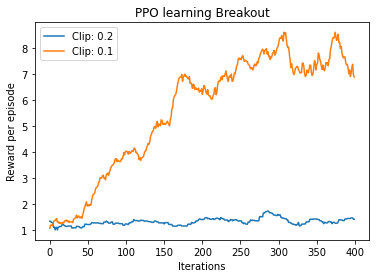

In [57]:
dfs = analysis.trial_dataframes
# Plot by epoch
ax = None  # This plots everything on the same plot
for idx, d in enumerate(dfs.values()):
    ax = d.episode_reward_mean.plot(ax=ax, label="Clip: {}".format(df[["config/clip_param"]].iloc[idx][0]), legend=True)
ax.set_xlabel("Iterations")
ax.set_ylabel("Reward per episode")
ax.set_title("PPO learning Breakout")

In [ ]:
#load DQN rewards
with open("avg_rewards1_restore.txt", "r") as file:
    avg_rewards1_restore = eval(file.readline())

In [ ]:
plt.plot([i+200 for i in range(800)], avg_rewards1_restore, label='DQN rainbow excl dueling')
plt.plot(last_checkpoint[1], label='PPO')

plt.xlabel('Count of Iterations')
plt.ylabel('Reward per Episode')

plt.title('Average Reward in Breakout')
plt.legend(loc='upper left')
plt.show()